In [1]:
from collections import defaultdict, Counter
from datetime import datetime
from xml.etree import ElementTree as ET
import seaborn as sns
import matplotlib.pyplot as plt
from sentence_transformers import SentenceTransformer, util
from tqdm.notebook import trange, tqdm
from sklearn.metrics import pairwise_distances, log_loss
import ot
import numpy as np
from itertools import combinations
import random
import pandas as pd
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.preprocessing import StandardScaler
from copy import deepcopy
import pickle
from scipy.special import expit, logit
import torch
from torch import nn
from sklearn.isotonic import IsotonicRegression
import csv, os, re
from sklearn.decomposition import PCA
from sklearn.neighbors import KernelDensity
from scipy.special import logsumexp
import math
from itertools import product
import cvxpy as cp
import gurobipy as gp
from sklearn.cluster import KMeans

In [2]:
model = SentenceTransformer('sentence-transformers/multi-qa-mpnet-base-cos-v1')

In [3]:
topic = 'cs'

In [4]:
home_data_dir = "../../StackExchange"

In [5]:
tree = ET.parse(home_data_dir + "/data/" + topic + ".stackexchange.com/Posts.xml")

In [6]:
root = tree.getroot()

In [7]:
posts = []
for child in root:
    posts.append(child.attrib)

In [8]:
posts[10]

{'Id': '14',
 'PostTypeId': '1',
 'AcceptedAnswerId': '31',
 'CreationDate': '2012-03-06T20:06:29.977',
 'Score': '35',
 'ViewCount': '4464',
 'Body': '<p>Seeing that in the <a href="http://en.wikipedia.org/wiki/Chomsky_hierarchy">Chomsky Hierarchy</a> Type 3 languages can be recognised by a state machine with no external memory (i.e., a finite automaton), Type 2 by a state machine with a <em>single</em> stack (i.e. a push-down automaton) and Type 0 by a state machine with <em>two</em> stacks (or, equivalently, a tape, as is the case for Turing Machines), how do Type 1 languages fit into this picture? And what advantages does it bring to determine that a language is not only Type 0 but Type 1?</p>\n',
 'OwnerUserId': '26',
 'LastEditorUserId': '69',
 'LastEditDate': '2012-03-07T16:09:28.450',
 'LastActivityDate': '2012-03-08T02:30:13.020',
 'Title': 'What is the significance of context-sensitive (Type 1) languages?',
 'Tags': '<formal-languages><applied-theory><computability><automata>

In [9]:
# for p in posts:
#     if 'ParentId' in p and p['ParentId'] == '108':
#         print(p)

In [10]:
for p in posts:
    if p['Id'] == '163':
        print(p)

{'Id': '163', 'PostTypeId': '1', 'CreationDate': '2012-03-09T15:50:04.077', 'Score': '12', 'ViewCount': '9235', 'Body': '<p>We know from <a href="http://arxiv.org/abs/1201.0749" rel="noreferrer">this paper</a> that there does not exist a puzzle that can be solved starting with 16 or fewer clues, but it implies that there does exist a puzzle that can be solved from 17 clues. Can all valid sudoku puzzles be specified in 17 clues? If not, what is the minimum number of clues that can completely specify every valid puzzle? More formally, does there exist a valid sudoku puzzle (or, I guess it would be a set of puzzles) that cannot be uniquely solved from only 17 clues? If so, then what is the minimum number of clues, $C$, such that every valid sudoku puzzle can be uniquely specified in $C$ or fewer clues?</p>\n', 'OwnerUserId': '12', 'LastEditorUserId': '41', 'LastEditDate': '2012-03-10T15:18:14.037', 'LastActivityDate': '2020-03-30T14:41:48.090', 'Title': 'Minimum number of clues to fully s

In [11]:
len(posts)

103797

In [12]:
tree = ET.parse(home_data_dir + "/data/" + topic + ".stackexchange.com/Users.xml")
users = []
root = tree.getroot()
for child in root:
    users.append(child.attrib)

In [13]:
len(users)

136386

In [14]:
users[:10]

[{'Id': '-1',
  'Reputation': '1',
  'CreationDate': '2012-03-06T18:06:29.800',
  'DisplayName': 'Community',
  'LastAccessDate': '2012-03-06T18:06:29.800',
  'WebsiteUrl': 'http://meta.stackexchange.com/',
  'Location': 'on the server farm',
  'AboutMe': '<p>Hi, I\'m not really a person.</p>\n\n<p>I\'m a background process that helps keep this site clean!</p>\n\n<p>I do things like</p>\n\n<ul>\n<li>Randomly poke old unanswered questions every hour so they get some attention</li>\n<li>Own community questions and answers so nobody gets unnecessary reputation from them</li>\n<li>Own downvotes on spam/evil posts that get permanently deleted</li>\n<li>Own suggested edits from anonymous users</li>\n<li><a href="http://meta.stackexchange.com/a/92006">Remove abandoned questions</a></li>\n</ul>\n',
  'Views': '609',
  'UpVotes': '3012',
  'DownVotes': '4236',
  'AccountId': '-1'},
 {'Id': '2',
  'Reputation': '101',
  'CreationDate': '2012-03-06T18:36:45.160',
  'DisplayName': 'Geoff Dalgas',


In [15]:
user_id_to_user = {u['Id']: u for u in users}

In [16]:
# data_dir = "./stack-exchange-expert-prediction/Dataset"
data_dir = os.path.join(home_data_dir + "/data", "%s.stackexchange.com" % topic)

id_to_votelist = defaultdict(list)
for row in tqdm(csv.DictReader(open(os.path.join(data_dir, 'Votes.csv'), encoding='utf-8'))):
    votetype = row["VoteTypeId"]
    if votetype in ['2', '3']:
        type_map = {'2': 'UpVote', '3': 'DownVote'}
        id_to_votelist[row['PostId']].append(type_map[votetype])

0it [00:00, ?it/s]

In [17]:

# This should all be computed UP TO A CERTAIN TIME POINT, and then we only test after that time.

# But the fields given in the user representation in the data dump are
# "Views" - the number of times the user's profile has been viewed
# 'UpVotes' - the number of upvotes the user has cast
# 'DownVotes' - same idea
# 'Reputation' - duh
# These aren't things that we can slice up by time, and I kind of doubt they will have high Shapley value. 
# Still, we can try them.
# user_id_to_representation = {uid: [int(user['Reputation']), int(user['Views']), int(user['UpVotes']), int(user['DownVotes']), []] 
#                              for uid, user in user_id_to_user.items()}

In [18]:
questions = {}
question_id_to_answers = defaultdict(list)
pid_to_qid = {}
pid_to_body = {}

for p in posts:
    pid_to_body[p['Id']] = p['Body']
    if p['PostTypeId'] == '1' and int(p['Score']) > 2:
        questions[p['Id']] = p
    elif p['PostTypeId'] == '2':
        question_id_to_answers[p['ParentId']].append(p)
        pid_to_qid[p['Id']] = p['ParentId']

In [19]:
len(questions)

12962

In [20]:
len(questions) - len(questions & question_id_to_answers.keys())

1231

In [21]:
len(questions & question_id_to_answers.keys())/len(questions)

0.9050300879493905

In [22]:
len([x for x in questions - question_id_to_answers.keys() if int(questions[x]["Score"]) > 2])

1231

In [23]:
def d(create_date):
    return datetime.strptime(create_date, '%Y-%m-%dT%H:%M:%S.%f')

In [24]:
# Compute the cutoff datetime for the train set
all_datetimes = [d(q['CreationDate']) for q in questions.values()]
burn_in_frac = .1
train_frac = .8
dev_frac = .8
burn_in_date_cutoff = sorted(all_datetimes)[int(len(questions)*burn_in_frac)]
train_date_cutoff = sorted(all_datetimes)[int(len(questions)*train_frac)]
dev_date_cutoff = sorted(all_datetimes)[int(len(questions)*dev_frac)]

In [25]:
print(sorted(all_datetimes)[0], sorted(all_datetimes)[-1])

2008-11-25 14:59:38.553000 2023-12-02 09:37:56.267000


In [26]:
print(burn_in_date_cutoff, train_date_cutoff, dev_date_cutoff)

2012-11-30 02:16:14.930000 2019-02-05 15:03:33.120000 2019-02-05 15:03:33.120000


In [27]:
vocab = set()

for qid, q in tqdm(questions.items()):
    q_tags = q['Tags'][1:-1].split("><")
    vocab |= set(q_tags)
    
sorted_vocab = sorted(list(vocab))
keyphrases_to_idx = {kp: idx for idx, kp in enumerate(sorted_vocab)}

  0%|          | 0/12962 [00:00<?, ?it/s]

In [28]:
len(sorted_vocab)

626

In [29]:
embs = model.encode(sorted_vocab)

In [30]:
print(embs.shape)

(626, 768)


In [31]:
def get_kp_embs(list_of_kps):
    return embs[[keyphrases_to_idx[kp] for kp in list_of_kps], :]

# Ok, we need to go through each post, featurize the post-user pair for each answer. Then we can make pairs of featurized post-user pairs to predict which will have a higher score.

In [32]:
len(questions)

12962

In [33]:
len(question_id_to_answers)

37661

In [34]:
# Assume that the keywords corresponding to q_embs and u_embs each appear only once.
# We will take the top |q_embs| embs from u_embs (the ones with lowest min L2 distance)
# And then compute the Wasserstein distance between the q_embs and u_embs.
def compute_wasserstein(q_embs, u_embs, words):
    if words:
        l2_distances = pairwise_distances(u_embs, q_embs)
        # Restrict to just the ones with the minimum distance
        if q_embs.shape[0] < u_embs.shape[0]:
            min_l2 = np.min(l2_distances, axis=1)
            top_k_idxs = np.argsort(min_l2)[:q_embs.shape[0]]
            dists_top_k = l2_distances[top_k_idxs, :]
        else:
            dists_top_k = l2_distances

        return np.sum(ot.emd([], [], dists_top_k) * dists_top_k)
    else:
        return 2
    
def match_tags(user_tag_cts, q_tags):
    q_tag_set = set(q_tags)
    common_ct = 0
    num_in_common = 0
    for tag, ct in user_tag_cts:
        if tag in q_tag_set:
            common_ct += ct
            num_in_common += 1
    return common_ct*num_in_common

In [35]:
# Assuming we have created the specter/SciNCL/Vicuna/etc-based features, we will load them here
# uid_pid_score = {}
# with open(os.path.join(data_dir, "test-pid2pool-%s-specter-ranked.csv" % topic), 'r') as f:
#     r = csv.DictReader(f)
#     for row in tqdm(r):
#         uid_pid_score[row['uid'], row['pid']] = row['score']

In [36]:
# Get embs for all docs here
# for p in tqdm(posts):
#     if p['PostTypeId'] == '1' and int(p['Score']) > 2:
#         question_title_embs[p['Id']] = model.encode(p['Title'])
#         question_body_embs[p['Id']] = model.encode(p['Body'])
#     elif p['PostTypeId'] == '2' and p["ParentId"] in questions and int(questions[p["ParentId"]]['Score']) > 2:
#         answer_body_embs[p['Id']] = model.encode(p['Body'])

In [37]:
# Load up the map from question-answer pair to relevance, informativeness, and usefulness
rel_map = {}
inf_map = {}
use_map = {}
for row in tqdm(csv.DictReader(open(os.path.join(data_dir, 'cs_answer_quality_annotations.tsv'), encoding='utf-8'), delimiter="\t")):
    rel_map[(row['QID'], row['AID'])] = int(row['Relevance'])
    inf_map[(row['QID'], row['AID'])] = int(row['Informativeness'])
    use_map[(row['QID'], row['AID'])] = int(row['Usefulness'])

0it [00:00, ?it/s]

In [38]:
# Load up the title-title sims, the title-body sims, and the body-body sims.
# cos_sims_title_title = np.load(os.path.join(data_dir, '%s_cos_sims_title_title.npy' % topic))
ids_for_title = pickle.load(open(os.path.join(data_dir, '%s_ids_for_titles.pkl' % topic), 'rb'))

In [39]:
title_embs = np.load(os.path.join(data_dir, '%s_title_embs.npy' % topic))

In [40]:
title_embs.shape

(47730, 768)

In [41]:
ids_for_title[:10]

['100011',
 '100017',
 '10002',
 '100021',
 '100023',
 '100026',
 '100029',
 '100030',
 '100033',
 '100037']

In [42]:
qid_to_title_idx = {qid: idx for idx, qid in enumerate(ids_for_title)}

In [43]:
curr_qid = '100011'
other_qids = ['100017', '10002']
cos_sims = util.cos_sim(title_embs[qid_to_title_idx[curr_qid]], np.vstack([title_embs[qid_to_title_idx[oqid]] for oqid in other_qids]))
print(np.mean(cos_sims.detach().numpy()), np.max(cos_sims.detach().numpy()))

0.029625226 0.04868767


In [44]:
all_ids = pickle.load(open(os.path.join(data_dir, '%s_all_ids.pkl' % topic), 'rb'))

In [45]:
body_embs = np.load(os.path.join(data_dir, '%s_body_embs.npy' % topic))

In [46]:
pid_to_emb_idx = {pid: idx for idx, pid in enumerate(all_ids)}

# Ok, we are actually going to do this differently. We are going to burn in for 20%, then do 50% train and 10% dev , 20% test. We will keep a set of updating user profiles which update with each post. So basically, we can predict which assignment beats the other assignment using features UP TO THIS POINT IN TIME, for each post.

In [47]:
sorted_qids = sorted([(qid, questions[qid]['CreationDate']) for qid in questions], key=lambda x: x[1])
sorted_qids = [x[0] for x in sorted_qids]

In [48]:
train_set = []
train_pair_labels = []
train_scores = []
train_post_ids = []
train_accepted = []
train_votes = []
train_n_answers = []
dev_set = []
dev_pair_labels = []
dev_scores = []
dev_post_ids = []
dev_accepted = []
dev_votes = []
dev_n_answers = []
test_set = []
test_pair_labels = []
test_scores = []
test_post_ids = []
test_accepted = []
test_votes = []
test_n_answers = []

In [49]:
user_id_to_representation = {uid: [int(user['Reputation']), # 0
                                   int(user['Views']), # 1
                                   int(user['UpVotes']), # 2
                                   int(user['DownVotes']), # 3
                                   [], # 4, multiset (list) of tags on questions answered
                                   [], # 5, sorted items in counter of keywords
                                   [], # 6, embeddings of unique keywords in sorted order
                                   [], # 7, List of question creation times for questions they've answered
                                   [], # 8, List of days taken to answer questions
                                   [], # 9, List of reciprocal of answer rank (1, 1/2, 1/3, etc)
                                   [], # 10, list of num views on answered q's
                                   [], # 11, list of scores on answered q's
                                   0, # 12, number of best answers
                                   [], # 13, question ids answered, in order of question creation time
                                   [], # 14, answer ids for answers, in order of question creation time
                                   ] 
                             for uid, user in user_id_to_user.items()}

#Populate keywords
# for qid in tqdm(sorted_qids):
#     cd = d(questions[qid]['CreationDate'])
            
#     if cd < dev_date_cutoff and 'AcceptedAnswerId' in questions[qid]:
#         # Then, add the information from this question to the user representations.
#         q = questions[qid]
#         qkeywords = q['Tags'][1:-1].split("><")
#         accepted_id = q['AcceptedAnswerId']
        
#         for a in question_id_to_answers[qid]:
#             if 'OwnerUserId' in a:
#                 uid = a['OwnerUserId']
#                 user_id_to_representation[uid][4].extend(qkeywords)
#                 # Update the embeddings for this user
#                 c = Counter(user_id_to_representation[uid][4])
#                 sorted_counter = sorted(c.items(), key=lambda x: x[1])
#                 ukeywords = [x[0] for x in sorted_counter]
#                 user_id_to_representation[uid][5] = sorted_counter
#                 user_id_to_representation[uid][6] = get_kp_embs(ukeywords)

In [50]:
smooth_param = 10

for qid in tqdm(sorted_qids):
    # First, check if we need to add this to the train or test set, and add.
    cd = d(questions[qid]['CreationDate'])
    
    if burn_in_date_cutoff < cd and \
    int(questions[qid]['AnswerCount']) > 0 and \
    'AcceptedAnswerId' in questions[qid]:
        q = questions[qid]
#         q_embs = qid_to_embs[qid]
        q_tags = q['Tags'][1:-1].split("><")
        q_embs = get_kp_embs(q_tags)

#         question_title_emb = model.encode(q['Title'])
#         question_title_embs[qid] = question_title_emb
#         question_body_emb = model.encode(q['Body'])
#         question_body_embs[qid] = question_body_emb
        
        accepted_id = q['AcceptedAnswerId']

        answer_feats = []
        answer_scores = []
        answer_accepted = []
        post_ids = []
        for a in question_id_to_answers[qid]:    
            # Get the user representation
            if 'OwnerUserId' in a and len(id_to_votelist[a['Id']]):
                uid = a['OwnerUserId']                
                user_rep = user_id_to_representation[uid]
                af = user_rep[:4]
                af.append(match_tags(user_rep[5], q_tags))
#                 af.append(compute_wasserstein(q_embs, user_rep[6], user_rep[5]))
                
                if len(user_rep[7]):
                    # Compute the days to previous answer
#                     af.append(cd.timestamp() - user_rep[7][-1].timestamp())
                    # Compute the average time taken to answer questions, MRR for prev ans, avg views of prev q's, 
                    # and avg score of prev q's
                    for feat_idx in range(8, 12):
                        af.append(np.mean(np.array(user_rep[feat_idx])))

                    # Add the smoothed fraction of best answers
                    af.append(user_rep[12]/(len(user_rep[11]) + smooth_param))
                    
                    # Add the average usefulness, relevance, and informativeness of past answers
                    qa_pairs = list(zip(user_rep[13], user_rep[14]))
                    usefulness_scores = [use_map[p] for p in qa_pairs]
                    relevance_scores = [rel_map[p] for p in qa_pairs]
                    informativeness_scores = [inf_map[p] for p in qa_pairs]

#                     print(qa_pairs)
#                     print(usefulness_scores, relevance_scores, informativeness_scores)
                    af.append(np.mean(usefulness_scores))
                    af.append(np.mean(informativeness_scores))
                    af.append(np.mean(relevance_scores))
            
                    # Add the avg and max similarity of this title to titles that they have previously answered
#                     curr_qid = '100011'
#                     other_qids = ['100017', '10002']
                    cos_sims = util.cos_sim(title_embs[qid_to_title_idx[qid]], 
                                            np.vstack([title_embs[qid_to_title_idx[oqid]] for oqid in user_rep[13]])).detach().numpy()
                    af.append(np.mean(cos_sims))
                    af.append(np.max(cos_sims))
            
                    # Add the avg and max similarity of the question body to the body of their previous answers
                    cos_sims = util.cos_sim(body_embs[pid_to_emb_idx[qid]], 
                                            np.vstack([body_embs[pid_to_emb_idx[opid]] for opid in user_rep[14]])).detach().numpy()
                    af.append(np.mean(cos_sims))
                    af.append(np.max(cos_sims))
                    
                    # Add the min, 25th percentile, median, 75th percentile, and max of the probabilities of upvotes 
                    # on the user's past answers
                    votes_map = {'UpVote': 1, 'DownVote': 0}

                    prob_uv = []
                    for past_aid in user_rep[14]:
                        vlist = id_to_votelist[past_aid]
                        if len(vlist):
                            prob_up = np.mean([votes_map[indiv_vote] for indiv_vote in vlist])
                            prob_uv.append(prob_up)
#                         else:
#                             prob_uv.append(.5)
                    if len(prob_uv):
                        af.extend([np.percentile(prob_uv, perc) for perc in [0, 5, 10, 25, 50]])
                    else:
                        af.extend([.5, .5, .5, .5, .5])
                
                    answer_feats.append(af)
                    answer_scores.append(int(a['Score']))
                    answer_accepted.append(int(a['Id'] == accepted_id))
                    post_ids.append(a['Id'])
                    
#                 else:
#                     # The user has no previous questions. Add all the default values for features
#                     long_time = d('2023-08-02T00:14:10.580').timestamp() - d('2000-08-02T00:14:10.580').timestamp()
#                     af.extend([
# #                         long_time,
#                                long_time,
#                                0.0,
#                                0.0,
#                                0.0,
#                                0.0
#                               ])
#                 answer_feats.append(af)
#                 answer_scores.append(int(a['Score']))
#                 answer_accepted.append(int(a['Id'] == accepted_id))
#                 post_ids.append(a['Id'])
                
#         # Add some random answers if we're making the train set. Include as many as there are answers,
#         # so we get about 50-50
#         if cd < train_date_cutoff:
#             for uid in sorted(user_id_to_representation.keys(), key=lambda x: random.random())[:10*len(question_id_to_answers[qid])]:
#                 # Get the user representation
#                 user_rep = user_id_to_representation[uid]
#                 af = user_rep[:4]
#                 af.append(match_tags(user_rep[5], q_tags))
# #                 af.append(compute_wasserstein(q_embs, user_rep[6], user_rep[5]))

#                 if len(user_rep[7]):
#                     # Compute the days to previous answer
# #                     af.append(cd.timestamp() - user_rep[7][-1].timestamp())
#                     # Compute the average time taken to answer questions, MRR for prev ans, avg views of prev q's, 
#                     # and avg score of prev q's
#                     for feat_idx in range(8, 12):
#                         af.append(np.mean(np.array(user_rep[feat_idx])))

#                     # Add the smoothed fraction of best answers
#                     af.append(user_rep[12]/(len(user_rep[11]) + smooth_param))
# #                 else:
# #                     # The user has no previous questions. Add all the default values for features
# #                     long_time = d('2023-08-02T00:14:10.580').timestamp() - d('2000-08-02T00:14:10.580').timestamp()
# #                     af.extend([
# # #                         long_time,
# #                                long_time,
# #                                0.0,
# #                                0.0,
# #                                0.0,
# #                                0.0
# #                               ])

#                     answer_feats.append(af)
#                     answer_scores.append(0)
#                     answer_accepted.append(0)
#                     post_ids.append(-1)

        
        if len(answer_scores) > 0:
            # Normalize the answer_scores
            max_answer_score = max(answer_scores)
            min_answer_score = min(answer_scores)
            answer_scores = np.array(answer_scores, dtype=np.float32)
            if max_answer_score > 0:
                answer_scores[answer_scores > 0] /= max_answer_score
            if min_answer_score < 0:
                answer_scores[answer_scores < 0] /= -1*min_answer_score
            answer_scores = answer_scores.tolist()

            print(answer_feats)
            print(answer_scores)
            print(answer_accepted)
            print(post_ids)
            print()


            if cd < train_date_cutoff:
                which_dset = train_set
                which_pair_labels = train_pair_labels
                which_scores = train_scores
                which_post_ids = train_post_ids
                which_accepted = train_accepted
                which_votes = train_votes
                which_n_answers = train_n_answers
            elif train_date_cutoff <= cd < dev_date_cutoff:
                which_dset = dev_set
                which_pair_labels = dev_pair_labels
                which_scores = dev_scores
                which_post_ids = dev_post_ids
                which_accepted = dev_accepted
                which_votes = dev_votes
                which_n_answers = dev_n_answers

            elif dev_date_cutoff <= cd:
                which_dset = test_set
                which_pair_labels = test_pair_labels
                which_scores = test_scores
                which_post_ids = test_post_ids
                which_accepted = test_accepted
                which_votes = test_votes
                which_n_answers = test_n_answers


        # With L2R, we just need to know pairs of indices A, B where A should be higher than B        
#             for a1_idx, a2_idx in combinations(range(len(answer_feats)), 2):
# #                 if answer_scores[a1_idx] < answer_scores[a2_idx]:
# #                     which_pair_labels.append([a2_idx + len(which_dset), a1_idx + len(which_dset)])
# #                 elif answer_scores[a1_idx] > answer_scores[a2_idx]:
# #                     which_pair_labels.append([a1_idx + len(which_dset), a2_idx + len(which_dset)])
#                 if answer_accepted[a1_idx] and not answer_accepted[a2_idx]:
#                     which_pair_labels.append([a1_idx + len(which_dset), a2_idx + len(which_dset)])
#                 if answer_accepted[a2_idx] and not answer_accepted[a1_idx]:
#                     which_pair_labels.append([a2_idx + len(which_dset), a1_idx + len(which_dset)])
            which_scores.extend(answer_scores)
            which_dset.extend(answer_feats)
            which_post_ids.extend(post_ids)
            which_accepted.extend(answer_accepted)
            for pid in post_ids:
                which_votes.append(id_to_votelist[pid])
            n_answers = len(post_ids)
            which_n_answers.extend([n_answers]*n_answers)
            
                
    
    if cd < dev_date_cutoff and 'AcceptedAnswerId' in questions[qid]:
#         print("QID: ", qid)
        # Then, add the information from this question to the user representations.
        q = questions[qid]
        qkeywords = q['Tags'][1:-1].split("><")
        accepted_id = q['AcceptedAnswerId']
        
        uids = []
        answer_scores = []
        answer_accepted = []
        for a in question_id_to_answers[qid]:    
            # Get the user representation
            if 'OwnerUserId' in a:
                uid = a['OwnerUserId']
                uids.append(uid)
                answer_scores.append(int(a['Score']))
                answer_accepted.append(int(a['Id'] == accepted_id))
                
        sort_order = np.argsort(answer_scores)[::-1].tolist()
        mrrs = {}
        for rank, uid_idx in enumerate(sort_order):
            mrrs[uids[uid_idx]] = 1/(rank+1) 
            
        is_best_ans = {uid: int(aa) for uid, aa in zip(uids, answer_accepted)}
        
        for a in question_id_to_answers[qid]:
#             print("AID: ", a['Id'])
            if 'OwnerUserId' in a:
                uid = a['OwnerUserId']
                user_id_to_representation[uid][4].extend(qkeywords)
#                 # Update the embeddings for this user
                c = Counter(user_id_to_representation[uid][4])
                sorted_counter = sorted(c.items(), key=lambda x: x[1])
                ukeywords = [x[0] for x in sorted_counter]
                user_id_to_representation[uid][5] = sorted_counter
#                 user_id_to_representation[uid][6] = get_kp_embs(ukeywords)
                
                ans_cd = d(a['CreationDate'])
                user_id_to_representation[uid][7].append(cd) # question creation time
                user_id_to_representation[uid][8].append(ans_cd.timestamp() - cd.timestamp()) # time taken to answer question
                user_id_to_representation[uid][9].append(mrrs[uid]) # reciprocal of answer rank (1, 1/2, 1/3, etc)
                user_id_to_representation[uid][10].append(int(questions[qid]['ViewCount'])) # num views on q
                user_id_to_representation[uid][11].append(int(questions[qid]['Score'])) # score on q
                user_id_to_representation[uid][12] += is_best_ans[uid]
                user_id_to_representation[uid][13].append(qid)
                user_id_to_representation[uid][14].append(a['Id'])

  0%|          | 0/12962 [00:00<?, ?it/s]

[[1996, 330, 224, 177, 15, 30281386.114199974, 0.6666666666666666, 23102.8, 34.6, 0.13333333333333333, 3.4, 4.0, 4.2, 0.09587182, 0.25610203, 0.1102834, 0.33219942, 0.8, 0.8189473684210526, 0.8378947368421052, 0.8947368421052632, 1.0]]
[1.0]
[1]
['7060']

[[29836, 7494, 2410, 188, 1, 15889307.419923067, 0.6923076923076923, 12847.076923076924, 10.615384615384615, 0.30434782608695654, 3.230769230769231, 4.0, 4.230769230769231, 0.08358379, 0.27731946, 0.15901563, 0.29775327, 1.0, 1.0, 1.0, 1.0, 1.0]]
[1.0]
[1]
['7059']

[[18035, 1832, 3885, 74, 5, 31009.89908332626, 0.8541666666666666, 11410.666666666666, 11.916666666666666, 0.5, 3.7083333333333335, 4.166666666666667, 4.166666666666667, 0.12034053, 0.53736347, 0.13278903, 0.3947016, 1.0, 1.0, 1.0, 1.0, 1.0]]
[1.0]
[1]
['7066']

[[954, 91, 19, 4, 0, 2343589.6633333364, 0.6666666666666666, 8975.333333333334, 10.333333333333334, 0.07692307692307693, 3.6666666666666665, 4.0, 4.0, 0.030373134, 0.08738377, 0.1085963, 0.1401605, 1.0, 1.0, 1.0, 1

[[29836, 7494, 2410, 188, 2, 10334870.897549998, 0.775, 8958.9, 8.4, 0.43333333333333335, 3.25, 4.0, 4.15, 0.18950863, 0.3324827, 0.18417372, 0.39067724, 1.0, 1.0, 1.0, 1.0, 1.0], [43272, 6417, 7004, 1931, 4, 529434.0915964905, 0.8280701754385965, 10062.052631578947, 18.31578947368421, 0.5970149253731343, 3.719298245614035, 4.087719298245614, 4.140350877192983, 0.110155106, 0.3841902, 0.13331492, 0.4182226, 0.8, 0.9789746543778802, 1.0, 1.0, 1.0]]
[0.5, 1.0]
[0, 1]
['7567', '7669']

[[12438, 1242, 447, 94, 8, 1581744.105000019, 0.80679012345679, 6943.814814814815, 10.592592592592593, 0.4864864864864865, 3.4074074074074074, 4.074074074074074, 4.185185185185185, 0.10593596, 0.3444608, 0.1094542, 0.27532512, 0.8, 1.0, 1.0, 1.0, 1.0], [29836, 7494, 2410, 188, 22, 9842882.438761905, 0.7619047619047619, 8666.714285714286, 8.142857142857142, 0.41935483870967744, 3.238095238095238, 4.0, 4.142857142857143, 0.23148577, 0.42505974, 0.19471776, 0.5721064, 1.0, 1.0, 1.0, 1.0, 1.0]]
[1.0, 0.63636362

[[4161, 324, 100, 17, 18, 133089.36239999134, 0.8555555555555556, 5911.533333333334, 13.466666666666667, 0.36, 3.4, 4.0, 4.066666666666666, 0.14186469, 0.34497076, 0.18855728, 0.36353415, 1.0, 1.0, 1.0, 1.0, 1.0], [15495, 1774, 911, 74, 10, 2549221.263500035, 0.6916666666666667, 1451.375, 6.0, 0.2222222222222222, 3.375, 4.0, 4.0, 0.1277067, 0.45523095, 0.18588898, 0.44939953, 1.0, 1.0, 1.0, 1.0, 1.0]]
[1.0, 0.2857142984867096]
[1, 0]
['9064', '9068']

[[13949, 1322, 2403, 6, 0, 42365481.32293335, 0.38740740740740737, 18863.466666666667, 16.8, 0.0, 3.066666666666667, 3.933333333333333, 4.0, 0.024198465, 0.1376057, 0.028718228, 0.17109719, 0.5, 0.775, 1.0, 1.0, 1.0], [4067, 336, 273, 28, 0, 296278.16911764705, 0.6147058823529411, 14764.882352941177, 16.58823529411765, 0.2222222222222222, 3.6470588235294117, 4.0588235294117645, 4.117647058823529, 0.03743891, 0.31374118, 0.07643919, 0.37530464, 0.0, 0.6400000000000001, 0.92, 1.0, 1.0], [2258, 889, 26, 2, 0, 5587874.33133332, 0.75, 6585.666

[[275180, 35472, 20783, 229, 50, 14418342.343919994, 0.7909999999999999, 11847.78, 12.86, 0.5818181818181818, 3.41, 4.04, 4.04, 0.02923302, 0.38431093, 0.053137645, 0.2871631, 0.875, 1.0, 1.0, 1.0, 1.0]]
[1.0]
[1]
['9588']

[[12438, 1242, 447, 94, 51, 2251077.586969708, 0.8015151515151516, 6837.69696969697, 10.393939393939394, 0.5116279069767442, 3.484848484848485, 4.0606060606060606, 4.212121212121212, 0.108686924, 0.4397366, 0.11542015, 0.2765281, 0.8, 1.0, 1.0, 1.0, 1.0]]
[1.0]
[1]
['9579']

[[4099, 216, 135, 3, 18, 59147.982624948025, 0.8375, 8854.625, 12.0, 0.2777777777777778, 3.625, 4.0, 4.0, 0.20201421, 0.34027225, 0.21619998, 0.3616113, 1.0, 1.0, 1.0, 1.0, 1.0], [22161, 2572, 2170, 111, 280, 1100773.1829607862, 0.6946311858076564, 20003.843137254902, 38.09803921568628, 0.4262295081967213, 3.176470588235294, 3.784313725490196, 3.764705882352941, 0.20873713, 0.53011036, 0.24723274, 0.5485645, 0.9285714285714286, 1.0, 1.0, 1.0, 1.0], [12438, 1242, 447, 94, 135, 2185483.09588236, 0

[[2258, 889, 26, 2, 0, 754740.9897083243, 0.5673611111111111, 12612.916666666666, 23.208333333333332, 0.23529411764705882, 3.2916666666666665, 4.0, 4.0, 0.085390925, 0.37574816, 0.094394624, 0.2947588, 0.7142857142857143, 0.8416666666666667, 1.0, 1.0, 1.0], [20165, 2244, 1778, 39, 2, 174819.92189333597, 0.8497777777777777, 8023.653333333334, 17.12, 0.6823529411764706, 3.5866666666666664, 4.093333333333334, 4.213333333333333, 0.10009928, 0.4138164, 0.10242512, 0.4469876, 0.5, 0.96, 1.0, 1.0, 1.0], [1280, 78, 18, 8, 0, 198174.17750000954, 1.0, 45042.75, 29.0, 0.2857142857142857, 3.5, 4.0, 4.0, 0.07062412, 0.22952452, 0.052479923, 0.13103661, 1.0, 1.0, 1.0, 1.0, 1.0]]
[0.2857142984867096, 1.0, 0.2857142984867096]
[0, 1, 0]
['9898', '9900', '9966']

[[3678, 399, 198, 17, 8, 1193567.1766666572, 0.6203703703703703, 22639.777777777777, 18.88888888888889, 0.10526315789473684, 3.6666666666666665, 4.111111111111111, 4.111111111111111, 0.095017835, 0.39684448, 0.111031, 0.3204438, 1.0, 1.0, 1.0, 

[[30039, 4498, 379, 369, 0, 454122.40540740226, 0.8641975308641975, 6367.555555555556, 12.88888888888889, 0.4864864864864865, 3.4814814814814814, 4.0, 4.0, 0.10143061, 0.25480533, 0.13075644, 0.2572923, 0.5, 0.8, 1.0, 1.0, 1.0], [28325, 2557, 183, 103, 5, 244448946.5274999, 0.2777777777777778, 63685.166666666664, 68.0, 0.0, 3.4166666666666665, 4.083333333333333, 4.083333333333333, 0.063924946, 0.2284244, 0.08687872, 0.20857006, 1.0, 1.0, 1.0, 1.0, 1.0]]
[1.0, 0.014705882407724857]
[1, 0]
['10321', '96292']

[[275180, 35472, 20783, 229, 0, 11937894.095330639, 0.7971774193548387, 10231.411290322581, 12.008064516129032, 0.582089552238806, 3.4274193548387095, 4.048387096774194, 4.048387096774194, 0.090927646, 0.3401244, 0.08070203, 0.43108103, 0.75, 1.0, 1.0, 1.0, 1.0], [3678, 399, 198, 17, 0, 1074356.4319999933, 0.5916666666666666, 21142.9, 17.4, 0.1, 3.6, 4.1, 4.1, 0.077663004, 0.2298657, 0.09225556, 0.28819472, 0.6, 0.78, 0.96, 1.0, 1.0], [12806, 985, 457, 155, 3, 12207.779966656368, 0.

[[13949, 1322, 2403, 6, 0, 22194505.817025024, 0.5219444444444444, 10028.35, 10.475, 0.22, 3.15, 3.925, 3.975, 0.046109926, 0.22968294, 0.03824303, 0.26629817, 0.5, 0.625, 0.775, 1.0, 1.0], [72016, 18319, 5085, 3119, 40, 1780067.7865131497, 0.7287907268170426, 11390.203947368422, 20.151315789473685, 0.5, 3.6315789473684212, 4.052631578947368, 4.092105263157895, 0.09628327, 0.67959785, 0.10683173, 0.620258, 0.5, 0.9683441558441559, 1.0, 1.0, 1.0]]
[1.0, 0.4000000059604645]
[1, 0]
['10731', '10767']

[[18035, 1832, 3885, 74, 72, 29226.939531244338, 0.7916666666666667, 11141.9375, 10.1875, 0.5, 3.71875, 4.15625, 4.1875, 0.1746141, 0.63161844, 0.19041485, 0.52517575, 0.5, 1.0, 1.0, 1.0, 1.0]]
[1.0]
[1]
['10734']

[[16974, 1585, 275, 8, 6, 1366514.963695661, 0.8072463768115942, 5771.086956521739, 8.695652173913043, 0.5454545454545454, 3.652173913043478, 4.173913043478261, 4.260869565217392, 0.09979421, 0.46827424, 0.09237469, 0.35728848, 0.75, 0.7838888888888889, 0.91, 1.0, 1.0]]
[1.0]
[1]


[[12438, 1242, 447, 94, 32, 1816379.181390239, 0.828048780487805, 5872.682926829269, 9.536585365853659, 0.5490196078431373, 3.4878048780487805, 4.073170731707317, 4.195121951219512, 0.12076755, 0.43275142, 0.11954047, 0.55299866, 0.8, 1.0, 1.0, 1.0, 1.0]]
[1.0]
[1]
['11162']

[[3452, 384, 686, 26, 0, 16790049.630000114, 0.75, 2773.0, 15.5, 0.0, 3.0, 4.0, 4.0, 0.12177668, 0.16520667, 0.13359359, 0.13813022, 1.0, 1.0, 1.0, 1.0, 1.0], [20644, 1784, 1242, 71, 16, 291100.2395666599, 0.7602777777777778, 10041.766666666666, 14.283333333333333, 0.5142857142857142, 3.566666666666667, 4.066666666666666, 4.1, 0.030721297, 0.17555332, 0.06443539, 0.23982295, 0.8888888888888888, 1.0, 1.0, 1.0, 1.0]]
[1.0, 0.25]
[0, 1]
['11189', '11217']

[[20644, 1784, 1242, 71, 92, 288462.5181967157, 0.7560109289617486, 9884.459016393443, 14.180327868852459, 0.5211267605633803, 3.5737704918032787, 4.065573770491803, 4.098360655737705, 0.16385704, 0.5709034, 0.1866192, 0.5716901, 0.8888888888888888, 1.0, 1.0, 1.0, 

[[21631, 1544, 387, 28, 0, 106172040.11199999, 0.6666666666666666, 870.5, 16.5, 0.08333333333333333, 3.5, 4.0, 4.5, 0.08917148, 0.13442075, 0.028149098, 0.14203799, 1.0, 1.0, 1.0, 1.0, 1.0]]
[1.0]
[1]
['11670']

[[275180, 35472, 20783, 229, 44, 10320176.14483438, 0.8047770700636943, 8933.407643312103, 11.089171974522293, 0.6047904191616766, 3.43312101910828, 4.038216560509555, 4.044585987261146, 0.05674157, 0.25164795, 0.109172106, 0.3772093, 0.75, 1.0, 1.0, 1.0, 1.0]]
[1.0]
[1]
['11679']

[[275180, 35472, 20783, 229, 114, 10254875.05832277, 0.8060126582278481, 8878.620253164558, 11.037974683544304, 0.6071428571428571, 3.430379746835443, 4.037974683544304, 4.044303797468355, 0.113420956, 0.50234336, 0.104951136, 0.42274228, 0.75, 1.0, 1.0, 1.0, 1.0], [10996, 1792, 4078, 37, 27, 13322632.839444442, 0.4721252204585537, 5994.0, 18.244444444444444, 0.16363636363636364, 3.066666666666667, 4.0, 3.977777777777778, 0.10047012, 0.3100264, 0.10889755, 0.32168376, 0.0, 0.0, 0.3800000000000001, 0.

[[275180, 35472, 20783, 229, 284, 10763489.924029225, 0.8110136452241715, 8321.859649122807, 10.736842105263158, 0.6022099447513812, 3.415204678362573, 4.023391812865497, 4.035087719298246, 0.055631246, 0.40485078, 0.112086415, 0.41228342, 0.75, 1.0, 1.0, 1.0, 1.0]]
[1.0]
[1]
['12208']

[[291, 7, 10, 0, 0, 15294170.177000046, 1.0, 685.0, 7.0, 0.09090909090909091, 3.0, 4.0, 4.0, 0.025131702, 0.025131702, 0.01330051, 0.01330051, 1.0, 1.0, 1.0, 1.0, 1.0]]
[0.0]
[0]
['12214']

[[1280, 78, 18, 8, 4, 188909.81860003472, 0.9, 36141.6, 24.4, 0.26666666666666666, 3.4, 4.0, 4.0, 0.08143115, 0.21484661, 0.103099786, 0.26555794, 1.0, 1.0, 1.0, 1.0, 1.0]]
[1.0]
[1]
['12227']

[[17653, 1744, 804, 118, 0, 28180546.279666584, 0.8333333333333334, 22627.666666666668, 13.666666666666666, 0.15384615384615385, 3.6666666666666665, 4.0, 4.333333333333333, 0.04466912, 0.11537095, 0.0601483, 0.18526608, 0.9285714285714286, 0.9357142857142857, 0.9428571428571428, 0.9642857142857143, 1.0]]
[1.0]
[1]
['12228']

[

[[15495, 1774, 911, 74, 42, 981210.6375238441, 0.7373015873015873, 11020.952380952382, 25.857142857142858, 0.41935483870967744, 3.4761904761904763, 4.0476190476190474, 4.0476190476190474, 0.15846546, 0.5822829, 0.13851355, 0.41475484, 0.9166666666666666, 0.9958333333333333, 1.0, 1.0, 1.0], [3678, 399, 198, 17, 1, 631585.8270555205, 0.48055555555555557, 20303.277777777777, 17.88888888888889, 0.07142857142857142, 3.5555555555555554, 4.055555555555555, 4.055555555555555, 0.06257153, 0.22351894, 0.075854175, 0.31779045, 0.6, 0.6566666666666666, 0.725, 1.0, 1.0], [4161, 324, 100, 17, 14, 103718.45257143748, 0.8492063492063492, 6460.952380952381, 12.952380952380953, 0.41935483870967744, 3.4761904761904763, 4.0, 4.0476190476190474, 0.18382655, 0.5822829, 0.15302192, 0.4857784, 0.9285714285714286, 1.0, 1.0, 1.0, 1.0], [3452, 384, 686, 26, 6, 3669438.243800044, 0.8333333333333333, 1650.8, 9.7, 0.25, 3.2, 4.0, 4.0, 0.085871525, 0.17635287, 0.111556746, 0.2590189, 1.0, 1.0, 1.0, 1.0, 1.0], [28325

[[29836, 7494, 2410, 188, 18, 4194545.608000016, 0.81, 8176.76, 8.34, 0.55, 3.28, 4.0, 4.08, 0.117934495, 0.30398756, 0.1519403, 0.35973948, 1.0, 1.0, 1.0, 1.0, 1.0]]
[1.0]
[1]
['13473']

[[17653, 1744, 804, 118, 0, 7786558.442999992, 0.8939393939393938, 12233.818181818182, 10.090909090909092, 0.42857142857142855, 3.5454545454545454, 4.0, 4.181818181818182, 0.03760277, 0.12017877, 0.11216793, 0.23077919, 0.9285714285714286, 0.9285714285714286, 0.9285714285714286, 1.0, 1.0]]
[1.0]
[1]
['13359']

[[275180, 35472, 20783, 229, 24, 9393653.892908152, 0.8215136054421768, 7382.913265306122, 10.045918367346939, 0.6262135922330098, 3.4030612244897958, 4.010204081632653, 4.025510204081633, 0.05742004, 0.5915785, 0.06289847, 0.38444585, 0.75, 1.0, 1.0, 1.0, 1.0]]
[1.0]
[1]
['13367']

[[155758, 18380, 20909, 10380, 6, 5592450.016428595, 0.7142857142857143, 1427.7619047619048, 6.809523809523809, 0.3225806451612903, 3.6666666666666665, 4.190476190476191, 4.190476190476191, 0.10412448, 0.27706018, 0.

[[2090, 129, 173, 10, 0, 20501.360000133514, 0.5, 2757.0, 5.0, 0.0, 5.0, 4.0, 5.0, 0.04947382, 0.04947382, -0.064028144, -0.064028144, 1.0, 1.0, 1.0, 1.0, 1.0], [12806, 985, 457, 155, 0, 16016.003666660521, 0.8237037037037036, 7131.311111111111, 13.0, 0.5272727272727272, 3.577777777777778, 4.0, 4.022222222222222, 0.0409144, 0.278785, 0.043251757, 0.2470969, 0.6666666666666666, 1.0, 1.0, 1.0, 1.0]]
[1.0, 0.5333333611488342]
[1, 0]
['13811', '13820']

[[6014, 616, 158, 39, 5, 51432332.67344448, 0.6111111111111112, 15963.555555555555, 13.11111111111111, 0.05263157894736842, 3.6666666666666665, 4.111111111111111, 4.222222222222222, 0.080602676, 0.13623615, 0.065084726, 0.12117873, 1.0, 1.0, 1.0, 1.0, 1.0]]
[1.0]
[1]
['13831']

[[275180, 35472, 20783, 229, 276, 8769009.226566657, 0.8254761904761905, 7596.980952380953, 10.052380952380952, 0.6363636363636364, 3.3857142857142857, 4.0095238095238095, 4.023809523809524, 0.04433584, 0.43557543, 0.08531963, 0.4731755, 0.75, 1.0, 1.0, 1.0, 1.0]]
[1

[[275180, 35472, 20783, 229, 98, 8333419.373733021, 0.8296380090497737, 7368.524886877828, 9.828054298642535, 0.6363636363636364, 3.3891402714932126, 4.013574660633484, 4.031674208144796, 0.096102096, 0.44962716, 0.10541002, 0.33655757, 0.75, 1.0, 1.0, 1.0, 1.0]]
[1.0]
[1]
['14383']

[[275180, 35472, 20783, 229, 232, 8295919.900049539, 0.8304054054054054, 7336.477477477478, 9.806306306306306, 0.6379310344827587, 3.3873873873873874, 4.013513513513513, 4.031531531531532, 0.061669316, 0.33164644, 0.06745333, 0.3374089, 0.75, 1.0, 1.0, 1.0, 1.0], [8308, 671, 629, 17, 4, 8662882.582285745, 0.6904761904761905, 1462.2857142857142, 14.0, 0.23529411764705882, 3.2857142857142856, 4.0, 4.0, 0.16333757, 0.32749358, 0.23213382, 0.4002428, 1.0, 1.0, 1.0, 1.0, 1.0], [6014, 616, 158, 39, 48, 33072719.917214327, 0.6666666666666666, 12313.214285714286, 9.857142857142858, 0.125, 3.5, 4.071428571428571, 4.142857142857143, 0.12559815, 0.39547074, 0.1154815, 0.35944027, 1.0, 1.0, 1.0, 1.0, 1.0]]
[0.84615385

[[1696, 224, 22, 0, 0, 34749.05250003934, 0.875, 7510.5, 7.625, 0.2777777777777778, 3.75, 4.125, 4.125, 0.026098909, 0.1310451, 0.049818322, 0.15911767, 1.0, 1.0, 1.0, 1.0, 1.0], [72016, 18319, 5085, 3119, 69, 1948047.2231301963, 0.7180183531746032, 11476.963541666666, 18.604166666666668, 0.4801980198019802, 3.5677083333333335, 4.046875, 4.088541666666667, 0.09414649, 0.7122884, 0.15994154, 0.50876236, 0.5, 0.9583333333333334, 1.0, 1.0, 1.0], [43272, 6417, 7004, 1931, 12, 1221212.6248048746, 0.8357723577235772, 8699.487804878048, 16.097560975609756, 0.6195652173913043, 3.707317073170732, 4.097560975609756, 4.146341463414634, 0.07041592, 0.46790797, 0.15355155, 0.45126992, 0.8, 0.9838709677419355, 1.0, 1.0, 1.0]]
[0.27272728085517883, 0.9090909361839294, 1.0]
[0, 0, 1]
['14884', '14885', '14893']

[[9037, 1049, 780, 0, 1, 12753428.758125007, 0.7708333333333333, 25033.875, 36.0, 0.2777777777777778, 4.25, 4.5, 4.625, 0.020117562, 0.097657345, 0.023351558, 0.11484209, 1.0, 1.0, 1.0, 1.0, 1

[[275180, 35472, 20783, 229, 243, 7397435.941578306, 0.830722891566265, 7177.208835341366, 10.032128514056225, 0.6332046332046332, 3.389558232931727, 4.020080321285141, 4.048192771084337, 0.08111756, 0.32249165, 0.1095623, 0.4865215, 0.75, 1.0, 1.0, 1.0, 1.0]]
[1.0]
[1]
['16420']

[[155758, 18380, 20909, 10380, 44, 2761321.0967272846, 0.7386363636363636, 3212.409090909091, 6.363636363636363, 0.4444444444444444, 3.6363636363636362, 4.159090909090909, 4.113636363636363, 0.13319741, 0.4766168, 0.11819754, 0.37240708, 0.0, 1.0, 1.0, 1.0, 1.0]]
[1.0]
[1]
['16422']

[[275180, 35472, 20783, 229, 42, 7367860.543131992, 0.8314, 7152.204, 10.004, 0.6346153846153846, 3.388, 4.02, 4.048, 0.09252855, 0.5012486, 0.128543, 0.3596403, 0.75, 1.0, 1.0, 1.0, 1.0]]
[1.0]
[1]
['16437']

[[155758, 18380, 20909, 10380, 96, 2700061.703533347, 0.7444444444444445, 3269.8888888888887, 6.288888888888889, 0.45454545454545453, 3.6444444444444444, 4.177777777777778, 4.133333333333334, 0.12841666, 0.37151182, 0.15601

[[275180, 35472, 20783, 229, 74, 7057998.706651333, 0.8314814814814814, 6971.252873563219, 9.804597701149426, 0.6346863468634686, 3.3946360153256707, 4.022988505747127, 4.057471264367816, 0.1386555, 0.5795436, 0.118456736, 0.53045183, 0.6666666666666666, 1.0, 1.0, 1.0, 1.0]]
[1.0]
[1]
['17978']

[[3657, 559, 39, 3, 0, 14220.464000008324, 0.6515151515151515, 7774.727272727273, 8.181818181818182, 0.23809523809523808, 3.1818181818181817, 3.8181818181818183, 3.909090909090909, 0.10155631, 0.29653263, 0.0562227, 0.16674685, 0.6666666666666666, 0.7266666666666667, 0.7866666666666667, 0.9318181818181818, 1.0], [155758, 18380, 20909, 10380, 1, 2382708.966327286, 0.7490909090909091, 3296.3636363636365, 6.327272727272727, 0.47692307692307695, 3.6545454545454548, 4.181818181818182, 4.127272727272727, 0.060594182, 0.30961317, 0.046007268, 0.19663605, 0.0, 1.0, 1.0, 1.0, 1.0], [43272, 6417, 7004, 1931, 42, 1168059.630127904, 0.8317829457364341, 8773.023255813954, 15.662790697674419, 0.625, 3.697674

[[16974, 1585, 275, 8, 45, 657775.1486037857, 0.8471698113207546, 3810.5283018867926, 6.811320754716981, 0.6825396825396826, 3.452830188679245, 4.0754716981132075, 4.09433962264151, 0.07592371, 0.43690157, 0.12027949, 0.44016552, 0.6666666666666666, 0.8450000000000001, 1.0, 1.0, 1.0]]
[1.0]
[1]
['18704']

[[22493, 2324, 5306, 841, 40, 6545452.233279991, 0.8016666666666667, 5829.02, 13.28, 0.5833333333333334, 3.58, 4.12, 4.12, 0.13803497, 0.5872128, 0.1488585, 0.39079064, 0.5, 0.9673913043478262, 1.0, 1.0, 1.0], [81428, 13054, 2609, 3683, 8, 34558119.38216668, 0.5515873015873015, 5442.25, 11.25, 0.22727272727272727, 3.5833333333333335, 4.166666666666667, 4.166666666666667, 0.108711995, 0.36029392, 0.09642319, 0.17417842, 0.9, 0.9166666666666667, 0.9333333333333333, 1.0, 1.0], [6014, 616, 158, 39, 6, 25729808.500555594, 0.7129629629629629, 9847.666666666666, 9.277777777777779, 0.21428571428571427, 3.4444444444444446, 4.055555555555555, 4.111111111111111, 0.021759667, 0.17997538, 0.065660

[[275180, 35472, 20783, 229, 58, 7071489.246641835, 0.8312647754137116, 6695.36170212766, 9.432624113475176, 0.636986301369863, 3.4078014184397163, 4.028368794326241, 4.0638297872340425, 0.031021213, 0.51539904, 0.13452403, 0.38475478, 0.5, 1.0, 1.0, 1.0, 1.0]]
[1.0]
[1]
['19206']

[[29836, 7494, 2410, 188, 1, 3345284.4220000072, 0.8187830687830688, 7074.841269841269, 7.587301587301587, 0.589041095890411, 3.3174603174603177, 4.015873015873016, 4.079365079365079, 0.0527126, 0.38119358, 0.035876356, 0.34410715, 1.0, 1.0, 1.0, 1.0, 1.0]]
[1.0]
[1]
['19255']

[[81428, 13054, 2609, 3683, 5, 17288062.874250025, 0.7132936507936507, 7681.25, 9.541666666666666, 0.3235294117647059, 3.6666666666666665, 4.166666666666667, 4.125, 0.08381697, 0.36243248, 0.14143538, 0.4238953, 0.9, 0.9400000000000001, 1.0, 1.0, 1.0]]
[1.0]
[1]
['19248']

[[81428, 13054, 2609, 3683, 6, 16597857.10260003, 0.7247619047619047, 7908.24, 9.32, 0.34285714285714286, 3.68, 4.16, 4.12, 0.16432801, 0.5191122, 0.1283577, 0.5001

[[1357, 120, 30, 0, 4, 63474.593571424484, 0.8333333333333333, 612.8571428571429, 3.4285714285714284, 0.29411764705882354, 3.7142857142857144, 4.0, 4.0, 0.1757085, 0.32005078, 0.21741079, 0.3603873, 1.0, 1.0, 1.0, 1.0, 1.0]]
[1.0]
[1]
['22273']

[[275180, 35472, 20783, 229, 1, 6876530.370413785, 0.835919540229885, 6697.9689655172415, 9.296551724137931, 0.6433333333333333, 3.406896551724138, 4.027586206896552, 4.062068965517241, 0.07038077, 0.3177726, 0.12551911, 0.3450899, 0.5, 1.0, 1.0, 1.0, 1.0]]
[1.0]
[1]
['19903']

[[233, 17, 626, 0, 0, 341877.0300002098, 0.25, 4574.0, 11.0, 0.0, 3.0, 4.0, 4.0, 0.09080057, 0.09080057, 0.02286816, 0.02286816, 1.0, 1.0, 1.0, 1.0, 1.0], [43272, 6417, 7004, 1931, 6, 1059611.208957888, 0.8371929824561404, 8476.578947368422, 15.452631578947368, 0.6476190476190476, 3.6736842105263157, 4.094736842105263, 4.136842105263158, 0.064742096, 0.26261148, 0.10099933, 0.35207835, 0.8, 0.9943548387096774, 1.0, 1.0, 1.0]]
[0.20000000298023224, 1.0]
[0, 1]
['20275', '

[[16974, 1585, 275, 8, 42, 623365.117250004, 0.8464285714285714, 4071.5178571428573, 7.107142857142857, 0.696969696969697, 3.482142857142857, 4.089285714285714, 4.107142857142857, 0.0803928, 0.45392832, 0.088114545, 0.44032723, 0.6666666666666666, 0.8633333333333334, 1.0, 1.0, 1.0], [214, 23, 2, 0, 1, 1044.6669998168945, 0.5, 1346.0, 4.0, 0.0, 4.0, 4.0, 5.0, 0.13678142, 0.13678142, 0.12818433, 0.12818433, 0.5, 0.5, 0.5, 0.5, 0.5]]
[1.0, -1.0]
[1, 0]
['21374', '21375']

[[275180, 35472, 20783, 229, 8, 6582062.511792071, 0.8358085808580857, 6540.702970297029, 9.108910891089108, 0.6485623003194888, 3.4158415841584158, 4.033003300330033, 4.066006600660066, 0.057298686, 0.5391083, 0.06904495, 0.5095508, 0.5, 1.0, 1.0, 1.0, 1.0], [13949, 1322, 2403, 6, 9, 24005219.901000008, 0.5465740740740741, 9386.8, 11.016666666666667, 0.2571428571428571, 3.1333333333333333, 3.9, 3.933333333333333, 0.08783888, 0.3740396, 0.09637009, 0.46258467, 0.5, 0.7125, 0.8033333333333333, 1.0, 1.0]]
[1.0, 0.5]
[0, 1]

[[275180, 35472, 20783, 229, 222, 6416648.950511246, 0.8358520900321543, 6430.91961414791, 8.993569131832798, 0.6479750778816199, 3.42443729903537, 4.035369774919614, 4.07395498392283, 0.10758041, 0.45325562, 0.11283277, 0.44086137, 0.5, 1.0, 1.0, 1.0, 1.0]]
[1.0]
[1]
['21911']

[[81428, 13054, 2609, 3683, 28, 14788353.341842137, 0.7399749373433583, 8779.0, 10.0, 0.4166666666666667, 3.5526315789473686, 4.131578947368421, 4.131578947368421, 0.05375973, 0.26238883, 0.09107497, 0.36225823, 0.9, 0.93625, 0.9666666666666667, 1.0, 1.0]]
[1.0]
[1]
['22010']

[[858, 37, 84, 4, 0, 580668.5668000221, 0.8, 1487.0, 12.6, 0.13333333333333333, 3.8, 4.2, 4.4, 0.011188311, 0.03645598, 0.0075916843, 0.06889634, 1.0, 1.0, 1.0, 1.0, 1.0], [81428, 13054, 2609, 3683, 5, 14409247.97589747, 0.7466422466422465, 8569.564102564103, 9.820512820512821, 0.42857142857142855, 3.5384615384615383, 4.128205128205129, 4.128205128205129, 0.04387409, 0.48845088, 0.096513286, 0.25607973, 0.9, 0.9364583333333334, 0.97222222

[[275180, 35472, 20783, 229, 0, 6159634.896472214, 0.8362654320987654, 6336.682098765432, 8.86111111111111, 0.6497005988023952, 3.435185185185185, 4.037037037037037, 4.074074074074074, 0.09479525, 0.50825346, 0.093210265, 0.5315505, 0.5, 1.0, 1.0, 1.0, 1.0]]
[1.0]
[1]
['22469']

[[4132, 399, 43, 2, 0, 139288.99673913873, 0.7789855072463767, 9635.260869565218, 20.043478260869566, 0.42424242424242425, 3.5217391304347827, 4.086956521739131, 4.086956521739131, 0.08709523, 0.32515216, 0.093994826, 0.23216265, 0.6666666666666666, 0.8904761904761904, 0.9056277056277057, 1.0, 1.0], [13949, 1322, 2403, 6, 24, 21501069.205970153, 0.5516583747927032, 8744.746268656716, 10.253731343283581, 0.2727272727272727, 3.1044776119402986, 3.8805970149253732, 3.91044776119403, 0.09257201, 0.35122937, 0.10755968, 0.65794456, 0.0, 0.5, 0.79, 1.0, 1.0], [636, 686, 87, 2, 0, -83499.06299996376, 0.5, 4889.0, 15.0, 0.0, 3.0, 4.0, 4.0, 0.13872771, 0.13872771, 0.063131906, 0.063131906, 1.0, 1.0, 1.0, 1.0, 1.0], [109

[[19385, 2101, 622, 2, 0, 13222762.354600016, 0.6, 4392.133333333333, 11.933333333333334, 0.28, 3.2666666666666666, 4.066666666666666, 4.066666666666666, 0.038367987, 0.14484581, 0.06165823, 0.20264223, 0.9090909090909091, 0.9436363636363636, 0.9733333333333334, 1.0, 1.0]]
[1.0]
[1]
['22876']

[[275180, 35472, 20783, 229, 14, 5904851.834979283, 0.8351577909270216, 6197.917159763314, 8.792899408284024, 0.6494252873563219, 3.4497041420118344, 4.044378698224852, 4.079881656804734, 0.07695976, 0.46028855, 0.12467356, 0.56262445, 0.5, 1.0, 1.0, 1.0, 1.0]]
[1.0]
[1]
['22923']

[[6569, 742, 361, 463, 16, 10814610.259526327, 0.7807017543859649, 3115.0526315789475, 7.157894736842105, 0.41379310344827586, 3.3684210526315788, 3.8947368421052633, 3.9473684210526314, 0.07133076, 0.386792, 0.074406646, 0.30848265, 1.0, 1.0, 1.0, 1.0, 1.0], [29836, 7494, 2410, 188, 147, 3243492.5557846255, 0.8243589743589743, 6998.215384615384, 7.492307692307692, 0.6, 3.3076923076923075, 4.015384615384615, 4.07692307

[[275180, 35472, 20783, 229, 174, 5702710.168551421, 0.8393809523809523, 6087.9628571428575, 8.857142857142858, 0.6583333333333333, 3.4457142857142857, 4.042857142857143, 4.08, 0.07288816, 0.43316036, 0.08399924, 0.52052313, 0.5, 1.0, 1.0, 1.0, 1.0]]
[1.0]
[1]
['23259']

[[275180, 35472, 20783, 229, 36, 5686490.357547001, 0.8398385565052231, 6081.746438746439, 8.84045584045584, 0.6592797783933518, 3.4444444444444446, 4.042735042735043, 4.07977207977208, 0.050114635, 0.45815143, 0.070493706, 0.4611007, 0.5, 1.0, 1.0, 1.0, 1.0], [13949, 1322, 2403, 6, 1, 22912470.686098594, 0.5522691705790298, 8539.267605633802, 10.23943661971831, 0.25925925925925924, 3.0985915492957745, 3.887323943661972, 3.915492957746479, 0.04353273, 0.24963333, 0.083177045, 0.3933962, 0.0, 0.5166666666666667, 0.8, 1.0, 1.0]]
[0.800000011920929, 1.0]
[1, 0]
['23257', '23278']

[[19385, 2101, 622, 2, 5, 9450495.998761915, 0.6111111111111112, 6710.476190476191, 10.80952380952381, 0.2903225806451613, 3.4285714285714284, 

[[275180, 35472, 20783, 229, 226, 5483719.807401095, 0.8423534798534799, 6002.42032967033, 8.703296703296703, 0.6657754010695187, 3.4532967032967035, 4.043956043956044, 4.079670329670329, 0.044706345, 0.35626382, 0.08632382, 0.45890749, 0.5, 1.0, 1.0, 1.0, 1.0]]
[1.0]
[1]
['23578']

[[275180, 35472, 20783, 229, 184, 5468708.907126023, 0.8427853881278539, 5991.0191780821915, 8.69041095890411, 0.6666666666666666, 3.452054794520548, 4.043835616438356, 4.079452054794521, 0.055820815, 0.52221, 0.048074868, 0.34492427, 0.5, 1.0, 1.0, 1.0, 1.0], [4067, 336, 273, 28, 26, 244101.2815454548, 0.5962121212121212, 13504.40909090909, 15.636363636363637, 0.21875, 3.6818181818181817, 4.045454545454546, 4.090909090909091, 0.09135744, 0.26889557, 0.09107239, 0.25257072, 0.0, 0.81, 1.0, 1.0, 1.0]]
[1.0, 0.6666666865348816]
[1, 0]
['23647', '24002']

[[6569, 742, 361, 463, 4, 10275149.019900013, 0.7916666666666667, 2980.25, 7.1, 0.43333333333333335, 3.45, 3.95, 4.0, 0.055693768, 0.20041338, 0.093502246, 0

[[275180, 35472, 20783, 229, 424, 5254107.562992102, 0.8437280701754386, 5822.83947368421, 8.521052631578947, 0.6717948717948717, 3.4526315789473685, 4.0473684210526315, 4.081578947368421, 0.11043306, 0.56203604, 0.11850843, 0.64284563, 0.5, 1.0, 1.0, 1.0, 1.0]]
[1.0]
[1]
['24034']

[[275180, 35472, 20783, 229, 17, 5240323.996490809, 0.8441382327209099, 5808.086614173229, 8.511811023622048, 0.6726342710997443, 3.4514435695538057, 4.047244094488189, 4.081364829396326, 0.04274716, 0.5371221, 0.07939484, 0.31533444, 0.5, 1.0, 1.0, 1.0, 1.0]]
[1.0]
[1]
['24051']

[[275180, 35472, 20783, 229, 186, 5226618.3074345505, 0.8445462478184992, 5807.887434554974, 8.513089005235603, 0.673469387755102, 3.4528795811518322, 4.047120418848167, 4.0811518324607325, 0.08377173, 0.51308626, 0.08328215, 0.47489226, 0.5, 1.0, 1.0, 1.0, 1.0]]
[1.0]
[1]
['24065']

[[81428, 13054, 2609, 3683, 8, 11713344.463770857, 0.7385912698412698, 7541.395833333333, 8.916666666666666, 0.46551724137931033, 3.5, 4.104166666666

[[275180, 35472, 20783, 229, 48, 5054771.095746832, 0.8471308016877636, 5697.9848101265825, 8.417721518987342, 0.6814814814814815, 3.4531645569620255, 4.048101265822785, 4.083544303797468, 0.0924588, 0.40411824, 0.09084542, 0.34166843, 0.5, 1.0, 1.0, 1.0, 1.0]]
[1.0]
[1]
['24356']

[[1607, 266, 34, 5, 1, 13469.395124971867, 0.6875, 12012.125, 11.375, 0.2777777777777778, 3.375, 4.0, 4.0, 0.11633628, 0.26259255, 0.10262503, 0.23765662, 0.6, 0.72, 0.8400000000000001, 1.0, 1.0]]
[1.0]
[1]
['24365']

[[2916, 302, 1119, 29, 3, 5175798.654611085, 0.5944444444444446, 20326.0, 23.944444444444443, 0.14285714285714285, 3.388888888888889, 3.9444444444444446, 3.9444444444444446, 0.047648743, 0.18537974, 0.08951389, 0.23932339, 0.0, 0.6800000000000002, 0.9400000000000001, 1.0, 1.0]]
[1.0]
[1]
['24396']

[[15495, 1774, 911, 74, 16, 896080.3168695905, 0.7384057971014493, 10386.347826086956, 24.956521739130434, 0.3939393939393939, 3.4347826086956523, 4.043478260869565, 4.043478260869565, 0.20181867, 0.

[[275180, 35472, 20783, 229, 30, 4905919.843253069, 0.8487714987714987, 5612.540540540541, 8.324324324324325, 0.6810551558752997, 3.466830466830467, 4.056511056511057, 4.090909090909091, 0.05847484, 0.4490536, 0.09511016, 0.44927788, 0.5, 1.0, 1.0, 1.0, 1.0]]
[1.0]
[1]
['25856']

[[275180, 35472, 20783, 229, 153, 4894013.196644605, 0.849142156862745, 5608.588235294118, 8.313725490196079, 0.6818181818181818, 3.465686274509804, 4.056372549019608, 4.090686274509804, 0.08634499, 0.55051416, 0.07620653, 0.40598732, 0.5, 1.0, 1.0, 1.0, 1.0], [72016, 18319, 5085, 3119, 111, 1887025.0885231385, 0.7149360670194004, 11395.152777777777, 17.796296296296298, 0.4778761061946903, 3.560185185185185, 4.060185185185185, 4.097222222222222, 0.101193346, 0.45658028, 0.08889147, 0.4509666, 0.0, 0.9361344537815126, 1.0, 1.0, 1.0]]
[0.5384615659713745, 1.0]
[0, 1]
['33931', '33932']

[[17653, 1744, 804, 118, 4, 2921705.024292702, 0.8800813008130081, 14352.0, 11.487804878048781, 0.5686274509803921, 3.634146341

[[1602, 114, 81, 17, 1, 34371.24959998131, 0.47333333333333333, 32483.2, 32.2, 0.06666666666666667, 3.4, 4.2, 4.2, 0.07592507, 0.21455124, 0.08180342, 0.19666365, 0.8, 0.8400000000000001, 0.88, 1.0, 1.0], [17653, 1744, 804, 118, 5, 2726892.909840925, 0.8768939393939393, 13481.045454545454, 11.159090909090908, 0.5555555555555556, 3.6136363636363638, 4.090909090909091, 4.159090909090909, 0.081025936, 0.320966, 0.050528526, 0.22828701, 0.8333333333333334, 0.9357142857142857, 1.0, 1.0, 1.0], [10996, 1792, 4078, 37, 5, 8200240.192374994, 0.4676008597883598, 5735.072916666667, 15.40625, 0.19811320754716982, 3.1041666666666665, 4.010416666666667, 4.010416666666667, 0.0945609, 0.2990684, 0.094203115, 0.3746891, 0.0, 0.0, 0.3333333333333333, 0.6666666666666666, 1.0]]
[0.25, 1.0, 0.125]
[1, 0, 0]
['27881', '27882', '27883']

[[275180, 35472, 20783, 229, 40, 4729058.049967134, 0.8519953051643192, 5458.427230046948, 8.199530516431924, 0.6903669724770642, 3.467136150234742, 4.056338028169014, 4.089

[[275180, 35472, 20783, 229, 177, 4940591.801557869, 0.8528935185185185, 5402.3587962962965, 8.164351851851851, 0.6923076923076923, 3.4675925925925926, 4.055555555555555, 4.085648148148148, 0.07242428, 0.3971006, 0.10278539, 0.58382595, 0.5, 1.0, 1.0, 1.0, 1.0], [5802, 409, 33, 3, 0, 36784023.005000114, 1.0, 4871.5, 13.5, 0.16666666666666666, 3.5, 4.0, 4.0, 0.10082071, 0.18438, 0.108116664, 0.16977395, 1.0, 1.0, 1.0, 1.0, 1.0]]
[1.0, 0.6000000238418579]
[1, 0]
['28342', '28344']

[[29659, 2425, 2107, 671, 1, 2661564.229516137, 0.7231182795698924, 4885.451612903225, 11.161290322580646, 0.43902439024390244, 3.225806451612903, 3.967741935483871, 3.935483870967742, 0.033901144, 0.21504006, 0.08704508, 0.22839421, 0.5, 0.9357142857142857, 0.9944444444444445, 1.0, 1.0], [81428, 13054, 2609, 3683, 0, 10040923.69201788, 0.7759353741496599, 7061.392857142857, 8.892857142857142, 0.5151515151515151, 3.5, 4.089285714285714, 4.125, 0.03716101, 0.20487687, 0.057216357, 0.2940751, 0.9, 0.941319444444

[[30039, 4498, 379, 369, 72, 379565.2320555382, 0.8657407407407407, 7190.388888888889, 13.11111111111111, 0.5434782608695652, 3.4166666666666665, 4.0, 4.0, 0.09201859, 0.23307472, 0.17207953, 0.45303074, 0.5, 0.9285714285714286, 1.0, 1.0, 1.0]]
[1.0]
[1]
['28708']

[[8114, 775, 1558, 39, 2, 235436.21849998832, 0.7864583333333333, 4381.0, 19.125, 0.38461538461538464, 3.0625, 4.0, 3.9375, 0.114113, 0.25362703, 0.13058695, 0.30891573, 1.0, 1.0, 1.0, 1.0, 1.0], [30039, 4498, 379, 369, 12, 369942.499648629, 0.8693693693693693, 7007.648648648648, 13.08108108108108, 0.5531914893617021, 3.4324324324324325, 4.0, 4.0, 0.12085798, 0.35322082, 0.1260817, 0.45018435, 0.5, 0.9428571428571428, 1.0, 1.0, 1.0]]
[0.1875, 1.0]
[0, 1]
['28793', '28807']

[[275180, 35472, 20783, 229, 238, 4862279.81622779, 0.8525816249050873, 5339.316628701595, 8.107061503416856, 0.6926503340757239, 3.469248291571754, 4.054669703872437, 4.086560364464693, 0.081385896, 0.44007605, 0.11277423, 0.38566893, 0.5, 1.0, 1.0, 1.0,

[[275180, 35472, 20783, 229, 82, 4818612.297727476, 0.8519894894894894, 5305.718468468468, 8.058558558558559, 0.6916299559471366, 3.4662162162162162, 4.054054054054054, 4.085585585585585, 0.0421314, 0.33131656, 0.07552298, 0.37286425, 0.5, 1.0, 1.0, 1.0, 1.0], [5382, 508, 672, 36, 0, 30898141.9708125, 0.6817708333333333, 3225.4375, 12.75, 0.3076923076923077, 3.3125, 4.0625, 3.9375, 0.056370385, 0.14363779, 0.0992897, 0.2264005, 0.25, 0.775, 1.0, 1.0, 1.0]]
[1.0, 0.6666666865348816]
[1, 0]
['29279', '29366']

[[6569, 742, 361, 463, 24, 6897695.2606666805, 0.8444444444444444, 4523.966666666666, 6.9, 0.525, 3.566666666666667, 4.033333333333333, 4.066666666666666, 0.030398551, 0.15978116, 0.11064188, 0.3394549, 0.75, 1.0, 1.0, 1.0, 1.0]]
[1.0]
[1]
['29287']

[[81428, 13054, 2609, 3683, 26, 9530540.458576288, 0.7873284907183211, 6881.457627118644, 8.864406779661017, 0.5217391304347826, 3.4915254237288136, 4.084745762711864, 4.11864406779661, 0.06997045, 0.2980631, 0.100729235, 0.29043835, 0

[[155758, 18380, 20909, 10380, 284, 1470496.32362501, 0.805787037037037, 4072.840277777778, 6.173611111111111, 0.6558441558441559, 3.5902777777777777, 4.131944444444445, 4.138888888888889, 0.11067709, 0.4552899, 0.14273354, 0.5113238, 0.0, 0.8250000000000001, 1.0, 1.0, 1.0]]
[1.0]
[0]
['29921']

[[14776, 1879, 2855, 145, 1, 11457430.200000014, 0.7729591836734694, 15208.142857142857, 18.071428571428573, 0.375, 3.7857142857142856, 4.285714285714286, 4.285714285714286, 0.08482068, 0.2777936, 0.15334877, 0.4281752, 0.5833333333333334, 0.8541666666666667, 1.0, 1.0, 1.0]]
[1.0]
[1]
['30005']

[[448, 68, 5, 0, 0, 99872.99549996853, 1.0, 215.5, 4.0, 0.16666666666666666, 4.0, 4.5, 4.5, 0.027092975, 0.05198112, 0.025874779, 0.08156443, 1.0, 1.0, 1.0, 1.0, 1.0]]
[1.0]
[1]
['29948']

[[4099, 216, 135, 3, 6, 164917.875714268, 0.7666666666666666, 7380.642857142857, 12.5, 0.2916666666666667, 3.642857142857143, 4.071428571428571, 4.071428571428571, 0.044335727, 0.1159103, 0.14210911, 0.5053122, 1.0, 1

[[275180, 35472, 20783, 229, 540, 4705714.796879648, 0.8512764405543399, 5191.1487964989055, 8.0109409190372, 0.69593147751606, 3.4595185995623634, 4.052516411378556, 4.083150984682713, 0.11404867, 0.71581805, 0.1289595, 0.39656752, 0.5, 1.0, 1.0, 1.0, 1.0], [81428, 13054, 2609, 3683, 100, 8035715.093642872, 0.7855102040816325, 6204.614285714286, 8.542857142857143, 0.55, 3.5142857142857142, 4.1, 4.128571428571429, 0.14545703, 0.58075047, 0.12288885, 0.34143716, 0.8333333333333334, 0.934375, 0.9807692307692308, 1.0, 1.0], [316, 10, 5, 0, 0, 2766823.339999914, 0.25, 11531.0, 39.0, 0.0, 2.0, 3.0, 2.0, 0.109415166, 0.109415166, 0.08171322, 0.08171322, 1.0, 1.0, 1.0, 1.0, 1.0]]
[0.1818181872367859, 0.0, 1.0]
[0, 0, 1]
['30355', '30356', '30360']

[[670, 82, 152, 23, 0, 13714.03700017929, 0.3333333333333333, 3896.0, 3.0, 0.0, 4.0, 4.0, 4.0, 0.10551743, 0.10551743, 0.1414342, 0.1414342, 1.0, 1.0, 1.0, 1.0, 1.0], [522, 19, 36, 3, 0, 68745.92600011826, 1.0, 1227.0, 4.0, 0.09090909090909091, 3.0

[[275180, 35472, 20783, 229, 174, 4625118.756058063, 0.8527598566308243, 5173.460215053763, 8.10752688172043, 0.6989473684210527, 3.460215053763441, 4.051612903225807, 4.081720430107527, 0.11318997, 0.62131476, 0.09133611, 0.601917, 0.5, 1.0, 1.0, 1.0, 1.0], [14776, 1879, 2855, 145, 10, 9451595.979352966, 0.7542016806722689, 14201.29411764706, 16.235294117647058, 0.37037037037037035, 3.8823529411764706, 4.294117647058823, 4.294117647058823, 0.13364974, 0.58603364, 0.17159975, 0.47339085, 0.5833333333333334, 0.9166666666666667, 1.0, 1.0, 1.0]]
[0.3333333432674408, 1.0]
[0, 1]
['30806', '30808']

[[984, 175, 2, 0, 0, 139758.6075000763, 1.0, 4914.0, 11.5, 0.2857142857142857, 3.25, 4.0, 4.0, 0.03153759, 0.099394605, 0.16033284, 0.27631313, 0.9629629629629629, 0.9685185185185184, 0.9740740740740741, 0.9907407407407407, 1.0], [839, 165, 25, 4, 4, 3080342.4180000625, 0.4444444444444444, 1075.6666666666667, 6.666666666666667, 0.07692307692307693, 4.0, 4.333333333333333, 4.333333333333333, 0.09

[[275180, 35472, 20783, 229, 243, 4723254.693943276, 0.8523109243697479, 5142.481092436975, 8.044117647058824, 0.6995884773662552, 3.4642857142857144, 4.050420168067227, 4.079831932773109, 0.08350512, 0.6299604, 0.07943405, 0.488679, 0.5, 1.0, 1.0, 1.0, 1.0], [81428, 13054, 2609, 3683, 84, 7307335.902051963, 0.7876932591218305, 6439.831168831169, 8.584415584415584, 0.5632183908045977, 3.5064935064935066, 4.077922077922078, 4.103896103896104, 0.11215564, 0.4853701, 0.12451781, 0.53310364, 0.5, 0.92, 0.9692307692307692, 1.0, 1.0]]
[0.625, 1.0]
[0, 1]
['32358', '32370']

[[81428, 13054, 2609, 3683, 18, 7214192.502282066, 0.7904151404151404, 6443.038461538462, 8.58974358974359, 0.5681818181818182, 3.5, 4.076923076923077, 4.102564102564102, 0.11764757, 0.42319265, 0.14868568, 0.5295971, 0.5, 0.9216666666666667, 0.9730769230769232, 1.0, 1.0], [275180, 35472, 20783, 229, 72, 4713355.856786162, 0.8515723270440251, 5145.7253668763105, 8.046121593291405, 0.6981519507186859, 3.4633123689727463, 4

[[744, 27, 7, 0, 0, 62560.577000141144, 0.3333333333333333, 1240.0, 4.0, 0.0, 3.0, 4.0, 4.0, 0.2333653, 0.2333653, 0.13578859, 0.13578859, 1.0, 1.0, 1.0, 1.0, 1.0], [10996, 1792, 4078, 37, 5, 7066839.580321423, 0.45214002267573694, 5343.214285714285, 14.946428571428571, 0.1721311475409836, 3.107142857142857, 4.0, 4.008928571428571, 0.12104033, 0.7933697, 0.13710485, 0.4188491, 0.0, 0.0, 0.1, 0.6166666666666667, 1.0], [29659, 2425, 2107, 671, 3, 2502786.145303033, 0.7247474747474748, 4720.30303030303, 11.121212121212121, 0.46511627906976744, 3.272727272727273, 4.0, 3.9696969696969697, 0.07989913, 0.3225156, 0.11679256, 0.3854152, 0.5, 0.9373015873015873, 0.9590909090909091, 1.0, 1.0], [43272, 6417, 7004, 1931, 24, 900108.6477647069, 0.8532212885154061, 7403.882352941177, 14.890756302521009, 0.6666666666666666, 3.563025210084034, 4.0, 4.033613445378151, 0.083511114, 0.33380097, 0.11710959, 0.53766733, 0.8, 1.0, 1.0, 1.0, 1.0], [1110, 39, 129, 4, 1, 3349.1480000019073, 1.0, 1824.0, 4.0, 0

[[81428, 13054, 2609, 3683, 10, 6862422.770475623, 0.7884436701509873, 6241.158536585366, 8.402439024390244, 0.5760869565217391, 3.5, 4.073170731707317, 4.109756097560975, 0.07343174, 0.4697522, 0.11399474, 0.44955868, 0.5, 0.9283333333333333, 0.9884615384615385, 1.0, 1.0]]
[1.0]
[1]
['33784']

[[275180, 35472, 20783, 229, 177, 4523375.767558232, 0.8523092369477913, 5144.542168674699, 7.913654618473895, 0.6988188976377953, 3.459839357429719, 4.052208835341365, 4.076305220883534, 0.0787018, 0.47306016, 0.07444206, 0.37844458, 0.5, 1.0, 1.0, 1.0, 1.0]]
[1.0]
[1]
['33418']

[[81428, 13054, 2609, 3683, 4, 6791818.264891582, 0.7909925415949512, 6169.578313253012, 8.337349397590362, 0.5806451612903226, 3.4939759036144578, 4.072289156626506, 4.108433734939759, 0.098973535, 0.5779566, 0.14511669, 0.53837353, 0.5, 0.93, 0.9923076923076923, 1.0, 1.0], [1281, 65, 77, 5, 0, 4525945.109999974, 0.8333333333333334, 13703.0, 17.0, 0.15384615384615385, 4.0, 4.0, 4.0, 0.17813195, 0.24647261, 0.18091029,

[[275180, 35472, 20783, 229, 456, 4443201.363493095, 0.8516436554898092, 5084.276134122288, 7.909270216962525, 0.7001934235976789, 3.4615384615384617, 4.053254437869822, 4.076923076923077, 0.07843793, 0.4567451, 0.07250029, 0.620497, 0.5, 1.0, 1.0, 1.0, 1.0]]
[1.0]
[1]
['33766']

[[2249, 195, 44, 10, 0, 2853689.74424994, 0.75, 3301.75, 13.5, 0.14285714285714285, 3.75, 4.0, 4.0, 0.1637165, 0.30329472, 0.09671708, 0.2637251, 1.0, 1.0, 1.0, 1.0, 1.0], [275180, 35472, 20783, 229, 56, 4434457.090173228, 0.8519356955380577, 5075.029527559055, 7.899606299212598, 0.7007722007722008, 3.4625984251968505, 4.053149606299213, 4.076771653543307, 0.08149464, 0.5634686, 0.056118608, 0.6614498, 0.5, 1.0, 1.0, 1.0, 1.0], [839, 165, 25, 4, 0, 1465079.3844285693, 0.619047619047619, 5339.142857142857, 5.857142857142857, 0.17647058823529413, 3.857142857142857, 4.142857142857143, 4.142857142857143, 0.06584163, 0.11952551, 0.09616937, 0.3078305, 1.0, 1.0, 1.0, 1.0, 1.0], [19385, 2101, 622, 2, 10, 2994039.6233

[[275180, 35472, 20783, 229, 345, 4374372.78094563, 0.849093851132686, 5035.666019417476, 7.90873786407767, 0.699047619047619, 3.4601941747572815, 4.052427184466019, 4.075728155339806, 0.044511274, 0.33154547, 0.08187601, 0.38610733, 0.5, 1.0, 1.0, 1.0, 1.0]]
[1.0]
[1]
['34034']

[[275180, 35472, 20783, 229, 220, 4366042.618637595, 0.8493863049095607, 5029.858527131783, 7.906976744186046, 0.6996197718631179, 3.4593023255813953, 4.0523255813953485, 4.075581395348837, 0.04365282, 0.4075449, 0.09085228, 0.4082784, 0.5, 1.0, 1.0, 1.0, 1.0], [16974, 1585, 275, 8, 20, 584414.3079846199, 0.8574358974358974, 3997.0615384615385, 6.907692307692308, 0.72, 3.476923076923077, 4.076923076923077, 4.092307692307692, 0.055036098, 0.3441815, 0.09942936, 0.37612826, 0.6666666666666666, 0.915, 1.0, 1.0, 1.0]]
[0.5, 1.0]
[0, 1]
['34045', '34046']

[[275180, 35472, 20783, 229, 204, 4357609.40461702, 0.8487105093488072, 5022.831721470019, 7.901353965183753, 0.698292220113852, 3.460348162475822, 4.05222437137

[[275180, 35472, 20783, 229, 156, 4219865.308724717, 0.8497815230961298, 5000.597378277153, 7.966292134831461, 0.7022058823529411, 3.458801498127341, 4.052434456928839, 4.074906367041199, 0.051966734, 0.43260476, 0.07828009, 0.60620964, 0.5, 1.0, 1.0, 1.0, 1.0], [14776, 1879, 2855, 145, 18, 6456139.35644002, 0.7928571428571428, 10298.08, 13.08, 0.4857142857142857, 3.8, 4.2, 4.2, 0.07654991, 0.34463656, 0.1326403, 0.6240857, 0.5833333333333334, 0.7333333333333334, 1.0, 1.0, 1.0]]
[0.6666666865348816, 1.0]
[1, 0]
['35560', '35599']

[[29659, 2425, 2107, 671, 3, 2361910.9166000094, 0.7404761904761905, 6353.714285714285, 15.885714285714286, 0.4888888888888889, 3.2857142857142856, 4.0, 3.9714285714285715, 0.11573034, 0.30859143, 0.12311769, 0.43201208, 0.5, 0.9388888888888889, 0.9681818181818183, 1.0, 1.0], [81428, 13054, 2609, 3683, 11, 6195321.934725287, 0.7892203035060177, 5971.538461538462, 8.76923076923077, 0.5643564356435643, 3.4945054945054945, 4.054945054945055, 4.0989010989010985, 

[[81428, 13054, 2609, 3683, 1, 5997647.715106396, 0.7959473150962512, 5946.797872340426, 8.73404255319149, 0.5673076923076923, 3.5, 4.053191489361702, 4.095744680851064, 0.066417456, 0.4353905, 0.048750132, 0.28005338, 0.0, 0.915, 0.9961538461538462, 1.0, 1.0]]
[1.0]
[1]
['37178']

[[13949, 1322, 2403, 6, 3, 23295934.10344304, 0.5495077355836849, 7990.481012658228, 10.569620253164556, 0.23595505617977527, 3.1012658227848102, 3.8860759493670884, 3.911392405063291, 0.08563737, 0.3268833, 0.090967804, 0.50098675, 0.0, 0.575, 0.795, 1.0, 1.0]]
[1.0]
[0]
['52485']

[[155758, 18380, 20909, 10380, 104, 3019976.529932932, 0.8203252032520325, 3886.451219512195, 6.170731707317073, 0.6781609195402298, 3.6402439024390243, 4.146341463414634, 4.152439024390244, 0.13480166, 0.533254, 0.12819783, 0.5521507, 0.0, 0.8333333333333334, 1.0, 1.0, 1.0]]
[1.0]
[1]
['37239']

[[14776, 1879, 2855, 145, 0, 6213450.720538478, 0.8008241758241758, 9905.76923076923, 12.692307692307692, 0.4722222222222222, 3.8076923

[[155758, 18380, 20909, 10380, 96, 2931438.2079467503, 0.8226824457593688, 3796.0473372781066, 6.118343195266272, 0.6871508379888268, 3.63905325443787, 4.14792899408284, 4.153846153846154, 0.049866434, 0.32079077, 0.11630677, 0.29634926, 0.0, 0.8333333333333334, 1.0, 1.0, 1.0], [275180, 35472, 20783, 229, 477, 4082992.227538043, 0.8507548309178743, 4935.36231884058, 8.019927536231885, 0.7064056939501779, 3.4583333333333335, 4.054347826086956, 4.074275362318841, 0.058419146, 0.44599313, 0.11699751, 0.33214834, 0.5, 1.0, 1.0, 1.0, 1.0]]
[0.3333333432674408, 1.0]
[0, 1]
['37707', '37711']

[[10996, 1792, 4078, 37, 0, 6655436.928840333, 0.4475323462718421, 6066.605042016807, 16.991596638655462, 0.17829457364341086, 3.100840336134454, 4.0, 4.008403361344538, 0.10190242, 0.33334744, 0.1108284, 0.3391044, 0.0, 0.0, 0.22666666666666682, 0.6666666666666666, 1.0]]
[1.0]
[0]
['37751']

[[155758, 18380, 20909, 10380, 348, 2914223.1256294167, 0.8207843137254902, 3773.9529411764706, 6.1, 0.683333333

[[275180, 35472, 20783, 229, 628, 4032216.849549193, 0.8517292784734645, 4882.109123434705, 7.976744186046512, 0.7082601054481547, 3.4597495527728084, 4.053667262969588, 4.076923076923077, 0.08044512, 0.57684153, 0.09672979, 0.47586972, 0.5, 1.0, 1.0, 1.0, 1.0]]
[1.0]
[1]
['38253']

[[275180, 35472, 20783, 229, 70, 4025041.119626784, 0.8519940476190476, 4876.478571428572, 7.976785714285715, 0.7087719298245614, 3.460714285714286, 4.053571428571429, 4.076785714285714, 0.08257733, 0.37891716, 0.12085615, 0.5634058, 0.5, 1.0, 1.0, 1.0, 1.0]]
[1.0]
[1]
['38262']

[[341, 60, 1, 0, 0, 286319.32000005245, 1.0, 262.0, 10.5, 0.16666666666666666, 3.5, 4.0, 4.0, 0.03145223, 0.10077438, 0.04621821, 0.046716504, 1.0, 1.0, 1.0, 1.0, 1.0]]
[1.0]
[1]
['38285']

[[29836, 7494, 2410, 188, 13, 7783318.19, 0.8134920634920635, 7536.261904761905, 8.607142857142858, 0.574468085106383, 3.3333333333333335, 4.0, 4.059523809523809, 0.07404307, 0.42673445, 0.093412526, 0.3718407, 1.0, 1.0, 1.0, 1.0, 1.0]]
[1.0]
[1

[[275180, 35472, 20783, 229, 238, 3975405.422768958, 0.8526455026455027, 4830.412698412699, 7.940035273368607, 0.7105719237435009, 3.4585537918871254, 4.052910052910053, 4.075837742504409, 0.06490211, 0.36438674, 0.09803019, 0.40651944, 0.5, 1.0, 1.0, 1.0, 1.0]]
[1.0]
[1]
['39698']

[[341, 60, 1, 0, 1, 193983.9266667366, 1.0, 329.3333333333333, 8.0, 0.23076923076923078, 3.6666666666666665, 4.0, 4.0, 0.12720028, 0.3830019, 0.12343522, 0.29388416, 1.0, 1.0, 1.0, 1.0, 1.0]]
[1.0]
[1]
['39727']

[[18035, 1832, 3885, 74, 44, 358053.6315522372, 0.835820895522388, 8877.65671641791, 9.343283582089553, 0.6233766233766234, 3.671641791044776, 4.074626865671642, 4.104477611940299, 0.1073978, 0.30185604, 0.13528389, 0.45405036, 0.5, 0.8500000000000001, 1.0, 1.0, 1.0], [10996, 1792, 4078, 37, 75, 6498661.704336063, 0.443904501691387, 6010.6557377049185, 16.934426229508198, 0.17424242424242425, 3.098360655737705, 3.9918032786885247, 3.9918032786885247, 0.12023191, 0.4109061, 0.12711158, 0.4323866, 0.

[[275180, 35472, 20783, 229, 1024, 3940737.7494230755, 0.8526223776223776, 4810.965034965035, 7.933566433566433, 0.711340206185567, 3.458041958041958, 4.0524475524475525, 4.073426573426573, 0.1078156, 0.5076487, 0.13017114, 0.4460339, 0.5, 1.0, 1.0, 1.0, 1.0]]
[1.0]
[1]
['40157']

[[15495, 1774, 911, 74, 16, 825291.4880400181, 0.7593333333333334, 9673.72, 23.64, 0.42857142857142855, 3.48, 4.08, 4.08, 0.097512744, 0.32085517, 0.18561798, 0.5186646, 0.9166666666666666, 1.0, 1.0, 1.0, 1.0]]
[1.0]
[1]
['40269']

[[275180, 35472, 20783, 229, 596, 3933867.5897102957, 0.8528795811518324, 4802.692844677138, 7.924956369982548, 0.7118353344768439, 3.4589877835951133, 4.052356020942408, 4.0732984293193715, 0.10926488, 0.78143466, 0.095722705, 0.62999946, 0.5, 1.0, 1.0, 1.0, 1.0], [18035, 1832, 3885, 74, 84, 352837.51980882185, 0.8382352941176471, 8781.441176470587, 9.308823529411764, 0.6282051282051282, 3.676470588235294, 4.073529411764706, 4.102941176470588, 0.13869382, 0.4264296, 0.12570323, 0.

[[155758, 18380, 20909, 10380, 246, 2653609.2017272795, 0.8290552584670232, 3673.288770053476, 6.106951871657754, 0.6903553299492385, 3.620320855614973, 4.144385026737968, 4.1550802139037435, 0.10011787, 0.48209947, 0.06991096, 0.40133512, 0.0, 0.8645833333333334, 1.0, 1.0, 1.0]]
[1.0]
[1]
['40632']

[[275180, 35472, 20783, 229, 735, 3893471.8314956813, 0.8497985031663787, 4824.348877374784, 8.015544041450777, 0.7062818336162988, 3.4559585492227978, 4.0500863557858375, 4.070811744386874, 0.09132604, 0.68747205, 0.11736423, 0.5224333, 0.5, 1.0, 1.0, 1.0, 1.0]]
[1.0]
[1]
['40645']

[[15495, 1774, 911, 74, 27, 771721.6379259428, 0.7771604938271606, 8978.592592592593, 22.296296296296298, 0.4594594594594595, 3.4814814814814814, 4.074074074074074, 4.074074074074074, 0.0833889, 0.26408, 0.09278337, 0.24112198, 0.9166666666666666, 1.0, 1.0, 1.0, 1.0]]
[1.0]
[1]
['40640']

[[6014, 616, 158, 39, 15, 23159335.92015003, 0.6833333333333333, 9471.15, 8.75, 0.2, 3.45, 4.05, 4.1, 0.16681612, 0.6405256

[[16974, 1585, 275, 8, 32, 575654.1585757624, 0.8595959595959596, 3957.6666666666665, 6.878787878787879, 0.7236842105263158, 3.484848484848485, 4.075757575757576, 4.090909090909091, 0.11869839, 0.42695704, 0.13160376, 0.34544265, 0.6666666666666666, 0.92, 1.0, 1.0, 1.0]]
[1.0]
[1]
['40912']

[[275180, 35472, 20783, 229, 390, 4101775.4677478694, 0.8492901760363429, 4794.894378194208, 7.993185689948893, 0.7051926298157454, 3.4582623509369674, 4.049403747870528, 4.0698466780238505, 0.09212022, 0.49610165, 0.123243235, 0.57751405, 0.5, 1.0, 1.0, 1.0, 1.0]]
[1.0]
[1]
['40922']

[[155758, 18380, 20909, 10380, 158, 2559855.903304131, 0.8292096219931272, 3555.139175257732, 6.06701030927835, 0.6911764705882353, 3.6082474226804124, 4.139175257731959, 4.149484536082475, 0.10494185, 0.38539508, 0.17395444, 0.4975288, 0.0, 0.8794642857142858, 1.0, 1.0, 1.0]]
[1.0]
[1]
['40934']

[[5802, 409, 33, 3, 2, 7531072.026200032, 0.6166666666666666, 1906.2, 7.6, 0.15, 3.5, 4.2, 4.2, 0.20256269, 0.73165387, 0

[[275180, 35472, 20783, 229, 298, 4060330.5794738606, 0.8508150646430579, 4753.404721753795, 7.959527824620573, 0.7081260364842454, 3.4569983136593594, 4.048903878583474, 4.0691399662731875, 0.071981326, 0.61595315, 0.10492826, 0.5585948, 0.5, 1.0, 1.0, 1.0, 1.0]]
[1.0]
[1]
['41252']

[[14776, 1879, 2855, 145, 9, 5684175.702970603, 0.813375350140056, 9053.970588235294, 11.235294117647058, 0.5227272727272727, 3.823529411764706, 4.176470588235294, 4.176470588235294, 0.09663618, 0.29740354, 0.11441744, 0.29675826, 0.5833333333333334, 0.8833333333333333, 1.0, 1.0, 1.0], [275180, 35472, 20783, 229, 145, 4053497.302702019, 0.8510662177328844, 4754.69191919192, 7.954545454545454, 0.7086092715231788, 3.4562289562289563, 4.048821548821548, 4.069023569023569, 0.09966649, 0.45440793, 0.08685042, 0.37751675, 0.5, 1.0, 1.0, 1.0, 1.0], [2090, 129, 173, 10, 0, 19475.292000134785, 0.8333333333333334, 2444.3333333333335, 15.0, 0.15384615384615385, 4.666666666666667, 4.333333333333333, 4.666666666666667

[[3256, 400, 312, 18, 0, 6028281.183000088, 0.25, 4489.0, 5.0, 0.0, 3.0, 4.0, 4.0, 0.0853696, 0.0853696, 0.094669044, 0.094669044, 1.0, 1.0, 1.0, 1.0, 1.0]]
[1.0]
[0]
['41726']

[[275180, 35472, 20783, 229, 584, 3947388.8554852456, 0.8525136612021857, 4667.25737704918, 7.881967213114754, 0.7112903225806452, 3.457377049180328, 4.050819672131148, 4.0704918032786885, 0.061511118, 0.41099286, 0.12981005, 0.54929376, 0.5, 1.0, 1.0, 1.0, 1.0]]
[1.0]
[1]
['41737']

[[275180, 35472, 20783, 229, 420, 3940939.0978870704, 0.8527550463720676, 4660.081833060556, 7.878887070376432, 0.711755233494364, 3.4566284779050735, 4.050736497545008, 4.07037643207856, 0.0651919, 0.5183488, 0.11624275, 0.65066195, 0.5, 1.0, 1.0, 1.0, 1.0], [19385, 2101, 622, 2, 69, 2060473.297930708, 0.7154408297972654, 4691.287128712871, 10.108910891089108, 0.5135135135135135, 3.3267326732673266, 3.891089108910891, 3.881188118811881, 0.06950837, 0.42043543, 0.15115373, 0.5052185, 0.875, 0.995, 1.0, 1.0, 1.0]]
[1.0, 0.5]
[1, 0]


[[18035, 1832, 3885, 74, 144, 310196.97496153146, 0.8397435897435898, 8134.615384615385, 9.14102564102564, 0.6363636363636364, 3.6538461538461537, 4.064102564102564, 4.089743589743589, 0.14401558, 0.47396028, 0.122518964, 0.41965628, 0.5, 0.9600000000000001, 1.0, 1.0, 1.0]]
[1.0]
[1]
['42045']

[[155758, 18380, 20909, 10380, 297, 2414357.30735715, 0.8315079365079365, 3444.3333333333335, 6.071428571428571, 0.7, 3.5761904761904764, 4.104761904761904, 4.119047619047619, 0.13804255, 0.47368595, 0.16118753, 0.53788626, 0.0, 0.9464285714285715, 1.0, 1.0, 1.0]]
[1.0]
[1]
['42049']

[[17653, 1744, 804, 118, 14, 1472653.195000005, 0.8664658634538152, 9369.481927710844, 10.337349397590362, 0.6129032258064516, 3.5301204819277108, 4.048192771084337, 4.132530120481928, 0.13584559, 0.39346313, 0.16342893, 0.42725095, 0.8333333333333334, 0.9321428571428572, 1.0, 1.0, 1.0]]
[1.0]
[1]
['42064']

[[275180, 35472, 20783, 229, 522, 3909002.541613636, 0.8539502164502164, 4630.840909090909, 7.85064935064935

[[81428, 13054, 2609, 3683, 5, 4779305.768203402, 0.8063761097659403, 6322.220338983051, 8.601694915254237, 0.578125, 3.5084745762711864, 4.059322033898305, 4.11864406779661, 0.0885164, 0.31098145, 0.11132163, 0.42685097, 0.0, 0.9216666666666667, 1.0, 1.0, 1.0], [20644, 1784, 1242, 71, 20, 821646.0780704189, 0.7598591549295775, 9078.971830985916, 13.408450704225352, 0.5308641975308642, 3.492957746478873, 3.9859154929577465, 4.042253521126761, 0.08212536, 0.39962047, 0.14025006, 0.4001767, 0.8888888888888888, 1.0, 1.0, 1.0, 1.0]]
[1.0, 0.6153846383094788]
[1, 0]
['42632', '42635']

[[155758, 18380, 20909, 10380, 6, 2380579.169666673, 0.8276212832550861, 3424.1032863849764, 6.140845070422535, 0.695067264573991, 3.5868544600938965, 4.107981220657277, 4.126760563380282, 0.08148282, 0.38293424, 0.082016215, 0.42260325, 0.0, 0.9598214285714287, 1.0, 1.0, 1.0], [275180, 35472, 20783, 229, 43, 3804298.1370426533, 0.8547130068457082, 4656.069510268562, 7.791469194312796, 0.7153965785381027, 3.4

[[19385, 2101, 622, 2, 51, 1860748.505607158, 0.7166028911564626, 4406.464285714285, 9.866071428571429, 0.5163934426229508, 3.3392857142857144, 3.9017857142857144, 3.892857142857143, 0.17084299, 0.59065825, 0.17275985, 0.43507767, 0.0, 0.9652380952380952, 1.0, 1.0, 1.0]]
[1.0]
[1]
['43445']

[[14776, 1879, 2855, 145, 5, 4832530.633825016, 0.8080357142857144, 8708.0, 10.8, 0.54, 3.775, 4.175, 4.175, 0.10198109, 0.54632646, 0.1698482, 0.5498102, 0.5833333333333334, 0.9833333333333334, 1.0, 1.0, 1.0], [13949, 1322, 2403, 6, 5, 23417271.877237502, 0.5488888888888889, 7902.65, 10.475, 0.23333333333333334, 3.1, 3.875, 3.9, 0.06625756, 0.5116581, 0.08747411, 0.56652784, 0.0, 0.5833333333333333, 0.8, 1.0, 1.0]]
[1.0, 0.4285714328289032]
[1, 0]
['43444', '53900']

[[19385, 2101, 622, 2, 14, 1844382.9414601917, 0.7191108301727771, 4369.398230088495, 9.823008849557523, 0.5203252032520326, 3.336283185840708, 3.9026548672566372, 3.893805309734513, 0.06790401, 0.33981484, 0.11644018, 0.3749582, 0.0,

[[1335, 219, 102, 37, 4, 31940441.468500018, 0.75, 2234.0, 5.5, 0.0, 3.5, 4.0, 4.0, 0.27701408, 0.36848506, 0.29684812, 0.44374102, 1.0, 1.0, 1.0, 1.0, 1.0], [6014, 616, 158, 39, 44, 18534680.896280013, 0.6566666666666666, 8163.44, 8.12, 0.22857142857142856, 3.56, 4.08, 4.12, 0.16075572, 0.38645637, 0.19934484, 0.45378152, 1.0, 1.0, 1.0, 1.0, 1.0], [275180, 35472, 20783, 229, 524, 3725810.9090876915, 0.8547948717948717, 4565.921538461538, 7.7907692307692304, 0.7181818181818181, 3.463076923076923, 4.047692307692308, 4.0661538461538465, 0.12196545, 0.49596533, 0.120039076, 0.48060226, 0.5, 1.0, 1.0, 1.0, 1.0]]
[0.4545454680919647, 0.4545454680919647, 1.0]
[1, 0, 0]
['43848', '43854', '43863']

[[1049, 51, 134, 0, 1, 999028.4553999901, 0.7, 1601.6, 10.4, 0.13333333333333333, 3.6, 4.0, 4.2, 0.13140456, 0.23748697, 0.14125712, 0.30844402, 1.0, 1.0, 1.0, 1.0, 1.0]]
[1.0]
[1]
['43851']

[[72016, 18319, 5085, 3119, 20, 1846148.570042009, 0.7120148059223689, 10902.52100840336, 17.44117647058823

[[275180, 35472, 20783, 229, 164, 3691883.6971524386, 0.8553607723577236, 4535.861280487805, 7.7942073170731705, 0.7177177177177178, 3.461890243902439, 4.047256097560975, 4.067073170731708, 0.06672206, 0.3379814, 0.09862193, 0.4354685, 0.5, 1.0, 1.0, 1.0, 1.0], [256, 25, 7, 0, 4, 19384353.9065001, 0.75, 249.5, 6.0, 0.08333333333333333, 3.0, 4.0, 4.0, 0.29742664, 0.45412117, 0.1846806, 0.211626, 1.0, 1.0, 1.0, 1.0, 1.0]]
[1.0, 0.6666666865348816]
[1, 0]
['44237', '44931']

[[13198, 1301, 244, 262, 0, 19390.19069566934, 0.8804347826086957, 1911.0869565217392, 7.173913043478261, 0.5454545454545454, 3.6956521739130435, 4.086956521739131, 4.130434782608695, 0.21281072, 0.3747035, 0.21738753, 0.435313, 0.8846153846153846, 1.0, 1.0, 1.0, 1.0]]
[1.0]
[1]
['44251']

[[13198, 1301, 244, 262, 39, 18622.87595835328, 0.8854166666666666, 1939.0416666666667, 7.083333333333333, 0.5588235294117647, 3.7083333333333335, 4.083333333333333, 4.125, 0.1422034, 0.44942427, 0.1622511, 0.4115367, 0.884615384615

[[155758, 18380, 20909, 10380, 117, 2132991.8827016875, 0.8310224089635855, 3261.0378151260506, 6.159663865546219, 0.7016129032258065, 3.5714285714285716, 4.11344537815126, 4.130252100840337, 0.072070256, 0.4359886, 0.098029226, 0.43757272, 0.0, 0.9714285714285715, 1.0, 1.0, 1.0], [10996, 1792, 4078, 37, 26, 5687311.08797163, 0.45294945401328385, 5586.780141843971, 16.4468085106383, 0.17880794701986755, 3.127659574468085, 3.99290780141844, 4.0, 0.07016758, 0.33059883, 0.11080382, 0.3161853, 0.0, 0.0, 0.2400000000000001, 0.6666666666666666, 1.0]]
[1.0, 0.0]
[1, 0]
['44822', '67888']

[[81428, 13054, 2609, 3683, 69, 4441155.9676456805, 0.803037120359955, 6261.283464566929, 8.653543307086615, 0.5766423357664233, 3.4881889763779528, 4.05511811023622, 4.110236220472441, 0.11833569, 0.41845474, 0.10311073, 0.3914689, 0.0, 0.93375, 1.0, 1.0, 1.0]]
[1.0]
[1]
['44824']

[[155758, 18380, 20909, 10380, 1, 2124076.437627622, 0.8317294281729428, 3276.5062761506274, 6.175732217573222, 0.702811244979

[[733, 101, 54, 2, 0, 101311532.80400014, 0.5, 216.0, 7.0, 0.0, 3.0, 4.0, 4.0, 0.010824567, 0.010824567, 0.092489, 0.092489, 0.5, 0.5, 0.5, 0.5, 0.5], [618, 63, 51, 40, 0, 60052384.353000164, 1.0, 273.0, 19.0, 0.09090909090909091, 4.0, 4.0, 4.0, 0.23749176, 0.23749176, 0.1642327, 0.1642327, 1.0, 1.0, 1.0, 1.0, 1.0]]
[0.25, 1.0]
[0, 1]
['45389', '45610']

[[29659, 2425, 2107, 671, 10, 1924304.0276279005, 0.7655038759689924, 6224.441860465116, 15.930232558139535, 0.5283018867924528, 3.3255813953488373, 4.0, 3.9767441860465116, 0.13357408, 0.33464444, 0.16085352, 0.35051546, 0.5, 0.9293650793650794, 0.9564593301435407, 1.0, 1.0], [5382, 508, 672, 36, 0, 19383958.732444435, 0.740432098765432, 3054.6296296296296, 12.0, 0.40540540540540543, 3.3333333333333335, 4.037037037037037, 4.0, 0.12279291, 0.32796577, 0.15529785, 0.32401422, 0.25, 0.859375, 1.0, 1.0, 1.0], [30039, 4498, 379, 369, 28, 325066.9730444378, 0.8814814814814814, 5887.311111111111, 12.2, 0.5636363636363636, 3.4444444444444446,

[[275180, 35472, 20783, 229, 852, 3582972.86085355, 0.8556952662721893, 4476.244082840237, 7.761834319526627, 0.717201166180758, 3.4615384615384617, 4.047337278106509, 4.066568047337278, 0.09638751, 0.40933868, 0.10773979, 0.4887432, 0.5, 1.0, 1.0, 1.0, 1.0]]
[1.0]
[1]
['45742']

[[155758, 18380, 20909, 10380, 72, 1996401.2316875067, 0.8350911458333333, 3119.9140625, 6.140625, 0.7030075187969925, 3.55078125, 4.109375, 4.125, 0.08497064, 0.37677222, 0.13904001, 0.35590285, 0.0, 1.0, 1.0, 1.0, 1.0]]
[1.0]
[1]
['45748']

[[18035, 1832, 3885, 74, 20, 288415.5589523713, 0.8452380952380952, 7828.0952380952385, 9.726190476190476, 0.648936170212766, 3.6666666666666665, 4.071428571428571, 4.095238095238095, 0.0951604, 0.3239849, 0.069350995, 0.3621828, 0.5, 0.9389880952380952, 1.0, 1.0, 1.0]]
[1.0]
[1]
['45756']

[[13309, 1137, 370, 21, 0, 71654601.77699995, 0.3333333333333333, 92989.0, 50.0, 0.0, 3.5, 4.0, 4.0, 0.04306982, 0.096855775, 0.10165078, 0.18644783, 1.0, 1.0, 1.0, 1.0, 1.0]]
[1.0]
[1

[[275180, 35472, 20783, 229, 38, 3524327.5422427324, 0.856516472868217, 4453.385174418605, 7.7645348837209305, 0.7163323782234957, 3.4665697674418605, 4.049418604651163, 4.068313953488372, 0.053819403, 0.5463954, 0.060664367, 0.61172885, 0.5, 1.0, 1.0, 1.0, 1.0]]
[1.0]
[1]
['47176']

[[789, 62, 1, 0, 0, 16488.081500053406, 0.75, 2261.5, 6.0, 0.16666666666666666, 3.0, 4.0, 4.0, 0.046539452, 0.1695101, 0.15803713, 0.23896217, 1.0, 1.0, 1.0, 1.0, 1.0], [155758, 18380, 20909, 10380, 36, 1951202.7216259604, 0.8369592875318066, 3143.1068702290077, 6.232824427480916, 0.7058823529411765, 3.5572519083969465, 4.114503816793893, 4.129770992366412, 0.042182196, 0.4408844, 0.065593824, 0.3381216, 0.0, 1.0, 1.0, 1.0, 1.0], [29836, 7494, 2410, 188, 171, 6570492.144250002, 0.8283333333333333, 6732.59, 8.22, 0.6, 3.37, 4.01, 4.06, 0.1703169, 0.527359, 0.18554774, 0.4875623, 1.0, 1.0, 1.0, 1.0, 1.0]]
[1.0, 1.0, 0.625]
[1, 0, 0]
['47189', '47191', '47270']

[[275180, 35472, 20783, 229, 143, 3519212.98974

[[275180, 35472, 20783, 229, 2, 3468966.7816981394, 0.8580591320934668, 4409.410586552218, 7.763948497854077, 0.7179125528913963, 3.4649499284692418, 4.0486409155937055, 4.067238912732475, 0.058245536, 0.38939756, 0.08791216, 0.35804787, 0.5, 1.0, 1.0, 1.0, 1.0]]
[1.0]
[1]
['47574']

[[275180, 35472, 20783, 229, 16, 3464035.8453871426, 0.8582619047619047, 4403.217142857143, 7.757142857142857, 0.7183098591549296, 3.4642857142857144, 4.048571428571429, 4.067142857142857, 0.05388661, 0.38961083, 0.07863725, 0.38914752, 0.5, 1.0, 1.0, 1.0, 1.0]]
[1.0]
[1]
['47577']

[[81428, 13054, 2609, 3683, 26, 4117738.3207445354, 0.7967327076816128, 6512.306569343065, 10.13138686131387, 0.5714285714285714, 3.489051094890511, 4.0583941605839415, 4.116788321167883, 0.10087165, 0.507128, 0.13044544, 0.461147, 0.0, 0.8938461538461538, 1.0, 1.0, 1.0]]
[1.0]
[1]
['47581']

[[18035, 1832, 3885, 74, 12, 280324.60998849483, 0.8505747126436781, 7794.908045977011, 9.689655172413794, 0.6597938144329897, 3.66666666

[[275180, 35472, 20783, 229, 192, 3406205.412457865, 0.8576076779026217, 4359.886235955056, 7.700842696629214, 0.7174515235457064, 3.4648876404494384, 4.050561797752809, 4.068820224719101, 0.08219943, 0.35180447, 0.09487497, 0.38361406, 0.5, 1.0, 1.0, 1.0, 1.0]]
[1.0]
[1]
['47995']

[[2019, 473, 447, 59, 0, 6495.836666663487, 0.5, 5964.333333333333, 6.666666666666667, 0.07692307692307693, 3.3333333333333335, 4.0, 4.0, 0.15413918, 0.26286057, 0.090556346, 0.12298077, 1.0, 1.0, 1.0, 1.0, 1.0]]
[1.0]
[1]
['48063']

[[275180, 35472, 20783, 229, 264, 3401439.876465638, 0.857807386629266, 4353.995792426367, 7.697054698457223, 0.7178423236514523, 3.4656381486676016, 4.050490883590463, 4.068723702664797, 0.014267228, 0.28830487, 0.04460342, 0.4901346, 0.5, 1.0, 1.0, 1.0, 1.0]]
[1.0]
[1]
['48312']

[[275180, 35472, 20783, 229, 498, 3397605.858170868, 0.8580065359477125, 4348.221288515406, 7.690476190476191, 0.7182320441988951, 3.4649859943977592, 4.050420168067227, 4.068627450980392, 0.04993437

[[275180, 35472, 20783, 229, 555, 3355879.407348547, 0.8583909635776856, 4333.586445366528, 7.6887966804979255, 0.7189631650750341, 3.463347164591978, 4.048409405255878, 4.066390041493776, 0.044643782, 0.4469651, 0.06913873, 0.42389965, 0.5, 1.0, 1.0, 1.0, 1.0]]
[1.0]
[1]
['48431']

[[362, 45, 18, 0, 2, 136227.13199985027, 1.0, 1302.0, 6.5, 0.16666666666666666, 3.5, 4.0, 4.0, 0.15841338, 0.1642225, 0.22637469, 0.28615943, 1.0, 1.0, 1.0, 1.0, 1.0]]
[1.0]
[1]
['48495']

[[168, 13, 3, 1, 0, 7969.506000041962, 0.5, 4664.0, 3.0, 0.0, 4.0, 4.0, 4.0, -0.0048494022, -0.0048494022, 0.13062754, 0.13062754, 1.0, 1.0, 1.0, 1.0, 1.0]]
[1.0]
[1]
['48426']

[[199, 15, 1, 0, 0, 27676.396000146866, 0.2, 8798.0, 22.0, 0.0, 3.0, 4.0, 4.0, 0.07015224, 0.07015224, 0.075439595, 0.075439595, 0.7142857142857143, 0.7142857142857143, 0.7142857142857143, 0.7142857142857143, 0.7142857142857143]]
[1.0]
[0]
['48558']

[[275180, 35472, 20783, 229, 344, 3351290.9304129826, 0.8585865561694291, 4328.946132596685, 7.682

[[275180, 35472, 20783, 229, 570, 3310296.237246929, 0.8596407457935425, 4289.2837653478855, 7.639836289222374, 0.721399730820996, 3.461118690313779, 4.04774897680764, 4.0654843110504775, 0.01924338, 0.4518695, 0.071757264, 0.38335675, 0.5, 1.0, 1.0, 1.0, 1.0]]
[1.0]
[1]
['48852']

[[12438, 1242, 447, 94, 48, 2289633.717213111, 0.8489071038251367, 4811.475409836065, 8.704918032786885, 0.6338028169014085, 3.639344262295082, 4.114754098360656, 4.19672131147541, 0.06751595, 0.24714124, 0.08658176, 0.19174704, 0.8, 1.0, 1.0, 1.0, 1.0]]
[1.0]
[1]
['48885']

[[155758, 18380, 20909, 10380, 448, 2067215.4549413838, 0.8360344827586207, 3138.2586206896553, 6.396551724137931, 0.7133333333333334, 3.5551724137931036, 4.113793103448276, 4.127586206896551, 0.05930032, 0.34977984, 0.08851321, 0.50188863, 0.0, 0.9977777777777778, 1.0, 1.0, 1.0]]
[1.0]
[1]
['48879']

[[3024, 261, 124, 48, 30, 1096974.8786153244, 0.7243589743589743, 5879.615384615385, 9.23076923076923, 0.30434782608695654, 3.153846153846

[[1335, 219, 102, 37, 2, 15995567.13499999, 0.5208333333333333, 1676.75, 5.0, 0.07142857142857142, 3.5, 4.0, 4.0, 0.11890313, 0.2354211, 0.1334321, 0.16181095, 1.0, 1.0, 1.0, 1.0, 1.0], [81428, 13054, 2609, 3683, 60, 3891774.127151734, 0.7930049261083744, 6466.524137931035, 10.041379310344828, 0.5741935483870968, 3.489655172413793, 4.055172413793104, 4.110344827586207, 0.08145252, 0.6434699, 0.11846556, 0.56652725, 0.0, 0.9, 1.0, 1.0, 1.0]]
[0.2380952388048172, 1.0]
[0, 1]
['49450', '49459']

[[275180, 35472, 20783, 229, 972, 3270533.1023450117, 0.8613432165318958, 4259.700808625337, 7.598382749326146, 0.723404255319149, 3.463611859838275, 4.048517520215634, 4.067385444743936, 0.081250176, 0.3682081, 0.083234236, 0.4161046, 0.5, 1.0, 1.0, 1.0, 1.0]]
[1.0]
[0]
['49479']

[[21631, 1544, 387, 28, 1, 10185917.12304763, 0.7581632653061224, 5391.952380952381, 10.476190476190476, 0.4423076923076923, 3.4047619047619047, 3.9761904761904763, 4.0, 0.09177846, 0.50316525, 0.14701757, 0.5274802, 0.

[[3469, 338, 791, 13, 0, 45056.65700006485, 0.5, 8100.0, 3.0, 0.0, 4.0, 4.0, 4.0, 0.011827127, 0.011827127, 0.16090587, 0.16090587, 1.0, 1.0, 1.0, 1.0, 1.0]]
[1.0]
[1]
['49918']

[[275180, 35472, 20783, 229, 856, 3218736.7933594137, 0.8628868258178604, 4210.627320954907, 7.570291777188329, 0.725130890052356, 3.457559681697613, 4.047745358090186, 4.06631299734748, 0.10598568, 0.5825916, 0.15212314, 0.48977065, 0.5, 1.0, 1.0, 1.0, 1.0], [155758, 18380, 20909, 10380, 195, 1987003.0358842476, 0.8406752411575562, 3036.6881028938906, 6.282958199356913, 0.719626168224299, 3.553054662379421, 4.112540192926045, 4.12540192926045, 0.12431358, 0.48482686, 0.14075972, 0.43994662, 0.0, 1.0, 1.0, 1.0, 1.0]]
[0.75, 1.0]
[0, 1]
['49936', '49938']

[[30039, 4498, 379, 369, 10, 295336.1578999901, 0.87, 5631.88, 12.0, 0.5666666666666667, 3.46, 4.02, 4.02, 0.14433575, 0.4645937, 0.15738247, 0.45588404, 0.5, 0.9541666666666666, 1.0, 1.0, 1.0]]
[1.0]
[1]
['51177']

[[851, 52, 51, 0, 1, 30277.462499976158, 0.

[[275180, 35472, 20783, 229, 714, 3172572.050686273, 0.8622440087145969, 4232.623529411765, 7.5777777777777775, 0.7251612903225807, 3.458823529411765, 4.049673202614379, 4.06797385620915, 0.020607319, 0.5504642, 0.067947686, 0.56476927, 0.5, 1.0, 1.0, 1.0, 1.0]]
[1.0]
[1]
['50552']

[[1103, 146, 1310, 196, 1, 35378.88499999046, 1.0, 536.5, 4.5, 0.14285714285714285, 4.25, 4.25, 4.25, 0.25317746, 0.4083244, 0.18408623, 0.27663642, 0.9, 0.915, 0.93, 0.975, 1.0]]
[1.0]
[1]
['50550']

[[155758, 18380, 20909, 10380, 501, 1943399.4234591236, 0.8410377358490566, 3015.3427672955977, 6.383647798742138, 0.7195121951219512, 3.547169811320755, 4.110062893081761, 4.122641509433962, 0.102106825, 0.6385122, 0.12669809, 0.49607274, 0.0, 1.0, 1.0, 1.0, 1.0]]
[1.0]
[1]
['50556']

[[275180, 35472, 20783, 229, 555, 3168451.061528719, 0.8624238468233246, 4228.904699738903, 7.5744125326370755, 0.7255154639175257, 3.4582245430809397, 4.049608355091384, 4.067885117493472, 0.11339888, 0.41622946, 0.0815962, 0.5

[[3127, 162, 618, 0, 0, 3416.7570000092187, 0.5972222222222222, 10476.333333333334, 25.333333333333332, 0.1875, 3.5, 4.166666666666667, 4.166666666666667, 0.10685328, 0.20269822, 0.17595701, 0.27650255, 0.9444444444444444, 0.9523809523809523, 0.9603174603174602, 0.9821428571428571, 1.0]]
[1.0]
[1]
['50995']

[[81428, 13054, 2609, 3683, 120, 3714159.1799934288, 0.7926691729323307, 6533.1973684210525, 9.881578947368421, 0.5802469135802469, 3.5065789473684212, 4.059210526315789, 4.1118421052631575, 0.055291627, 0.4291108, 0.122575335, 0.40737796, 0.0, 0.9116666666666667, 1.0, 1.0, 1.0]]
[1.0]
[1]
['50994']

[[155758, 18380, 20909, 10380, 8, 1919365.1762732957, 0.8430124223602484, 2982.3229813664598, 6.366459627329193, 0.7228915662650602, 3.5434782608695654, 4.108695652173913, 4.12111801242236, 0.10145242, 0.5848719, 0.10276342, 0.47270244, 0.0, 1.0, 1.0, 1.0, 1.0], [271, 52, 1, 0, 1, 3599074.4730000496, 1.0, 322.0, 4.0, 0.0, 3.0, 4.0, 4.0, 0.2008602, 0.2008602, 0.26862073, 0.26862073, 1.0

[[275180, 35472, 20783, 229, 10, 3108009.5046030716, 0.8631455399061031, 4204.542893725992, 7.592829705505761, 0.7269279393173198, 3.458386683738796, 4.048655569782331, 4.067861715749039, -0.00015748509, 0.31001174, -0.00013861018, 0.27294335, 0.5, 1.0, 1.0, 1.0, 1.0]]
[1.0]
[1]
['51713']

[[275180, 35472, 20783, 229, 5, 3104066.7203312004, 0.8633205456095481, 4199.222506393862, 7.588235294117647, 0.7272727272727273, 3.4578005115089514, 4.048593350383632, 4.067774936061381, 0.06884128, 0.3494151, 0.05934145, 0.29038912, 0.5, 1.0, 1.0, 1.0, 1.0]]
[1.0]
[1]
['51714']

[[9425, 1648, 6786, 2, 0, 3676416.0054166913, 0.6180555555555556, 10218.5, 27.416666666666668, 0.3181818181818182, 3.3333333333333335, 4.0, 4.083333333333333, 0.08312183, 0.23769447, 0.022817424, 0.20788369, 0.5, 0.75, 1.0, 1.0, 1.0]]
[1.0]
[1]
['51736']

[[1040, 138, 17, 13, 0, 50887098.736500025, 0.5833333333333334, 57024.5, 17.5, 0.08333333333333333, 3.5, 4.0, 4.0, 0.21061791, 0.26919198, 0.16575053, 0.23231748, 1.0, 1.0

[[275180, 35472, 20783, 229, 132, 3061539.542436316, 0.8637452711223204, 4159.843631778058, 7.577553593947036, 0.7285180572851806, 3.4552332912988653, 4.047919293820933, 4.066834804539723, 0.07310224, 0.5046233, 0.05951192, 0.5103156, 0.5, 1.0, 1.0, 1.0, 1.0]]
[1.0]
[1]
['52277']

[[275180, 35472, 20783, 229, 384, 3057694.0258425674, 0.8639168765743074, 4156.929471032746, 7.573047858942066, 0.7288557213930348, 3.454659949622166, 4.047858942065491, 4.066750629722922, 0.07492907, 0.4575852, 0.13183415, 0.5330359, 0.5, 1.0, 1.0, 1.0, 1.0]]
[1.0]
[1]
['52276']

[[2178, 237, 413, 11, 0, 128856.77438462697, 0.7717948717948718, 5548.538461538462, 9.461538461538462, 0.2608695652173913, 3.6923076923076925, 4.153846153846154, 4.153846153846154, 0.13711579, 0.27587843, 0.10605565, 0.22448632, 0.6666666666666666, 0.8666666666666667, 1.0, 1.0, 1.0]]
[1.0]
[1]
['52309']

[[9501, 921, 322, 8, 4, 15245379.568714265, 0.7890476190476191, 8044.371428571429, 11.457142857142857, 0.4, 3.4857142857142858, 4.

[[18035, 1832, 3885, 74, 63, 274263.683887629, 0.8539325842696629, 7669.438202247191, 9.584269662921349, 0.6666666666666666, 3.651685393258427, 4.067415730337078, 4.089887640449438, 0.1411681, 0.5251497, 0.1628451, 0.73821896, 0.5, 0.9427083333333334, 1.0, 1.0, 1.0]]
[1.0]
[1]
['52636']

[[751, 84, 30, 2, 1, 122414.14049994946, 1.0, 6020.0, 4.5, 0.16666666666666666, 3.5, 4.0, 4.0, 0.11514682, 0.13938653, 0.13807432, 0.15589806, 1.0, 1.0, 1.0, 1.0, 1.0], [4807, 936, 59, 4, 0, 15666061.600000024, 0.75, 2779.5, 4.0, 0.08333333333333333, 3.0, 4.0, 4.0, -0.007949227, 0.021886664, 0.06753656, 0.103785865, 1.0, 1.0, 1.0, 1.0, 1.0]]
[0.6666666865348816, 1.0]
[0, 1]
['52649', '52799']

[[275180, 35472, 20783, 229, 340, 3034810.6126449984, 0.8634791666666666, 4136.98125, 7.5775, 0.7296296296296296, 3.4525, 4.0475, 4.06625, 0.10194612, 0.6366415, 0.13631167, 0.5403089, 0.5, 1.0, 1.0, 1.0, 1.0]]
[1.0]
[1]
['52643']

[[275180, 35472, 20783, 229, 928, 3031023.5282771518, 0.8636496046608406, 4141.900

[[2932, 442, 545, 487, 0, 17683.483500123024, 0.75, 429.5, 4.5, 0.08333333333333333, 4.0, 4.0, 4.5, 0.39089528, 0.5006534, 0.29095858, 0.31081668, 1.0, 1.0, 1.0, 1.0, 1.0], [155758, 18380, 20909, 10380, 63, 1955876.131022793, 0.8426875593542259, 2955.706552706553, 6.564102564102564, 0.7229916897506925, 3.5698005698005697, 4.122507122507122, 4.133903133903134, 0.106126614, 0.6604947, 0.09148106, 0.557152, 0.0, 1.0, 1.0, 1.0, 1.0], [5359, 1042, 876, 74, 27, 43127633.79255554, 0.45105820105820105, 18184.11111111111, 17.444444444444443, 0.05263157894736842, 3.111111111111111, 3.888888888888889, 3.888888888888889, 0.13160071, 0.20483288, 0.14485927, 0.28782892, 0.6666666666666666, 0.75, 0.8333333333333334, 1.0, 1.0]]
[0.75, 1.0, 0.25]
[0, 1, 0]
['53280', '53281', '53286']

[[155758, 18380, 20909, 10380, 408, 1950322.2949005691, 0.8431344696969696, 2953.3551136363635, 6.573863636363637, 0.7237569060773481, 3.5681818181818183, 4.122159090909091, 4.1335227272727275, 0.110283285, 0.5297046, 0.1

[[275180, 35472, 20783, 229, 795, 2975575.671941174, 0.866156045751634, 4113.214460784314, 7.555147058823529, 0.7312348668280871, 3.450980392156863, 4.045343137254902, 4.064950980392157, 0.0945632, 0.5074463, 0.09879545, 0.6116034, 0.5, 1.0, 1.0, 1.0, 1.0], [28325, 2557, 183, 103, 57, 143170229.32467306, 0.31332417582417577, 28755.423076923078, 34.75, 0.016129032258064516, 3.3846153846153846, 4.038461538461538, 4.076923076923077, 0.13592233, 0.5296007, 0.1520637, 0.60465074, 0.0, 0.5, 0.9689655172413794, 1.0, 1.0]]
[1.0, -1.0]
[1, 0]
['53638', '162299']

[[16974, 1585, 275, 8, 33, 507866.04072000505, 0.8675555555555555, 3915.133333333333, 6.933333333333334, 0.7411764705882353, 3.52, 4.093333333333334, 4.1066666666666665, 0.09282091, 0.36989793, 0.08543003, 0.39322641, 0.6666666666666666, 0.9650000000000001, 1.0, 1.0, 1.0], [3433, 656, 381, 7, 22, 505009.524818182, 0.8181818181818182, 11028.454545454546, 8.454545454545455, 0.42857142857142855, 3.4545454545454546, 4.090909090909091, 4.09

[[275180, 35472, 20783, 229, 1172, 2934505.902481882, 0.8666867954911431, 4086.2572463768115, 7.51207729468599, 0.7326968973747017, 3.4504830917874396, 4.047101449275362, 4.066425120772947, 0.09832849, 0.5400092, 0.15671927, 0.5397573, 0.5, 1.0, 1.0, 1.0, 1.0]]
[1.0]
[1]
['54344']

[[8114, 775, 1558, 39, 7, 1808750.5040357027, 0.7529761904761905, 3407.3214285714284, 16.964285714285715, 0.42105263157894735, 3.2142857142857144, 4.0, 3.9285714285714284, 0.11897462, 0.2826398, 0.15125115, 0.28049713, 1.0, 1.0, 1.0, 1.0, 1.0], [72016, 18319, 5085, 3119, 74, 1683909.968235733, 0.7059297483251856, 10663.737642585551, 17.9467680608365, 0.46886446886446886, 3.5399239543726235, 4.068441064638783, 4.102661596958175, 0.09483993, 0.33516645, 0.12652282, 0.43712926, 0.0, 0.9399159663865546, 1.0, 1.0, 1.0]]
[0.8333333134651184, 1.0]
[0, 1]
['54153', '54163']

[[4807, 936, 59, 4, 10, 1594973.2188000202, 0.875, 1877.1, 5.75, 0.5333333333333333, 3.4, 4.0, 4.1, 0.04739601, 0.31097865, 0.037380125, 0.3307

[[275180, 35472, 20783, 229, 114, 2893444.9902238073, 0.8679960317460316, 4040.8964285714287, 7.476190476190476, 0.7352941176470589, 3.447619047619048, 4.046428571428572, 4.065476190476191, 0.122562565, 0.59869385, 0.13008656, 0.51913345, 0.5, 1.0, 1.0, 1.0, 1.0]]
[1.0]
[1]
['54652']

[[275180, 35472, 20783, 229, 69, 2886811.7207066487, 0.868309580364212, 4032.1722090261283, 7.470308788598575, 0.7359154929577465, 3.446555819477435, 4.046318289786223, 4.065320665083135, 0.058182742, 0.3815956, 0.06456068, 0.38290644, 0.5, 1.0, 1.0, 1.0, 1.0]]
[1.0]
[1]
['54664']

[[275180, 35472, 20783, 229, 50, 2883403.5060320264, 0.8684657967576116, 4027.5480427046264, 7.465005931198102, 0.7362250879249707, 3.4460260972716488, 4.0462633451957295, 4.065243179122183, 0.082158156, 0.60846937, 0.10726807, 0.50549304, 0.5, 1.0, 1.0, 1.0, 1.0]]
[1.0]
[1]
['54691']

[[275180, 35472, 20783, 229, 0, 2880070.1660770117, 0.8686216429699841, 4022.989336492891, 7.459715639810427, 0.7365339578454333, 3.445497630331

[[29836, 7494, 2410, 188, 42, 5872662.276625001, 0.8229166666666666, 6688.482142857143, 7.857142857142857, 0.6147540983606558, 3.3839285714285716, 4.008928571428571, 4.053571428571429, 0.10933693, 0.5478839, 0.14066981, 0.612772, 1.0, 1.0, 1.0, 1.0, 1.0]]
[1.0]
[1]
['54849']

[[1301, 162, 17, 5, 1, 15526.722333391508, 0.9166666666666666, 3375.0, 6.666666666666667, 0.3125, 3.0, 4.0, 4.0, 0.03917523, 0.18442634, 0.1004875, 0.18412599, 1.0, 1.0, 1.0, 1.0, 1.0]]
[1.0]
[1]
['54868']

[[4807, 936, 59, 4, 12, 1186195.4478518697, 0.8641975308641976, 2307.740740740741, 5.814814814814815, 0.5675675675675675, 3.4814814814814814, 4.037037037037037, 4.111111111111111, 0.08762989, 0.42028165, 0.1391475, 0.2941286, 0.6666666666666666, 1.0, 1.0, 1.0, 1.0], [72016, 18319, 5085, 3119, 680, 1659100.2500074839, 0.7065899768146959, 10569.846441947566, 17.801498127340825, 0.4657039711191336, 3.5318352059925093, 4.067415730337078, 4.101123595505618, 0.116020314, 0.5533226, 0.15053897, 0.43730095, 0.0, 0.9425

[[275180, 35472, 20783, 229, 1685, 2804244.2393310242, 0.8690311418685122, 3954.1695501730105, 7.381776239907728, 0.7377423033067275, 3.4405997693194923, 4.043829296424452, 4.062283737024221, 0.07729914, 0.48452085, 0.069519676, 0.40732723, 0.5, 1.0, 1.0, 1.0, 1.0], [72016, 18319, 5085, 3119, 690, 1652974.825999993, 0.705819118692253, 10533.526119402984, 17.75, 0.46402877697841727, 3.529850746268657, 4.067164179104478, 4.100746268656716, 0.077518985, 0.5954846, 0.07940109, 0.5911073, 0.0, 0.9431818181818182, 1.0, 1.0, 1.0]]
[0.625, 1.0]
[1, 0]
['55383', '55388']

[[16974, 1585, 275, 8, 12, 495943.75845454884, 0.8645021645021644, 3859.7012987012986, 6.883116883116883, 0.735632183908046, 3.5194805194805197, 4.090909090909091, 4.103896103896104, 0.062180698, 0.33221972, 0.13196377, 0.39027745, 0.6666666666666666, 0.975, 1.0, 1.0, 1.0], [275180, 35472, 20783, 229, 174, 2801015.718671657, 0.8686059907834102, 3951.53801843318, 7.376728110599078, 0.7380410022779044, 3.4400921658986174, 4.0437

[[275180, 35472, 20783, 229, 441, 2778784.525391998, 0.8673714285714286, 3946.993142857143, 7.403428571428571, 0.7378531073446327, 3.4377142857142857, 4.043428571428572, 4.061714285714285, 0.07409556, 0.52542436, 0.07141099, 0.47790387, 0.5, 1.0, 1.0, 1.0, 1.0]]
[1.0]
[1]
['55914']

[[3469, 338, 791, 13, 6, 13362.861142873764, 0.7857142857142857, 2032.2857142857142, 7.0, 0.23529411764705882, 3.7142857142857144, 4.0, 4.0, 0.08572421, 0.23418328, 0.081873156, 0.22270587, 1.0, 1.0, 1.0, 1.0, 1.0], [10996, 1792, 4078, 37, 108, 5056544.829281616, 0.46384327677431125, 5294.563218390805, 16.385057471264368, 0.1793478260869565, 3.1206896551724137, 3.9885057471264367, 3.9827586206896552, 0.05397928, 0.70234233, 0.06366583, 0.5482813, 0.0, 0.0, 0.225, 0.6, 1.0]]
[1.0, 0.11764705926179886]
[1, 0]
['55918', '57465']

[[275180, 35472, 20783, 229, 402, 2775628.344506847, 0.8675228310502283, 3943.0102739726026, 7.401826484018265, 0.7381489841986456, 3.4372146118721463, 4.04337899543379, 4.06164383561

[[275180, 35472, 20783, 229, 422, 2747753.963653887, 0.8691657271702367, 3911.871476888388, 7.368658399098083, 0.7391304347826086, 3.4374295377677564, 4.043968432919955, 4.062006764374296, 0.06656511, 0.5692642, 0.06983766, 0.5049534, 0.5, 1.0, 1.0, 1.0, 1.0], [8051, 569, 1266, 160, 22, 1934388.5431515304, 0.8939393939393939, 2153.3333333333335, 9.787878787878787, 0.627906976744186, 3.787878787878788, 4.212121212121212, 4.242424242424242, 0.17211412, 0.5099644, 0.18790579, 0.5164498, 0.6666666666666666, 0.9428571428571428, 1.0, 1.0, 1.0]]
[1.0, 0.6000000238418579]
[0, 0]
['56855', '56973']

[[29659, 2425, 2107, 671, 0, 1563822.9495282983, 0.7751572327044025, 5746.698113207547, 15.18867924528302, 0.5396825396825397, 3.3207547169811322, 4.0, 3.981132075471698, 0.10838997, 0.37182117, 0.12557857, 0.43596143, 0.5, 0.9373015873015873, 0.9746491228070175, 1.0, 1.0], [43272, 6417, 7004, 1931, 8, 762857.8319793076, 0.8502298850574712, 7121.103448275862, 15.124137931034483, 0.6645161290322581, 

[[275180, 35472, 20783, 229, 24, 2729544.4119328083, 0.8694848824188129, 3898.3684210526317, 7.388577827547592, 0.7386489479512736, 3.435610302351624, 4.043673012318029, 4.062709966405375, 0.09950996, 0.62062097, 0.08853204, 0.57413936, 0.5, 1.0, 1.0, 1.0, 1.0]]
[1.0]
[1]
['57083']

[[275180, 35472, 20783, 229, 666, 2726492.8547975365, 0.8696308724832214, 3895.168903803132, 7.384787472035794, 0.7389380530973452, 3.436241610738255, 4.043624161073826, 4.062639821029083, 0.047194876, 0.49247324, 0.08150268, 0.45684287, 0.5, 1.0, 1.0, 1.0, 1.0]]
[1.0]
[1]
['57084']

[[29659, 2425, 2107, 671, 26, 1534950.45533333, 0.7700617283950618, 5675.333333333333, 15.148148148148149, 0.53125, 3.314814814814815, 4.0, 3.9814814814814814, 0.059551064, 0.22654667, 0.0421007, 0.21693236, 0.5, 0.8571428571428572, 0.9583732057416269, 1.0, 1.0]]
[1.0]
[1]
['57114']

[[9425, 1648, 6786, 2, 5, 1604124.938821452, 0.6458333333333334, 7154.464285714285, 15.821428571428571, 0.39473684210526316, 3.25, 3.9642857142857

[[155758, 18380, 20909, 10380, 16, 1790749.0655833352, 0.849045138888889, 3106.3385416666665, 6.822916666666667, 0.7309644670050761, 3.5520833333333335, 4.122395833333333, 4.127604166666667, 0.05802949, 0.5401026, 0.051133305, 0.5227196, 0.0, 1.0, 1.0, 1.0, 1.0], [827, 52, 12, 1, 0, 1357.8040001392365, 0.3333333333333333, 6012.0, 5.0, 0.0, 2.0, 3.0, 3.0, 0.18492351, 0.18492351, 0.10304722, 0.10304722, 0.25, 0.25, 0.25, 0.25, 0.25], [275180, 35472, 20783, 229, 10, 2696528.685829643, 0.8699668141592921, 3867.379424778761, 7.342920353982301, 0.7396061269146609, 3.434734513274336, 4.043141592920354, 4.061946902654867, 0.068252124, 0.5401026, 0.06509393, 0.36761478, 0.5, 1.0, 1.0, 1.0, 1.0]]
[1.0, 0.3913043439388275, 0.17391304671764374]
[0, 0, 0]
['57650', '57653', '57668']

[[9425, 1648, 6786, 2, 20, 1596306.6271290472, 0.6801075268817205, 6740.129032258064, 14.838709677419354, 0.43902439024390244, 3.3548387096774195, 4.032258064516129, 4.064516129032258, 0.06500747, 0.27452126, 0.0616324

[[155758, 18380, 20909, 10380, 460, 1781615.238603629, 0.8498272884283248, 3113.497409326425, 6.961139896373057, 0.7297979797979798, 3.5492227979274613, 4.1217616580310885, 4.126943005181347, 0.08929953, 0.44513297, 0.082403205, 0.5097321, 0.0, 1.0, 1.0, 1.0, 1.0], [678, 56, 5, 0, 0, 110500.57699990273, 0.25, 32987.0, 60.0, 0.0, 3.0, 4.0, 4.0, 0.04262914, 0.04262914, 0.05315981, 0.05315981, 1.0, 1.0, 1.0, 1.0, 1.0]]
[1.0, -1.0]
[1, 0]
['58197', '58200']

[[29836, 7494, 2410, 188, 404, 5392297.063049181, 0.8333333333333333, 6549.737704918033, 7.590163934426229, 0.6212121212121212, 3.377049180327869, 4.016393442622951, 4.065573770491803, 0.111826316, 0.4405001, 0.13691372, 0.5204078, 1.0, 1.0, 1.0, 1.0, 1.0]]
[1.0]
[1]
['58271']

[[29836, 7494, 2410, 188, 40, 5348718.556357725, 0.8346883468834687, 6518.910569105691, 7.5528455284552845, 0.6240601503759399, 3.3739837398373984, 4.016260162601626, 4.065040650406504, 0.07684079, 0.40187845, 0.083801255, 0.3164892, 1.0, 1.0, 1.0, 1.0, 1.0], [7

[[155758, 18380, 20909, 10380, 308, 1737518.7905681839, 0.8523569023569024, 3060.560606060606, 6.883838383838384, 0.7315270935960592, 3.5454545454545454, 4.1186868686868685, 4.123737373737374, 0.13378179, 0.52601254, 0.14399886, 0.5834909, 0.0, 1.0, 1.0, 1.0, 1.0]]
[1.0]
[1]
['59778']

[[275180, 35472, 20783, 229, 128, 2664296.308699451, 0.8701639344262295, 3846.565027322404, 7.3748633879781424, 0.7416216216216216, 3.4371584699453552, 4.0426229508196725, 4.062295081967213, 0.090652876, 0.63730425, 0.10086234, 0.481057, 0.5, 1.0, 1.0, 1.0, 1.0]]
[1.0]
[1]
['59779']

[[3469, 338, 791, 13, 8, 13572.251846185098, 0.8846153846153846, 2561.846153846154, 11.692307692307692, 0.391304347826087, 3.6153846153846154, 4.076923076923077, 4.076923076923077, 0.18416518, 0.37487912, 0.20872313, 0.4606592, 1.0, 1.0, 1.0, 1.0, 1.0]]
[1.0]
[1]
['59813']

[[8114, 775, 1558, 39, 39, 1590560.2258484724, 0.76010101010101, 2953.969696969697, 16.0, 0.4418604651162791, 3.212121212121212, 4.0, 3.9696969696969697,

[[9425, 1648, 6786, 2, 4, 1376241.9010277921, 0.724537037037037, 6738.972222222223, 13.694444444444445, 0.5, 3.4166666666666665, 4.055555555555555, 4.111111111111111, 0.07621622, 0.23207712, 0.118792295, 0.4125295, 0.5, 0.8333333333333334, 0.8939393939393939, 1.0, 1.0]]
[1.0]
[1]
['60562']

[[275180, 35472, 20783, 229, 369, 2649912.1105097802, 0.8708695652173913, 3827.294565217391, 7.360869565217391, 0.7430107526881721, 3.4347826086956523, 4.041304347826087, 4.060869565217391, 0.035327073, 0.4424563, 0.1177021, 0.4797693, 0.5, 1.0, 1.0, 1.0, 1.0]]
[1.0]
[1]
['60566']

[[5931, 791, 675, 84, 7, 21271.32947619756, 0.7936507936507935, 2618.6666666666665, 5.904761904761905, 0.4838709677419355, 3.380952380952381, 3.9523809523809526, 4.0476190476190474, 0.081007205, 0.40314016, 0.056782518, 0.22157334, 0.75, 0.75, 0.9166666666666666, 1.0, 1.0], [854, 86, 56, 0, 22, 36312.523833314575, 0.7222222222222222, 1532.8333333333333, 6.0, 0.25, 3.3333333333333335, 4.166666666666667, 4.166666666666667, 

[[275180, 35472, 20783, 229, 600, 2627189.182540946, 0.8719827586206897, 3829.595905172414, 7.339439655172414, 0.7452025586353944, 3.4364224137931036, 4.040948275862069, 4.060344827586207, 0.09608359, 0.6195666, 0.10968605, 0.61694354, 0.5, 1.0, 1.0, 1.0, 1.0], [12438, 1242, 447, 94, 112, 2149340.1786615374, 0.847948717948718, 4635.2307692307695, 8.907692307692308, 0.6266666666666667, 3.6, 4.092307692307692, 4.1692307692307695, 0.13664189, 0.5008137, 0.13870202, 0.5536827, 0.8, 1.0, 1.0, 1.0, 1.0], [478, 23, 42, 2, 0, 53130.859999895096, 1.0, 1025.0, 8.0, 0.09090909090909091, 3.0, 4.0, 4.0, 0.37998843, 0.37998843, 0.15233071, 0.15233071, 1.0, 1.0, 1.0, 1.0, 1.0]]
[1.0, 0.2631579041481018, 0.05263157933950424]
[0, 1, 0]
['60986', '60989', '61002']

[[155758, 18380, 20909, 10380, 80, 1672114.5897451495, 0.8540453074433657, 3010.8228155339807, 6.817961165048544, 0.7345971563981043, 3.5485436893203883, 4.116504854368932, 4.12621359223301, 0.08876849, 0.42522275, 0.09696782, 0.39235073, 0.0

[[275180, 35472, 20783, 229, 195, 2618726.198865733, 0.8723952738990334, 3846.624060150376, 7.334049409237379, 0.7449521785334751, 3.43609022556391, 4.039742212674543, 4.059076262083781, 0.059040125, 0.4665194, 0.07729675, 0.38199303, 0.5, 1.0, 1.0, 1.0, 1.0]]
[1.0]
[1]
['62388']

[[13309, 1137, 370, 21, 4, 10327687.85414287, 0.8333333333333333, 13876.714285714286, 10.785714285714286, 0.4166666666666667, 3.7857142857142856, 4.071428571428571, 4.071428571428571, 0.09843922, 0.46638608, 0.10617042, 0.3490986, 1.0, 1.0, 1.0, 1.0, 1.0], [4099, 216, 135, 3, 12, 119367.924150002, 0.7408333333333335, 9068.75, 13.75, 0.3333333333333333, 3.5, 4.0, 4.0, 0.1192864, 0.38449058, 0.19253148, 0.47771114, 1.0, 1.0, 1.0, 1.0, 1.0]]
[1.0, 0.25]
[1, 0]
['62331', '62346']

[[29659, 2425, 2107, 671, 6, 1429483.862896545, 0.7772988505747127, 5363.931034482759, 14.60344827586207, 0.5441176470588235, 3.3275862068965516, 4.0, 3.9827586206896552, 0.124795124, 0.4401266, 0.14434253, 0.4065689, 0.5, 0.89285714285

[[155758, 18380, 20909, 10380, 240, 1626101.0273891548, 0.8581761006289308, 2971.995283018868, 6.742924528301887, 0.7396313364055299, 3.5495283018867925, 4.115566037735849, 4.125, 0.046247654, 0.45464694, 0.068218395, 0.55534995, 0.0, 1.0, 1.0, 1.0, 1.0]]
[1.0]
[1]
['62675']

[[155758, 18380, 20909, 10380, 12, 1622284.153035298, 0.8585098039215686, 2967.3811764705883, 6.736470588235294, 0.7402298850574712, 3.550588235294118, 4.115294117647059, 4.124705882352941, 0.054880384, 0.42508158, 0.036954258, 0.40406328, 0.0, 1.0, 1.0, 1.0, 1.0]]
[1.0]
[1]
['62680']

[[1064, 86, 13, 3, 0, 30913.176999966305, 0.611111111111111, 946.3333333333334, 3.0, 0.07692307692307693, 3.6666666666666665, 4.333333333333333, 4.666666666666667, -0.03000704, 0.014701907, 0.11379147, 0.13207743, 1.0, 1.0, 1.0, 1.0, 1.0], [155758, 18380, 20909, 10380, 6, 1618480.6735446046, 0.8588419405320814, 2971.3380281690143, 6.765258215962441, 0.7408256880733946, 3.551643192488263, 4.115023474178404, 4.124413145539906, 0.06092

[[155758, 18380, 20909, 10380, 11, 1568026.9624295484, 0.8599242424242425, 2900.0636363636363, 6.7318181818181815, 0.7422222222222222, 3.543181818181818, 4.109090909090909, 4.113636363636363, 0.030105, 0.3347241, 0.082043104, 0.41904852, 0.0, 1.0, 1.0, 1.0, 1.0], [381, 11, 2, 0, 2, 184916.75699996948, 0.25, 27399.5, 92.0, 0.0, 3.0, 4.0, 4.0, 0.41394994, 0.56161547, 0.43237206, 0.6045723, 1.0, 1.0, 1.0, 1.0, 1.0]]
[1.0, 0.5]
[0, 0]
['63021', '63027']

[[81428, 13054, 2609, 3683, 74, 3422184.6621579006, 0.798922305764411, 6201.605263157895, 10.121052631578948, 0.6, 3.5, 4.078947368421052, 4.110526315789474, 0.14391604, 0.6388972, 0.16645297, 0.545141, 0.0, 0.9083333333333333, 1.0, 1.0, 1.0]]
[1.0]
[1]
['63032']

[[3664, 3455, 236, 28, 1, 110428764.05999994, 1.0, 85987.0, 107.0, 0.09090909090909091, 5.0, 5.0, 5.0, 0.16714883, 0.16714883, 0.049855016, 0.049855016, 1.0, 1.0, 1.0, 1.0, 1.0]]
[1.0]
[1]
['63060']

[[155758, 18380, 20909, 10380, 108, 1564486.6310793678, 0.8591080876795163, 2902

[[8114, 775, 1558, 39, 22, 1463018.3183888858, 0.7662037037037037, 2753.6111111111113, 15.25, 0.45652173913043476, 3.2222222222222223, 4.0, 3.9722222222222223, 0.052024018, 0.2763499, 0.1528945, 0.34731403, 1.0, 1.0, 1.0, 1.0, 1.0], [8308, 671, 629, 17, 18, 3495092.4154062793, 0.734375, 1722.375, 11.53125, 0.4523809523809524, 3.28125, 4.0, 4.0, 0.073814206, 0.2763499, 0.19036199, 0.34305352, 0.5, 0.9804347826086957, 1.0, 1.0, 1.0], [1866, 197, 378, 6, 1, 32580.260857173376, 0.5047619047619047, 71085.71428571429, 76.71428571428571, 0.11764705882352941, 3.2857142857142856, 3.857142857142857, 3.857142857142857, 0.059242386, 0.17811832, 0.16921483, 0.39940518, 0.8333333333333334, 0.85, 0.8666666666666667, 0.9328165374677002, 1.0]]
[0.5833333134651184, 1.0, 0.1666666716337204]
[0, 1, 0]
['63465', '63467', '63469']

[[72016, 18319, 5085, 3119, 1, 1502712.785111482, 0.699300193050193, 9805.675675675675, 16.53716216216216, 0.45751633986928103, 3.4932432432432434, 4.0608108108108105, 4.09121621

[[275180, 35472, 20783, 229, 498, 2556095.7735052397, 0.8726764500349405, 3795.801886792453, 7.281970649895178, 0.7437759336099585, 3.4350104821802936, 4.039832285115304, 4.058700209643606, 0.07631548, 0.5864338, 0.103789926, 0.58600074, 0.5, 1.0, 1.0, 1.0, 1.0]]
[1.0]
[1]
['63832']

[[20644, 1784, 1242, 71, 6, 656690.7987802133, 0.7796703296703296, 7965.912087912088, 11.791208791208792, 0.5742574257425742, 3.5384615384615383, 4.010989010989011, 4.054945054945055, 0.09250949, 0.36052322, 0.088213645, 0.3274138, 0.8888888888888888, 1.0, 1.0, 1.0, 1.0]]
[1.0]
[1]
['87368']

[[12696, 796, 148, 29, 0, 120638.91133336227, 0.9166666666666666, 1350.0, 4.166666666666667, 0.375, 3.6666666666666665, 4.166666666666667, 4.0, 0.07294801, 0.25757438, 0.049324855, 0.16261248, 1.0, 1.0, 1.0, 1.0, 1.0]]
[1.0]
[1]
['63867']

[[275180, 35472, 20783, 229, 80, 2553422.8593895277, 0.8728097731239092, 3792.13612565445, 7.277486910994765, 0.7440414507772021, 3.4356020942408376, 4.03979057591623, 4.05863874345

[[275180, 35472, 20783, 229, 140, 2609840.949404144, 0.8727806563039724, 3790.7720207253888, 7.2507772020725385, 0.7446153846153846, 3.43419689119171, 4.0393782383419685, 4.05699481865285, 0.061613686, 0.58436304, 0.07746754, 0.52631676, 0.5, 1.0, 1.0, 1.0, 1.0]]
[1.0]
[1]
['64400']

[[2007, 62, 122, 5, 18, 68279.90200003982, 0.875, 2798.375, 9.125, 0.3888888888888889, 3.375, 4.125, 4.125, 0.04093683, 0.18561177, 0.14378348, 0.34762663, 1.0, 1.0, 1.0, 1.0, 1.0]]
[1.0]
[1]
['64439']

[[72016, 18319, 5085, 3119, 10, 1482747.7722333297, 0.7016428571428571, 9697.466666666667, 16.38, 0.45806451612903226, 3.4966666666666666, 4.06, 4.09, 0.11249722, 0.50330895, 0.13170141, 0.46394467, 0.0, 0.9558300395256918, 1.0, 1.0, 1.0], [43272, 6417, 7004, 1931, 8, 678073.928854545, 0.8613131313131314, 6524.151515151515, 14.587878787878788, 0.6914285714285714, 3.5636363636363635, 4.036363636363636, 4.072727272727272, 0.10486735, 0.48942795, 0.13847598, 0.43454754, 0.75, 1.0, 1.0, 1.0, 1.0]]
[0.375, 1.0]


[[275180, 35472, 20783, 229, 112, 2577955.6485414524, 0.8743432275673831, 3766.1443193449336, 7.222108495394063, 0.745694022289767, 3.437052200614125, 4.038894575230297, 4.0573183213920165, 0.067680635, 0.6289761, 0.08278727, 0.7157222, 0.5, 1.0, 1.0, 1.0, 1.0]]
[1.0]
[1]
['64967']

[[13309, 1137, 370, 21, 7, 7611591.488157875, 0.8771929824561402, 10952.421052631578, 9.210526315789474, 0.5172413793103449, 3.789473684210526, 4.105263157894737, 4.105263157894737, 0.10814127, 0.47584558, 0.18028677, 0.50946665, 1.0, 1.0, 1.0, 1.0, 1.0]]
[1.0]
[1]
['64979']

[[81428, 13054, 2609, 3683, 24, 3219565.5980841643, 0.8022041489863271, 6036.985148514851, 9.856435643564357, 0.6084905660377359, 3.5, 4.074257425742574, 4.103960396039604, 0.12199848, 0.52210355, 0.086510986, 0.49883044, 0.0, 0.9141666666666667, 1.0, 1.0, 1.0]]
[1.0]
[1]
['64992']

[[8114, 775, 1558, 39, 18, 1423543.101216213, 0.759009009009009, 2778.4864864864867, 15.35135135135135, 0.44680851063829785, 3.2162162162162162, 4.0, 3.972

[[275180, 35472, 20783, 229, 536, 2554528.4443833665, 0.8749830966869506, 3739.289046653144, 7.190669371196755, 0.7469879518072289, 3.438133874239351, 4.039553752535497, 4.057809330628803, 0.10782403, 0.5246762, 0.12638788, 0.46917146, 0.5, 1.0, 1.0, 1.0, 1.0]]
[1.0]
[1]
['65413']

[[14429, 960, 2452, 0, 6, 5587702.447615349, 0.8076923076923077, 3440.230769230769, 9.923076923076923, 0.391304347826087, 3.5384615384615383, 4.153846153846154, 4.153846153846154, 0.06069761, 0.15724197, 0.11081035, 0.1798347, 0.9863013698630136, 0.9945205479452055, 1.0, 1.0, 1.0]]
[1.0]
[1]
['65414']

[[29659, 2425, 2107, 671, 11, 1202729.9500434676, 0.7886473429951691, 5132.405797101449, 14.072463768115941, 0.569620253164557, 3.318840579710145, 4.0144927536231885, 4.0, 0.117095076, 0.32307482, 0.12940437, 0.38364255, 0.5, 0.9341269841269841, 0.980438596491228, 1.0, 1.0]]
[1.0]
[1]
['65448']

[[81428, 13054, 2609, 3683, 0, 3260439.416681164, 0.8069818265470438, 5936.285024154589, 9.734299516908212, 0.617511

[[275180, 35472, 20783, 229, 972, 2544361.738321211, 0.8748148148148147, 3731.268686868687, 7.193939393939394, 0.747, 3.4404040404040406, 4.039393939393939, 4.057575757575758, 0.081389286, 0.68094647, 0.08327112, 0.5603213, 0.5, 1.0, 1.0, 1.0, 1.0]]
[1.0]
[1]
['65736']

[[275180, 35472, 20783, 229, 656, 2541803.259220988, 0.8749411368987554, 3728.1664984863773, 7.18970736629667, 0.7472527472527473, 3.4419778002018164, 4.040363269424823, 4.058526740665994, 0.08043502, 0.5597075, 0.10244827, 0.50916237, 0.5, 1.0, 1.0, 1.0, 1.0]]
[1.0]
[1]
['65740']

[[1077, 73, 40, 0, 0, 14245.869999885559, 1.0, 113.0, 3.0, 0.09090909090909091, 3.0, 4.0, 4.0, 0.1684967, 0.1684967, 0.21069133, 0.21069133, 1.0, 1.0, 1.0, 1.0, 1.0]]
[1.0]
[1]
['65780']

[[9425, 1648, 6786, 2, 6, 1194252.1257857312, 0.736111111111111, 6304.738095238095, 12.857142857142858, 0.5192307692307693, 3.4285714285714284, 4.071428571428571, 4.119047619047619, 0.057489265, 0.36395538, 0.071884386, 0.3550976, 0.5, 0.8333333333333334, 0.

[[3657, 559, 39, 3, 6, 10214.066666669316, 0.7083333333333334, 7381.833333333333, 7.333333333333333, 0.35714285714285715, 3.3333333333333335, 3.888888888888889, 3.9444444444444446, 0.031264883, 0.1961154, 0.06291668, 0.22846586, 0.6666666666666666, 0.7733333333333333, 0.8654545454545455, 1.0, 1.0], [275180, 35472, 20783, 229, 460, 2655110.6092527458, 0.8751914751914752, 3707.8241758241757, 7.1678321678321675, 0.7477744807121661, 3.4425574425574426, 4.040959040959041, 4.058941058941059, 0.043686688, 0.57831, 0.06755522, 0.4898848, 0.5, 1.0, 1.0, 1.0, 1.0]]
[1.0, 0.4000000059604645]
[1, 0]
['66188', '66189']

[[275180, 35472, 20783, 229, 42, 2652462.9781357273, 0.8748170326014638, 3704.4680638722557, 7.164670658682635, 0.7470355731225297, 3.442115768463074, 4.0409181636726546, 4.058882235528942, 0.069889575, 0.652412, 0.11666243, 0.58246285, 0.5, 1.0, 1.0, 1.0, 1.0]]
[1.0]
[1]
['66221']

[[275180, 35472, 20783, 229, 230, 2649871.7700019926, 0.874941841143237, 3700.8853439680956, 7.163509

[[275180, 35472, 20783, 229, 42, 2629476.757059346, 0.8749423013517968, 3681.6607319485656, 7.161226508407517, 0.7463271302644466, 3.4421364985163203, 4.040553907022749, 4.057368941641939, 0.09858592, 0.65673745, 0.08411867, 0.5349058, 0.5, 1.0, 1.0, 1.0, 1.0], [81428, 13054, 2609, 3683, 1, 3169125.1419718354, 0.806550413592667, 5906.816901408451, 9.615023474178404, 0.6143497757847534, 3.5023474178403755, 4.070422535211268, 4.093896713615023, 0.0866536, 0.44507313, 0.06124987, 0.39501387, 0.0, 0.9233333333333333, 1.0, 1.0, 1.0]]
[1.0, 0.75]
[1, 0]
['66619', '66626']

[[1086, 302, 46, 4, 0, 5413614.4250000715, 0.2916666666666667, 11641.0, 32.0, 0.0, 3.5, 4.0, 4.0, 0.29013956, 0.47896034, 0.15530126, 0.16204701, 0.0, 0.05, 0.1, 0.25, 0.5]]
[0.0]
[1]
['66630']

[[475, 39, 8, 1, 1, 12489.106999874115, 1.0, 248.0, 7.0, 0.09090909090909091, 3.0, 4.0, 4.0, 0.11279786, 0.11279786, 0.24654886, 0.24654886, 1.0, 1.0, 1.0, 1.0, 1.0]]
[1.0]
[1]
['66666']

[[275180, 35472, 20783, 229, 52, 2626879.68

[[275180, 35472, 20783, 229, 106, 2591231.3288391796, 0.8762833008447043, 3645.7153996101365, 7.1423001949317735, 0.749034749034749, 3.442495126705653, 4.039961013645224, 4.058479532163743, 0.0920382, 0.55484074, 0.13003916, 0.7354274, 0.5, 1.0, 1.0, 1.0, 1.0]]
[1.0]
[1]
['67235']

[[1483, 382, 7865, 29, 1, 35558606.188799955, 0.25666666666666665, 24836.0, 37.8, 0.0, 3.0, 3.8, 3.8, 0.11283591, 0.15891325, 0.07167802, 0.14683887, 1.0, 1.0, 1.0, 1.0, 1.0]]
[1.0]
[1]
['67290']

[[155758, 18380, 20909, 10380, 156, 1488560.3335215556, 0.8607040229885058, 2826.5905172413795, 6.685344827586207, 0.7468354430379747, 3.5474137931034484, 4.109913793103448, 4.114224137931035, 0.056835707, 0.4485715, 0.06787391, 0.5301745, 0.0, 1.0, 1.0, 1.0, 1.0]]
[1.0]
[1]
['67264']

[[43272, 6417, 7004, 1931, 6, 662784.4964319502, 0.8616370808678502, 6417.325443786982, 14.372781065088757, 0.6871508379888268, 3.5680473372781063, 4.035502958579881, 4.071005917159764, 0.09141608, 0.31887335, 0.10612269, 0.37898678,

[[155758, 18380, 20909, 10380, 114, 1461149.181420723, 0.8608879492600424, 2815.6088794926004, 6.665961945031713, 0.7474120082815735, 3.553911205073996, 4.114164904862579, 4.116279069767442, 0.105188645, 0.47541553, 0.07696668, 0.4533039, 0.0, 1.0, 1.0, 1.0, 1.0]]
[1.0]
[1]
['67758']

[[29836, 7494, 2410, 188, 38, 4985324.222795452, 0.8383838383838383, 6163.787878787879, 7.340909090909091, 0.6408450704225352, 3.356060606060606, 4.015151515151516, 4.0606060606060606, 0.0944875, 0.40974277, 0.18496673, 0.47807455, 1.0, 1.0, 1.0, 1.0, 1.0]]
[1.0]
[1]
['67781']

[[3790, 245, 190, 20, 2, 2412428.67636362, 0.7449494949494949, 3187.5454545454545, 16.818181818181817, 0.2857142857142857, 3.5454545454545454, 4.181818181818182, 4.181818181818182, 0.18939663, 0.4847634, 0.21303482, 0.4980805, 1.0, 1.0, 1.0, 1.0, 1.0], [5931, 791, 675, 84, 10, 19449.09589999517, 0.8166666666666667, 2157.4, 5.533333333333333, 0.525, 3.3666666666666667, 4.0, 4.066666666666666, 0.12422636, 0.52165616, 0.11543136, 0.27

[[155758, 18380, 20909, 10380, 510, 1447716.197255235, 0.8612970711297072, 2795.5648535564856, 6.644351464435147, 0.7479508196721312, 3.5523012552301254, 4.112970711297071, 4.115062761506276, 0.06604609, 0.46416312, 0.09501101, 0.52442694, 0.0, 1.0, 1.0, 1.0, 1.0], [72016, 18319, 5085, 3119, 184, 1446955.99252597, 0.7056045145330859, 9490.724025974027, 16.071428571428573, 0.46226415094339623, 3.4805194805194803, 4.0519480519480515, 4.0811688311688314, 0.0955249, 0.53448015, 0.08948211, 0.41199493, 0.0, 0.9568438003220612, 1.0, 1.0, 1.0]]
[1.0, 0.4000000059604645]
[1, 0]
['68206', '68207']

[[81428, 13054, 2609, 3683, 138, 3082769.941410963, 0.8065231572080886, 5809.529680365296, 9.447488584474886, 0.6069868995633187, 3.502283105022831, 4.068493150684931, 4.091324200913242, 0.11248683, 0.4708063, 0.13310891, 0.4581296, 0.0, 0.9116666666666666, 1.0, 1.0, 1.0], [4282, 597, 325, 6, 12, 843198.4594999893, 0.8928571428571429, 3568.285714285714, 11.071428571428571, 0.5833333333333334, 3.57142

[[275180, 35472, 20783, 229, 408, 2549917.0228791926, 0.8757430488974113, 3648.850431447747, 7.139980824544583, 0.748338081671415, 3.441994247363375, 4.040268456375839, 4.058485139022052, 0.10196034, 0.47480705, 0.102811046, 0.40310517, 0.5, 1.0, 1.0, 1.0, 1.0]]
[1.0]
[0]
['68604']

[[81428, 13054, 2609, 3683, 92, 3054896.728547516, 0.803749191984486, 5772.393665158371, 9.51131221719457, 0.6017316017316018, 3.502262443438914, 4.067873303167421, 4.090497737556561, 0.06298774, 0.41037858, 0.10237044, 0.44678628, 0.0, 0.9133333333333333, 1.0, 1.0, 1.0]]
[1.0]
[1]
['68569']

[[11910, 861, 239, 242, 5, 107946.53633330663, 0.7722222222222221, 2473.0666666666666, 8.266666666666667, 0.44, 3.4, 4.133333333333334, 4.066666666666666, 0.2014401, 0.44928423, 0.27301177, 0.44797605, 1.0, 1.0, 1.0, 1.0, 1.0]]
[1.0]
[1]
['68783']

[[81428, 13054, 2609, 3683, 224, 3041138.0287792846, 0.8046332046332045, 5748.108108108108, 9.504504504504505, 0.603448275862069, 3.5, 4.0675675675675675, 4.09009009009009, 

[[155758, 18380, 20909, 10380, 346, 1422459.6064989783, 0.862217659137577, 2773.99794661191, 6.646817248459959, 0.7484909456740443, 3.5503080082135523, 4.112936344969199, 4.114989733059549, 0.044291195, 0.26434016, 0.09391595, 0.42769355, 0.0, 1.0, 1.0, 1.0, 1.0]]
[1.0]
[1]
['69047']

[[9425, 1648, 6786, 2, 3, 1050104.3382916849, 0.7378472222222223, 6084.125, 12.0625, 0.5172413793103449, 3.4375, 4.0625, 4.104166666666667, 0.06696861, 0.49020123, 0.07303804, 0.39868426, 0.5, 0.8416666666666667, 0.927878787878788, 1.0, 1.0]]
[1.0]
[1]
['69045']

[[275180, 35472, 20783, 229, 1464, 2533285.6505942843, 0.874984126984127, 3629.0, 7.128571428571429, 0.7471698113207547, 3.441904761904762, 4.040952380952381, 4.059047619047619, 0.11098783, 0.65654266, 0.11822211, 0.61088973, 0.5, 1.0, 1.0, 1.0, 1.0], [81428, 13054, 2609, 3683, 372, 2987540.065274342, 0.8080910240202276, 5719.960176991151, 9.672566371681416, 0.6059322033898306, 3.504424778761062, 4.070796460176991, 4.092920353982301, 0.11104769, 

[[275180, 35472, 20783, 229, 1347, 2516624.2228221367, 0.874865972879218, 3608.0804162724694, 7.1163670766319775, 0.7478912839737581, 3.4408703878902553, 4.039735099337748, 4.056764427625355, 0.05252172, 0.5594504, 0.08322607, 0.57059586, 0.5, 1.0, 1.0, 1.0, 1.0], [507, 16, 2, 5, 0, 3658.130000114441, 1.0, 2417.0, 19.0, 0.09090909090909091, 3.0, 4.0, 4.0, 0.053543553, 0.053543553, 0.08914835, 0.08914835, 1.0, 1.0, 1.0, 1.0, 1.0], [155758, 18380, 20909, 10380, 690, 1395128.3572736469, 0.8629778672032192, 2729.0965794768613, 6.609657947686117, 0.747534516765286, 3.539235412474849, 4.100603621730382, 4.106639839034205, 0.06022991, 0.48135516, 0.122850336, 0.5612167, 0.0, 1.0, 1.0, 1.0, 1.0], [21631, 1544, 387, 28, 22, 12294413.3964, 0.7812337662337662, 5007.490909090909, 13.0, 0.5230769230769231, 3.5272727272727273, 4.0181818181818185, 4.072727272727272, 0.064957075, 0.26326558, 0.12219319, 0.26843044, 0.5, 0.9666666666666667, 1.0, 1.0, 1.0]]
[0.2857142984867096, 0.2857142984867096, 1.0, 

[[4222, 547, 148, 101, 0, 5685.264916698138, 0.6875, 5682.166666666667, 10.75, 0.2727272727272727, 3.4166666666666665, 4.083333333333333, 4.083333333333333, 0.03963482, 0.13290845, 0.08023259, 0.1741415, 1.0, 1.0, 1.0, 1.0, 1.0]]
[1.0]
[1]
['70063']

[[155758, 18380, 20909, 10380, 1, 1375870.7182579415, 0.8638888888888888, 2754.628968253968, 6.625, 0.7490272373540856, 3.5396825396825395, 4.103174603174603, 4.109126984126984, 0.06932322, 0.31495214, 0.069537796, 0.30593538, 0.0, 1.0, 1.0, 1.0, 1.0]]
[1.0]
[1]
['70123']

[[21631, 1544, 387, 28, 0, 12075239.080642859, 0.7762117346938775, 5378.857142857143, 12.964285714285714, 0.5151515151515151, 3.517857142857143, 4.017857142857143, 4.071428571428571, 0.08846333, 0.3431924, 0.06684125, 0.2173955, 0.5, 0.9708333333333333, 1.0, 1.0, 1.0]]
[1.0]
[1]
['73703']

[[155758, 18380, 20909, 10380, 30, 1373286.6964257471, 0.8641584158415841, 2749.259405940594, 6.6178217821782175, 0.7495145631067961, 3.5386138613861386, 4.102970297029703, 4.108910891

[[2469, 231, 177, 15, 1, 30958.99650001526, 0.625, 17294.5, 23.5, 0.0, 3.5, 4.0, 4.0, 0.24331628, 0.3624904, 0.30715114, 0.40327683, 1.0, 1.0, 1.0, 1.0, 1.0], [81428, 13054, 2609, 3683, 180, 2923318.7928398317, 0.8100803957946815, 5608.852813852814, 9.571428571428571, 0.6058091286307054, 3.4891774891774894, 4.064935064935065, 4.082251082251083, 0.11591582, 0.42083746, 0.16568337, 0.5981394, 0.0, 0.9216666666666666, 1.0, 1.0, 1.0], [4282, 597, 325, 6, 8, 787289.5657333374, 0.9, 3362.6666666666665, 10.6, 0.6, 3.533333333333333, 4.133333333333334, 4.133333333333334, 0.110139176, 0.2599865, 0.20665559, 0.50894713, 0.975, 0.9925, 1.0, 1.0, 1.0]]
[1.0, 0.09090909361839294, 0.9090909361839294]
[1, 0, 0]
['70706', '70709', '70711']

[[12438, 1242, 447, 94, 13, 2055686.9117647093, 0.8399509803921569, 4801.470588235294, 8.852941176470589, 0.6153846153846154, 3.588235294117647, 4.088235294117647, 4.161764705882353, 0.10918073, 0.2720684, 0.074845225, 0.23386514, 0.8, 1.0, 1.0, 1.0, 1.0], [28325, 

[[155758, 18380, 20909, 10380, 552, 1349293.6182174804, 0.8648543689320388, 2712.2466019417475, 6.574757281553398, 0.7504761904761905, 3.530097087378641, 4.100970873786408, 4.106796116504855, 0.0773976, 0.39708704, 0.10515548, 0.4608671, 0.0, 1.0, 1.0, 1.0, 1.0]]
[1.0]
[1]
['71133']

[[155758, 18380, 20909, 10380, 30, 1346855.7376724852, 0.8651162790697674, 2707.4437984496126, 6.567829457364341, 0.7509505703422054, 3.5329457364341086, 4.10077519379845, 4.108527131782946, 0.11618079, 0.8494045, 0.13224466, 0.608901, 0.0, 1.0, 1.0, 1.0, 1.0]]
[1.0]
[1]
['71158']

[[10996, 1792, 4078, 37, 24, 4943323.795195539, 0.4617495787886849, 5310.932960893855, 16.87150837988827, 0.1746031746031746, 3.122905027932961, 3.988826815642458, 3.977653631284916, 0.12701204, 0.5219344, 0.17560284, 0.46803638, 0.0, 0.0, 0.2, 0.6, 1.0]]
[1.0]
[1]
['71265']

[[14429, 960, 2452, 0, 4, 3033318.27320832, 0.8472222222222222, 2133.8333333333335, 7.291666666666667, 0.5294117647058824, 3.5, 4.125, 4.166666666666667, 0

[[275180, 35472, 20783, 229, 496, 2490660.44793019, 0.8760803868238138, 3550.5258386219402, 7.036264732547598, 0.7502246181491464, 3.442429737080689, 4.038984587488668, 4.055303717135086, 0.034713604, 0.40915382, 0.043356624, 0.34607106, 0.5, 1.0, 1.0, 1.0, 1.0]]
[1.0]
[1]
['71610']

[[3664, 3455, 236, 28, 24, 10051873.609454544, 0.8363636363636363, 23681.636363636364, 19.454545454545453, 0.5238095238095238, 3.909090909090909, 4.2727272727272725, 4.2727272727272725, 0.11250822, 0.5144561, 0.17955086, 0.50603074, 1.0, 1.0, 1.0, 1.0, 1.0]]
[1.0]
[1]
['71633']

[[275180, 35472, 20783, 229, 66, 2488417.9675090583, 0.8761926328502415, 3547.4528985507245, 7.033514492753623, 0.7504488330341114, 3.4420289855072466, 4.038949275362318, 4.055253623188406, 0.06447189, 0.44608268, 0.027703747, 0.33668393, 0.5, 1.0, 1.0, 1.0, 1.0], [1273, 41, 6, 6, 0, 117675.42700004578, 0.3333333333333333, 15746.0, 36.0, 0.09090909090909091, 3.0, 4.0, 4.0, 0.21201654, 0.21201654, 0.061554205, 0.061554205, 1.0, 1.0,

[[275180, 35472, 20783, 229, 88, 2472801.020462646, 0.875037503750375, 3559.6597659765976, 7.117911791179118, 0.7502230151650312, 3.4392439243924393, 4.037803780378038, 4.054005400540054, 0.08299264, 0.49521396, 0.062304053, 0.39143798, 0.5, 1.0, 1.0, 1.0, 1.0], [155758, 18380, 20909, 10380, 36, 1331911.3181532607, 0.8666666666666666, 2690.329501915709, 6.53639846743295, 0.7537593984962406, 3.5363984674329503, 4.101532567049809, 4.109195402298851, 0.08496085, 0.38147283, 0.06772884, 0.34054416, 0.0, 1.0, 1.0, 1.0, 1.0]]
[0.5, 1.0]
[0, 1]
['71986', '72015']

[[155758, 18380, 20909, 10380, 177, 1329460.0115659698, 0.8669216061185469, 2714.4263862332696, 6.531548757170172, 0.7542213883677298, 3.535372848948375, 4.101338432122371, 4.108986615678776, 0.08976759, 0.34703785, 0.0996212, 0.33031672, 0.0, 1.0, 1.0, 1.0, 1.0]]
[1.0]
[1]
['72010']

[[155758, 18380, 20909, 10380, 34, 1326934.726454203, 0.867175572519084, 2709.368320610687, 6.5248091603053435, 0.7546816479400749, 3.5343511450381677

[[155758, 18380, 20909, 10380, 164, 1321907.7255247193, 0.8667300380228137, 2723.3231939163497, 6.591254752851711, 0.753731343283582, 3.532319391634981, 4.100760456273764, 4.108365019011407, 0.030327026, 0.29768285, 0.05097702, 0.3145656, 0.0, 1.0, 1.0, 1.0, 1.0]]
[1.0]
[1]
['72437']

[[155758, 18380, 20909, 10380, 132, 1319404.3076394731, 0.8669829222011385, 2718.307400379507, 6.584440227703984, 0.7541899441340782, 3.5332068311195446, 4.100569259962049, 4.108159392789374, 0.0912885, 0.52590036, 0.10131386, 0.47559506, 0.0, 1.0, 1.0, 1.0, 1.0]]
[1.0]
[0]
['72452']

[[1245, 139, 184, 0, 0, 15382.133499979973, 0.75, 3124.5, 9.5, 0.14285714285714285, 4.0, 4.25, 4.25, 0.12936594, 0.23710197, 0.14280213, 0.18381384, 0.8333333333333334, 0.8583333333333334, 0.8833333333333334, 0.9583333333333334, 1.0]]
[1.0]
[1]
['72474']

[[155758, 18380, 20909, 10380, 13, 1316922.9828200801, 0.8662878787878787, 2715.9791666666665, 6.579545454545454, 0.7527881040892194, 3.534090909090909, 4.100378787878788, 

[[155758, 18380, 20909, 10380, 30, 1305472.2355628558, 0.8675422138836772, 2699.7392120075046, 6.575984990619137, 0.7532228360957642, 3.534709193245779, 4.099437148217636, 4.106941838649155, 0.10153815, 0.5578315, 0.09160743, 0.5836053, 0.0, 1.0, 1.0, 1.0, 1.0]]
[1.0]
[1]
['74621']

[[155758, 18380, 20909, 10380, 402, 1303036.9037734123, 0.8677902621722846, 2696.4531835205994, 6.571161048689139, 0.7536764705882353, 3.533707865168539, 4.099250936329588, 4.106741573033708, 0.101099275, 0.35580334, 0.14649864, 0.5279856, 0.0, 1.0, 1.0, 1.0, 1.0], [7768, 1773, 1094, 18, 1, 3886248.109999895, 1.0, 542.6666666666666, 7.666666666666667, 0.23076923076923078, 3.6666666666666665, 4.0, 4.0, 0.1798584, 0.2860548, 0.21407627, 0.3479644, 1.0, 1.0, 1.0, 1.0, 1.0]]
[0.6666666865348816, 1.0]
[0, 1]
['74646', '74658']

[[11910, 861, 239, 242, 42, 113183.67159998417, 0.8291666666666666, 4012.3, 8.15, 0.5333333333333333, 3.35, 4.1, 4.05, 0.20588318, 0.6153145, 0.26644722, 0.5412191, 1.0, 1.0, 1.0, 1.0, 1.

[[28325, 2557, 183, 103, 111, 78091733.51362608, 0.42208105903758075, 15851.0, 22.295652173913044, 0.08, 3.2869565217391306, 3.991304347826087, 4.0, 0.1363892, 0.51124954, 0.12345958, 0.41409245, 0.0, 0.0, 0.5, 1.0, 1.0], [155758, 18380, 20909, 10380, 591, 1282200.7338747736, 0.8681399631675875, 2755.342541436464, 6.76427255985267, 0.7486437613019892, 3.5303867403314917, 4.097605893186004, 4.104972375690608, 0.12409643, 0.46042478, 0.1058888, 0.37378925, 0.0, 1.0, 1.0, 1.0, 1.0]]
[-1.0, 1.0]
[0, 1]
['75440', '75497']

[[9501, 921, 322, 8, 6, 12590221.787822204, 0.8248148148148147, 6654.422222222222, 9.822222222222223, 0.4727272727272727, 3.5555555555555554, 4.044444444444444, 4.066666666666666, 0.09142007, 0.39321855, 0.088886514, 0.381921, 0.75, 1.0, 1.0, 1.0, 1.0]]
[1.0]
[1]
['75409']

[[155758, 18380, 20909, 10380, 72, 1280162.9921029452, 0.8683823529411764, 2750.762867647059, 6.759191176470588, 0.7490974729241877, 3.5294117647058822, 4.0974264705882355, 4.104779411764706, 0.0805080

[[275180, 35472, 20783, 229, 948, 2424314.628504803, 0.8755458515283843, 3503.4131004366814, 7.034934497816594, 0.7523809523809524, 3.4480349344978167, 4.037554585152838, 4.053275109170306, 0.03853005, 0.53340375, 0.056504164, 0.4016286, 0.5, 1.0, 1.0, 1.0, 1.0]]
[1.0]
[1]
['76183']

[[275180, 35472, 20783, 229, 20, 2422215.475097731, 0.8756544502617801, 3500.455497382199, 7.032286212914485, 0.7525951557093425, 3.4476439790575917, 4.037521815008726, 4.053228621291448, 0.07648561, 0.34628302, 0.05822168, 0.27984068, 0.5, 1.0, 1.0, 1.0, 1.0]]
[1.0]
[1]
['76211']

[[275180, 35472, 20783, 229, 0, 2420170.9909407147, 0.8757628596338274, 3498.082824760244, 7.032258064516129, 0.7528089887640449, 3.4472537053182215, 4.037489102005231, 4.053182214472537, 0.11724276, 0.5370753, 0.10734959, 0.62878966, 0.5, 1.0, 1.0, 1.0, 1.0]]
[1.0]
[1]
['76187']

[[3024, 261, 124, 48, 64, 1069552.2497058194, 0.7303921568627451, 6076.588235294118, 12.470588235294118, 0.37037037037037035, 3.235294117647059, 4.058

[[275180, 35472, 20783, 229, 109, 2405508.831149046, 0.8765164644714039, 3484.2504332755634, 7.018197573656845, 0.7534364261168385, 3.448006932409012, 4.037261698440208, 4.0528596187175046, 0.056263123, 0.45259812, 0.07548702, 0.51595044, 0.5, 1.0, 1.0, 1.0, 1.0]]
[1.0]
[1]
['76850']

[[9757, 1800, 504, 39, 0, 16973.52800011635, 1.0, 10254.0, 11.0, 0.16666666666666666, 4.5, 4.5, 4.5, 0.039730564, 0.12457178, 0.07923056, 0.10172516, 1.0, 1.0, 1.0, 1.0, 1.0], [275180, 35472, 20783, 229, 408, 2403430.207950649, 0.8766233766233766, 3482.2597402597403, 7.017316017316017, 0.7536480686695279, 3.447619047619048, 4.0372294372294375, 4.052813852813853, 0.058372542, 0.51557493, 0.0971574, 0.6570203, 0.5, 1.0, 1.0, 1.0, 1.0]]
[1.0, 1.0]
[0, 1]
['76895', '76897']

[[2469, 231, 177, 15, 0, 23842.127666711807, 0.75, 14843.666666666666, 18.666666666666668, 0.07692307692307693, 3.3333333333333335, 4.0, 4.0, 0.08255048, 0.16045967, 0.16215773, 0.2875861, 1.0, 1.0, 1.0, 1.0, 1.0]]
[1.0]
[1]
['77270']

[[

[[275180, 35472, 20783, 229, 909, 2457375.434613596, 0.8765060240963856, 3470.7392426850256, 6.997418244406196, 0.7534129692832765, 3.4500860585197937, 4.038726333907057, 4.054216867469879, 0.08959751, 0.4390203, 0.13616167, 0.44083923, 0.5, 1.0, 1.0, 1.0, 1.0]]
[1.0]
[1]
['77674']

[[1173, 135, 65, 2, 0, 6509297.728500009, 1.0, 701.5, 17.5, 0.16666666666666666, 3.0, 4.0, 4.0, 0.091418654, 0.17447157, 0.17271368, 0.18124011, 1.0, 1.0, 1.0, 1.0, 1.0]]
[1.0]
[1]
['82576']

[[9757, 1800, 504, 39, 0, 6525.952166676521, 0.7000000000000001, 5902.833333333333, 9.666666666666666, 0.1875, 3.8333333333333335, 4.166666666666667, 4.5, 0.13428882, 0.26791736, 0.20755905, 0.35197985, 0.8333333333333334, 0.875, 0.9166666666666667, 1.0, 1.0]]
[1.0]
[1]
['77741']

[[155758, 18380, 20909, 10380, 272, 1527030.286805362, 0.8679761904761903, 2779.9410714285714, 6.848214285714286, 0.7456140350877193, 3.5267857142857144, 4.0964285714285715, 4.105357142857143, 0.07126548, 0.34661078, 0.092705086, 0.34397587, 

[[275180, 35472, 20783, 229, 188, 2440712.4345512814, 0.8773504273504273, 3451.868376068376, 6.978632478632479, 0.7550847457627119, 3.452991452991453, 4.04017094017094, 4.0547008547008545, 0.107861266, 0.4737393, 0.121577844, 0.5346997, 0.5, 1.0, 1.0, 1.0, 1.0]]
[1.0]
[1]
['79308']

[[8308, 671, 629, 17, 14, 2387244.9973191656, 0.7659574468085106, 2030.5106382978724, 13.0, 0.5087719298245614, 3.2127659574468086, 4.0, 3.978723404255319, 0.1753484, 0.6627637, 0.26197523, 0.6431881, 0.5, 1.0, 1.0, 1.0, 1.0]]
[1.0]
[1]
['81430']

[[4431, 469, 428, 48, 0, 39247.02500000596, 0.9375, 1094.125, 4.25, 0.3333333333333333, 3.875, 4.125, 4.125, 0.07198876, 0.20581302, 0.13322614, 0.26771885, 1.0, 1.0, 1.0, 1.0, 1.0], [4431, 469, 428, 48, 0, 39247.02500000596, 0.9375, 1094.125, 4.25, 0.3333333333333333, 3.875, 4.125, 4.125, 0.07198876, 0.20581302, 0.13322614, 0.26771885, 1.0, 1.0, 1.0, 1.0, 1.0]]
[1.0, 0.5]
[0, 1]
['79345', '79419']

[[275180, 35472, 20783, 229, 978, 2438628.945275832, 0.8774551665

[[275180, 35472, 20783, 229, 828, 2422187.4286115346, 0.8774385072094996, 3428.663273960984, 6.960983884648007, 0.7544154751892347, 3.4529262086513994, 4.039864291772688, 4.055131467345208, 0.10195891, 0.41729406, 0.09951175, 0.54733276, 0.5, 1.0, 1.0, 1.0, 1.0]]
[1.0]
[1]
['79933']

[[9757, 1800, 504, 39, 6, 4175.518952381043, 0.8349206349206348, 3864.095238095238, 7.285714285714286, 0.45161290322580644, 3.5714285714285716, 4.0476190476190474, 4.190476190476191, 0.09587528, 0.3701563, 0.1348054, 0.56244653, 0.8333333333333334, 0.9833333333333334, 1.0, 1.0, 1.0]]
[1.0]
[0]
['79943']

[[81428, 13054, 2609, 3683, 72, 2779133.888868317, 0.8077993337252596, 5587.460905349794, 9.539094650205762, 0.5968379446640316, 3.48559670781893, 4.065843621399177, 4.08641975308642, 0.0966203, 0.8299768, 0.12354092, 0.6748277, 0.0, 0.9141666666666667, 1.0, 1.0, 1.0]]
[1.0]
[1]
['79985']

[[5802, 409, 33, 3, 64, 3676506.3609999986, 0.7608695652173914, 2586.086956521739, 9.826086956521738, 0.42424242424242

[[275180, 35472, 20783, 229, 231, 2404024.3121161615, 0.8779461279461279, 3419.0286195286194, 6.946127946127946, 0.7545909849749582, 3.4545454545454546, 4.0412457912457915, 4.057239057239057, 0.07601831, 0.5269952, 0.13653095, 0.5731471, 0.5, 1.0, 1.0, 1.0, 1.0]]
[1.0]
[1]
['80510']

[[72016, 18319, 5085, 3119, 62, 1393897.6560906232, 0.706748511904762, 9378.28125, 15.921875, 0.46060606060606063, 3.48125, 4.053125, 4.08125, 0.08866936, 0.42273203, 0.122428976, 0.3830978, 0.0, 0.9498663101604279, 1.0, 1.0, 1.0], [77, 19, 2, 0, 1, 121128346.23000002, 0.5, 2469.0, 5.0, 0.0, 3.0, 4.0, 4.0, 0.30198842, 0.30198842, 0.30157143, 0.30157143, 1.0, 1.0, 1.0, 1.0, 1.0], [1409, 199, 65, 0, 1, 98159330.10599995, 0.25, 2738.0, 3.0, 0.09090909090909091, 3.0, 4.0, 4.0, 0.18379225, 0.18379225, 0.1810351, 0.1810351, 0.3333333333333333, 0.3333333333333333, 0.3333333333333333, 0.3333333333333333, 0.3333333333333333]]
[1.0, 0.0, -1.0]
[1, 0, 0]
['80761', '80764', '80841']

[[29659, 2425, 2107, 671, 1, 13973

[[275180, 35472, 20783, 229, 760, 2383994.6532053417, 0.8771563717306622, 3414.006677796327, 6.938230383973289, 0.7533112582781457, 3.453255425709516, 4.040901502504173, 4.057595993322204, 0.048286762, 0.54997194, 0.04449233, 0.58389354, 0.5, 1.0, 1.0, 1.0, 1.0]]
[1.0]
[1]
['80977']

[[275180, 35472, 20783, 229, 126, 2382010.610077564, 0.8772588268001111, 3413.1693077564637, 6.93744787322769, 0.7535153019023987, 3.4528773978315264, 4.040867389491242, 4.0575479566305255, 0.062919855, 0.54548985, 0.033739213, 0.4779905, 0.5, 1.0, 1.0, 1.0, 1.0]]
[1.0]
[1]
['80976']

[[30039, 4498, 379, 369, 23, 1436059.7863737405, 0.8855218855218854, 4092.2020202020203, 10.171717171717171, 0.6238532110091743, 3.4343434343434343, 4.02020202020202, 4.02020202020202, 0.14176072, 0.59401107, 0.13996737, 0.5228276, 0.5, 1.0, 1.0, 1.0, 1.0]]
[1.0]
[1]
['81018']

[[8114, 775, 1558, 39, 14, 1757276.4726399994, 0.7983333333333333, 2197.04, 13.2, 0.55, 3.26, 4.0, 3.98, 0.16567163, 0.4348942, 0.22595575, 0.45691043

[[155758, 18380, 20909, 10380, 321, 1485116.2916953573, 0.870166379804934, 2713.3597246127365, 6.767641996557659, 0.7445008460236887, 3.5249569707401034, 4.096385542168675, 4.104991394148021, 0.04867473, 0.39405984, 0.07454015, 0.49722433, 0.0, 1.0, 1.0, 1.0, 1.0], [81428, 13054, 2609, 3683, 291, 2712253.7279277155, 0.8057372346528974, 5527.108433734939, 9.518072289156626, 0.5945945945945946, 3.4899598393574296, 4.068273092369478, 4.092369477911647, 0.10643116, 0.49637085, 0.1270641, 0.49873257, 0.0, 0.9191666666666667, 1.0, 1.0, 1.0], [275180, 35472, 20783, 229, 1098, 2361607.5590363634, 0.877961432506887, 3390.5446280991737, 6.910743801652893, 0.7549180327868853, 3.4553719008264463, 4.042148760330578, 4.059504132231405, 0.067676485, 0.8518013, 0.08477956, 0.6211244, 0.5, 1.0, 1.0, 1.0, 1.0], [3241, 159, 39, 3, 1, 58947.56379995346, 0.3473015873015874, 10321.933333333332, 33.6, 0.04, 3.2, 4.0, 4.066666666666666, 0.10650949, 0.23364563, 0.1679243, 0.31772432, 0.5, 0.7423076923076923, 0

[[275180, 35472, 20783, 229, 558, 2384190.746174733, 0.8788624555646705, 3389.146841673503, 6.912223133716161, 0.7550854353132628, 3.4561115668580804, 4.041837571780148, 4.059885151763741, 0.036879342, 0.39203992, 0.059568353, 0.41496158, 0.5, 1.0, 1.0, 1.0, 1.0]]
[1.0]
[1]
['82411']

[[11999, 1403, 66, 42, 10, 4533400.1894, 0.925, 2317.825, 7.925, 0.66, 3.2, 4.025, 4.0, 0.13713992, 0.4783392, 0.18950972, 0.38960075, 1.0, 1.0, 1.0, 1.0, 1.0]]
[1.0]
[1]
['82438']

[[29659, 2425, 2107, 671, 40, 1336152.9680769155, 0.8269230769230769, 4297.2967032967035, 12.67032967032967, 0.6237623762376238, 3.3516483516483517, 4.043956043956044, 4.032967032967033, 0.16137809, 0.45473284, 0.17789811, 0.39236093, 0.5, 0.9357142857142857, 0.9983333333333333, 1.0, 1.0], [11999, 1403, 66, 42, 21, 4424018.037707311, 0.926829268292683, 2273.609756097561, 7.853658536585366, 0.6666666666666666, 3.1951219512195124, 4.024390243902439, 4.0, 0.19739492, 0.4151422, 0.22787033, 0.3626702, 1.0, 1.0, 1.0, 1.0, 1.0]]
[0.

[[275180, 35472, 20783, 229, 1612, 2373123.0205599996, 0.8786394557823128, 3376.3289795918367, 6.910204081632653, 0.7562753036437248, 3.4546938775510205, 4.040816326530612, 4.05795918367347, 0.09192631, 0.5884297, 0.09579381, 0.5814034, 0.5, 1.0, 1.0, 1.0, 1.0]]
[1.0]
[1]
['84025']

[[72016, 18319, 5085, 3119, 78, 1375264.2021938448, 0.7097216117216117, 9280.892307692307, 15.775384615384615, 0.46567164179104475, 3.476923076923077, 4.052307692307692, 4.08, 0.08272298, 0.4801281, 0.057952072, 0.44640154, 0.0, 0.9266233766233767, 1.0, 1.0, 1.0], [524, 20, 38, 1, 0, 33464.10299992561, 1.0, 458.0, 5.0, 0.09090909090909091, 4.0, 4.0, 4.0, 0.040032715, 0.040032715, 0.012583081, 0.012583081, 1.0, 1.0, 1.0, 1.0, 1.0], [43272, 6417, 7004, 1931, 51, 635058.1909999982, 0.8537664783427495, 6250.3785310734465, 14.480225988700566, 0.679144385026738, 3.559322033898305, 4.033898305084746, 4.067796610169491, 0.07894238, 0.463185, 0.08041856, 0.31165415, 0.75, 1.0, 1.0, 1.0, 1.0]]
[0.3333333432674408, 0.

[[9757, 1800, 504, 39, 75, 4384.858571412612, 0.8340136054421767, 4251.510204081633, 6.673469387755102, 0.5423728813559322, 3.7142857142857144, 4.081632653061225, 4.163265306122449, 0.1477358, 0.372999, 0.1612674, 0.45631605, 0.75, 1.0, 1.0, 1.0, 1.0], [275180, 35472, 20783, 229, 2320, 2346699.7841824046, 0.8796072101156847, 3352.711057304278, 6.883777239709443, 0.7582065652522018, 3.454398708635997, 4.040355125100888, 4.058111380145278, 0.12881963, 0.72167593, 0.15357682, 0.71775246, 0.5, 1.0, 1.0, 1.0, 1.0]]
[0.25, 1.0]
[0, 1]
['84518', '84520']

[[275180, 35472, 20783, 229, 164, 2344809.601483064, 0.8793010752688172, 3351.924193548387, 6.881451612903226, 0.7584, 3.454032258064516, 4.040322580645161, 4.058064516129032, 0.09076122, 0.6367701, 0.09243147, 0.6613528, 0.5, 1.0, 1.0, 1.0, 1.0]]
[1.0]
[1]
['84565']

[[29659, 2425, 2107, 671, 1, 1270070.7744999926, 0.8203125, 4116.697916666667, 12.40625, 0.6132075471698113, 3.34375, 4.041666666666667, 4.041666666666667, 0.13020092, 0.494531

[[155758, 18380, 20909, 10380, 0, 1466039.5163293763, 0.8707979626485568, 2694.0339558573855, 6.731748726655348, 0.7462437395659433, 3.531409168081494, 4.098471986417657, 4.106960950764007, 0.06694253, 0.37399614, 0.074451454, 0.40771687, 0.0, 1.0, 1.0, 1.0, 1.0], [29659, 2425, 2107, 671, 0, 1244434.9819183617, 0.8239795918367347, 4042.561224489796, 12.224489795918368, 0.6203703703703703, 3.336734693877551, 4.040816326530612, 4.040816326530612, 0.13315307, 0.47099054, 0.15531246, 0.43340385, 0.5, 0.9412698412698413, 1.0, 1.0, 1.0], [928, 217, 137, 5, 0, 81305232.66400015, 0.75, 803.0, 10.5, 0.08333333333333333, 3.0, 4.0, 4.0, 0.17603566, 0.31132942, 0.3086873, 0.3364374, 1.0, 1.0, 1.0, 1.0, 1.0]]
[0.4000000059604645, 1.0, 0.20000000298023224]
[0, 1, 0]
['85227', '85263', '85264']

[[9757, 1800, 504, 39, 30, 4308.270199985504, 0.8223333333333332, 4214.02, 6.62, 0.5333333333333333, 3.72, 4.08, 4.16, 0.12104299, 0.42937934, 0.1318918, 0.4982133, 0.75, 1.0, 1.0, 1.0, 1.0]]
[1.0]
[1]
['8523

[[275180, 35472, 20783, 229, 1254, 2322610.58433706, 0.8796592119275825, 3344.1397763578275, 6.8706070287539935, 0.7599049128367671, 3.45926517571885, 4.042332268370607, 4.0599041533546325, 0.11572772, 0.5206529, 0.10920598, 0.7252325, 0.5, 1.0, 1.0, 1.0, 1.0], [29836, 7494, 2410, 188, 93, 4551308.235924656, 0.8356164383561644, 5934.041095890411, 7.273972602739726, 0.6346153846153846, 3.3767123287671232, 4.034246575342466, 4.075342465753424, 0.104677215, 0.4531535, 0.10352148, 0.5073329, 1.0, 1.0, 1.0, 1.0, 1.0]]
[0.75, 1.0]
[0, 1]
['86138', '86139']

[[81428, 13054, 2609, 3683, 54, 2608030.8097153874, 0.8027380952380951, 5430.35, 9.638461538461538, 0.5888888888888889, 3.480769230769231, 4.061538461538461, 4.084615384615384, 0.06309616, 0.49819747, 0.10486438, 0.57509154, 0.0, 0.9283333333333333, 1.0, 1.0, 1.0], [479, 21, 42, 1, 0, 33096.696999788284, 0.5, 8199.0, 27.0, 0.0, 3.0, 4.0, 3.0, 0.44445783, 0.44445783, 0.07877849, 0.07877849, 1.0, 1.0, 1.0, 1.0, 1.0]]
[1.0, 0.200000002980232

[[81428, 13054, 2609, 3683, 27, 2568621.637662881, 0.8019390331890331, 5372.920454545455, 9.643939393939394, 0.5875912408759124, 3.477272727272727, 4.0606060606060606, 4.083333333333333, 0.09817969, 0.56627023, 0.09291725, 0.47296733, 0.0, 0.9149999999999999, 1.0, 1.0, 1.0]]
[1.0]
[1]
['87309']

[[18035, 1832, 3885, 74, 50, 259881.3451063709, 0.8421985815602836, 7452.13829787234, 9.617021276595745, 0.6730769230769231, 3.648936170212766, 4.0638297872340425, 4.085106382978723, 0.123179354, 0.4118544, 0.14382309, 0.4639003, 0.5, 0.9464285714285714, 1.0, 1.0, 1.0], [81428, 13054, 2609, 3683, 231, 2558942.46101887, 0.8026864330637915, 5355.958490566038, 9.618867924528303, 0.5890909090909091, 3.483018867924528, 4.064150943396227, 4.086792452830188, 0.13468912, 0.42638323, 0.15564463, 0.48044008, 0.0, 0.9158333333333333, 1.0, 1.0, 1.0]]
[1.0, 0.5]
[1, 0]
['87427', '87439']

[[881, 66, 38, 5, 0, 4963.326500058174, 1.0, 6066.5, 7.5, 0.16666666666666666, 3.5, 4.0, 4.0, 0.05901219, 0.09416425, 0.

[[275180, 35472, 20783, 229, 1730, 2291706.5485713165, 0.8787102705542421, 3330.427107959023, 6.833727344365642, 0.7591868647380766, 3.4578408195429473, 4.042553191489362, 4.060677698975572, 0.060879964, 0.72792923, 0.09946602, 0.62854624, 0.5, 1.0, 1.0, 1.0, 1.0], [5359, 1042, 876, 74, 40, 24238711.739849996, 0.546031746031746, 10824.85, 19.0, 0.23333333333333334, 3.3, 4.0, 4.05, 0.14641786, 0.72792923, 0.19743297, 0.5380552, 0.6666666666666666, 0.8166666666666667, 0.8666666666666667, 1.0, 1.0], [4132, 399, 43, 2, 28, 126469.49196153421, 0.7715201465201464, 9542.653846153846, 19.26923076923077, 0.4444444444444444, 3.5384615384615383, 4.076923076923077, 4.076923076923077, 0.08790575, 0.72792923, 0.17265663, 0.7707182, 0.6666666666666666, 0.7847222222222222, 0.8968253968253967, 1.0, 1.0]]
[1.0, 0.1538461595773697, 0.23076923191547394]
[1, 0, 0]
['88404', '116194', '116393']

[[155758, 18380, 20909, 10380, 183, 1439835.8738069928, 0.870881863560732, 2661.782029950083, 6.6738768718802, 0.

[[275180, 35472, 20783, 229, 580, 2325350.59041112, 0.8790785695640825, 3318.2975724353955, 6.829287392325764, 0.7599067599067599, 3.457321848081441, 4.043069694596711, 4.061080657791699, 0.07840862, 0.471701, 0.09658301, 0.5593707, 0.5, 1.0, 1.0, 1.0, 1.0]]
[1.0]
[1]
['88982']

[[72016, 18319, 5085, 3119, 124, 1338472.3470449084, 0.7060664385514684, 9163.769461077844, 15.604790419161677, 0.4622093023255814, 3.470059880239521, 4.047904191616767, 4.074850299401198, 0.06760256, 0.5426196, 0.099009894, 0.40693957, 0.0, 0.9132867132867133, 1.0, 1.0, 1.0]]
[1.0]
[1]
['88972']

[[14429, 960, 2452, 0, 1, 1418577.887230754, 0.8782051282051282, 2484.3076923076924, 7.634615384615385, 0.6451612903225806, 3.519230769230769, 4.0576923076923075, 4.153846153846154, 0.1276142, 0.39540923, 0.12418095, 0.3976053, 0.6666666666666666, 0.9938356164383562, 1.0, 1.0, 1.0], [81428, 13054, 2609, 3683, 10, 2520987.212947958, 0.8037617277394229, 5392.951672862454, 9.855018587360595, 0.5842293906810035, 3.4795539

[[275180, 35472, 20783, 229, 24, 2312751.3098948603, 0.879348390446521, 3316.77492211838, 6.816978193146418, 0.7612055641421948, 3.459501557632399, 4.043613707165109, 4.0607476635514015, 0.046205837, 0.38298202, 0.07426638, 0.32316017, 0.5, 1.0, 1.0, 1.0, 1.0]]
[1.0]
[1]
['89905']

[[155758, 18380, 20909, 10380, 932, 1418869.781196725, 0.8686885245901641, 2650.6868852459015, 6.680327868852459, 0.7467741935483871, 3.5245901639344264, 4.098360655737705, 4.109836065573771, 0.0812376, 0.6201068, 0.107558325, 0.49794966, 0.0, 1.0, 1.0, 1.0, 1.0]]
[1.0]
[1]
['89994']

[[11999, 1403, 66, 42, 4, 3560253.7605097904, 0.9313725490196079, 2084.627450980392, 7.764705882352941, 0.7049180327868853, 3.196078431372549, 4.019607843137255, 4.0, 0.11502692, 0.31851956, 0.114477344, 0.32422876, 1.0, 1.0, 1.0, 1.0, 1.0]]
[1.0]
[1]
['89992']

[[29836, 7494, 2410, 188, 184, 4430547.304226667, 0.8355555555555555, 5843.013333333333, 7.193333333333333, 0.63125, 3.3666666666666667, 4.033333333333333, 4.0733333333

[[13309, 1137, 370, 21, 156, 2630366.513624996, 0.869047619047619, 4841.982142857143, 8.5, 0.6818181818181818, 3.6785714285714284, 4.089285714285714, 4.071428571428571, 0.12376171, 0.5866478, 0.14146045, 0.6206794, 0.0, 1.0, 1.0, 1.0, 1.0]]
[1.0]
[1]
['90559']

[[155758, 18380, 20909, 10380, 1625, 1405156.4094318226, 0.8699675324675327, 2639.253246753247, 6.673701298701299, 0.7460063897763578, 3.5259740259740258, 4.099025974025974, 4.1103896103896105, 0.09898766, 0.54772747, 0.09758176, 0.5389384, 0.0, 1.0, 1.0, 1.0, 1.0]]
[1.0]
[1]
['90557']

[[275180, 35472, 20783, 229, 68, 2296704.0239017787, 0.8798014952307294, 3308.121423047177, 6.795050270688321, 0.7620874904067536, 3.4593967517401394, 4.043310131477185, 4.060324825986079, 0.09986683, 0.4983052, 0.07686628, 0.41835916, 0.5, 1.0, 1.0, 1.0, 1.0]]
[1.0]
[1]
['90567']

[[275180, 35472, 20783, 229, 1520, 2294929.9838160747, 0.8798943843379698, 3305.7202472952085, 6.792890262751159, 0.7622699386503068, 3.460587326120556, 4.044049459041

[[275180, 35472, 20783, 229, 294, 2280855.3395675886, 0.8802483358934972, 3291.5030721966205, 6.774193548387097, 0.7621951219512195, 3.4623655913978495, 4.043778801843318, 4.060675883256528, 0.09443156, 0.50655633, 0.08912913, 0.4359125, 0.5, 1.0, 1.0, 1.0, 1.0]]
[1.0]
[1]
['91347']

[[155758, 18380, 20909, 10380, 22, 1391996.7405836054, 0.8701500535905681, 2630.6977491961416, 6.665594855305466, 0.7468354430379747, 3.5257234726688105, 4.098070739549839, 4.109324758842444, 0.03936697, 0.31732866, 0.017007405, 0.45615226, 0.0, 1.0, 1.0, 1.0, 1.0], [11999, 1403, 66, 42, 30, 3302487.273309079, 0.9242424242424243, 2143.1454545454544, 8.690909090909091, 0.7076923076923077, 3.2181818181818183, 4.0181818181818185, 4.0, 0.14293084, 0.32106787, 0.2008385, 0.48586604, 0.8571428571428571, 1.0, 1.0, 1.0, 1.0]]
[1.0, 0.8571428656578064]
[1, 0]
['91363', '91375']

[[2214, 122, 28, 0, 1, 56381127.4465, 0.875, 760.25, 5.75, 0.21428571428571427, 3.25, 4.0, 4.0, 0.02551223, 0.13480596, 0.08825895, 0.1150

[[275180, 35472, 20783, 229, 108, 2260118.6850859975, 0.879693049213597, 3289.532724505327, 6.818873668188736, 0.7628398791540786, 3.4642313546423136, 4.044901065449011, 4.063165905631659, 0.062680714, 0.8024848, 0.09199058, 0.6590829, 0.5, 1.0, 1.0, 1.0, 1.0]]
[1.0]
[1]
['92123']

[[794, 46, 13, 16, 1, 233608.62300014496, 0.3333333333333333, 419.0, 4.0, 0.0, 3.0, 4.0, 4.0, 0.3610957, 0.3610957, 0.18968838, 0.18968838, 1.0, 1.0, 1.0, 1.0, 1.0]]
[1.0]
[1]
['92142']

[[275180, 35472, 20783, 229, 444, 2258405.2504585558, 0.8797845373891, 3287.091254752852, 6.81596958174905, 0.7630188679245283, 3.463878326996198, 4.044866920152091, 4.063117870722434, 0.041215345, 0.50649154, 0.059214532, 0.51262283, 0.5, 1.0, 1.0, 1.0, 1.0]]
[1.0]
[1]
['92165']

[[30039, 4498, 379, 369, 235, 1285051.3398018077, 0.8866366366366365, 3875.6936936936936, 10.423423423423424, 0.6446280991735537, 3.369369369369369, 3.972972972972973, 3.972972972972973, 0.14235619, 0.569816, 0.20357545, 0.6809419, 0.5, 1.0, 1.0, 1

[[794, 46, 13, 16, 4, 64082.858250021935, 0.8333333333333333, 457.25, 3.75, 0.21428571428571427, 3.5, 4.0, 4.0, 0.2708617, 0.3155117, 0.3264352, 0.39628, 1.0, 1.0, 1.0, 1.0, 1.0], [43272, 6417, 7004, 1931, 63, 621608.4921436441, 0.8542357274401474, 6133.773480662983, 14.265193370165745, 0.680628272251309, 3.546961325966851, 4.033149171270718, 4.060773480662983, 0.0815035, 0.4396208, 0.07701802, 0.50666314, 0.75, 1.0, 1.0, 1.0, 1.0]]
[1.0, 0.6666666865348816]
[1, 0]
['92900', '92913']

[[155758, 18380, 20909, 10380, 651, 1355236.8829624443, 0.8715179968701096, 2588.076682316119, 6.611893583724569, 0.7519260400616333, 3.535211267605634, 4.103286384976526, 4.114241001564945, 0.07110239, 0.3474716, 0.055402584, 0.48414367, 0.0, 1.0, 1.0, 1.0, 1.0], [1845, 248, 246, 31, 1, 12035254.803800106, 0.41666666666666663, 3665.8, 4.0, 0.0, 3.0, 3.8, 4.0, 0.09609319, 0.17252567, 0.08058484, 0.1701641, 1.0, 1.0, 1.0, 1.0, 1.0]]
[1.0, 1.0]
[0, 1]
['93080', '93565']

[[2214, 122, 28, 0, 0, 37593061.1416

[[155758, 18380, 20909, 10380, 0, 1332822.8168569256, 0.8698461538461539, 2588.9276923076923, 6.643076923076923, 0.7515151515151515, 3.5353846153846153, 4.104615384615385, 4.115384615384615, 0.047958795, 0.4069479, 0.04360935, 0.34931338, 0.0, 1.0, 1.0, 1.0, 1.0]]
[1.0]
[1]
['93547']

[[589, 90, 137, 14, 0, 1112723.9329998493, 0.5, 612.0, 4.0, 0.09090909090909091, 3.0, 4.0, 4.0, 0.10622701, 0.10622701, 0.09011269, 0.09011269, 0.5, 0.5, 0.5, 0.5, 0.5]]
[1.0]
[1]
['93622']

[[14429, 960, 2452, 0, 7, 1298531.448631567, 0.8713450292397661, 2365.6491228070176, 7.5964912280701755, 0.6567164179104478, 3.508771929824561, 4.052631578947368, 4.140350877192983, 0.15189917, 0.4169525, 0.13847756, 0.37316272, 0.6666666666666666, 0.9965753424657534, 1.0, 1.0, 1.0]]
[1.0]
[1]
['93652']

[[81428, 13054, 2609, 3683, 120, 2380203.2745193015, 0.8077610693400167, 5270.115789473684, 10.070175438596491, 0.5796610169491525, 3.456140350877193, 4.059649122807017, 4.08421052631579, 0.09832333, 0.4507791, 0.1034

[[275180, 35472, 20783, 229, 692, 2260416.413185241, 0.8804593373493976, 3272.7462349397592, 6.786897590361446, 0.7645739910313901, 3.4676204819277108, 4.046686746987952, 4.065512048192771, 0.064659245, 0.3789265, 0.11775081, 0.47724766, 0.5, 1.0, 1.0, 1.0, 1.0]]
[1.0]
[1]
['95288']

[[7038, 470, 330, 21, 0, 5640.190333326657, 1.0, 2904.1666666666665, 8.0, 0.375, 3.6666666666666665, 4.0, 4.166666666666667, 0.027324935, 0.16280998, 0.0634268, 0.1426583, 1.0, 1.0, 1.0, 1.0, 1.0], [7395, 1017, 1571, 182, 0, 13320444.519285724, 0.9523809523809523, 1533.0, 4.523809523809524, 0.6129032258064516, 3.8095238095238093, 4.142857142857143, 4.190476190476191, 0.04410617, 0.20404162, 0.06677785, 0.18096934, 1.0, 1.0, 1.0, 1.0, 1.0], [2713, 443, 353, 279, 0, 210344879.1830001, 0.5, 7273.0, 10.0, 0.0, 3.0, 4.0, 4.0, -0.01602463, -0.01602463, 0.042840533, 0.042840533, 1.0, 1.0, 1.0, 1.0, 1.0]]
[0.4285714328289032, 0.4285714328289032, 1.0]
[0, 0, 1]
['95371', '95413', '95432']

[[275180, 35472, 20783, 2

[[1028, 106, 113, 4, 0, 39814.61999988556, 1.0, 244.0, 6.0, 0.0, 3.0, 4.0, 4.0, 0.007888086, 0.007888086, 0.11092669, 0.11092669, 0.8, 0.8, 0.8, 0.8, 0.8], [38585, 5079, 2944, 84, 5, 55855523.56000003, 0.8076923076923077, 8482.923076923076, 8.846153846153847, 0.391304347826087, 3.8461538461538463, 4.076923076923077, 4.230769230769231, 0.16984001, 0.35667625, 0.20367576, 0.33251905, 1.0, 1.0, 1.0, 1.0, 1.0]]
[1.0, 1.0]
[0, 1]
['96013', '96031']

[[81428, 13054, 2609, 3683, 22, 2363925.331550525, 0.8073585531773685, 5260.951219512195, 10.041811846689896, 0.5791245791245792, 3.456445993031359, 4.059233449477352, 4.083623693379791, 0.082232885, 0.4220375, 0.10001132, 0.36998495, 0.0, 0.9175, 1.0, 1.0, 1.0]]
[1.0]
[1]
['95972']

[[275180, 35472, 20783, 229, 1890, 2246947.369543414, 0.8811751497005988, 3255.5276946107783, 6.770958083832335, 0.7659732540861813, 3.469311377245509, 4.047155688622754, 4.065868263473054, 0.043690737, 0.76858854, 0.0936207, 0.639223, 0.5, 1.0, 1.0, 1.0, 1.0]]
[1.0

[[275180, 35472, 20783, 229, 678, 2225409.802808748, 0.8819495922905857, 3238.1749444032616, 6.757598220904374, 0.7682119205298014, 3.469236471460341, 4.047442550037064, 4.065974796145293, 0.09318036, 0.6916601, 0.11519709, 0.642972, 0.5, 1.0, 1.0, 1.0, 1.0]]
[1.0]
[1]
['96628']

[[185, 27, 48, 1, 0, 1221.6730000972748, 0.5, 1128.0, 3.0, 0.0, 4.0, 4.0, 4.0, 0.08282916, 0.08282916, 0.18529482, 0.18529482, 1.0, 1.0, 1.0, 1.0, 1.0]]
[1.0]
[1]
['96625']

[[1195, 196, 73, 4, 0, 132865.48000001907, 0.5, 12529.0, 3.0, 0.0, 4.0, 4.0, 4.0, 0.11649844, 0.11649844, 0.14120068, 0.14120068, 1.0, 1.0, 1.0, 1.0, 1.0]]
[1.0]
[1]
['96673']

[[1585, 136, 123, 54, 6, 16300.073249995708, 0.875, 4027.0, 4.0, 0.21428571428571427, 4.0, 4.0, 4.0, 0.036142662, 0.10384935, 0.12739266, 0.1785726, 1.0, 1.0, 1.0, 1.0, 1.0]]
[1.0]
[1]
['96643']

[[977, 1351, 176, 63, 2, 118539098.51999998, 0.5555555555555556, 27060.0, 18.0, 0.07692307692307693, 2.6666666666666665, 3.6666666666666665, 3.6666666666666665, 0.09070638,

[[461, 59, 79, 1, 0, 54011.55550003052, 0.75, 1365.0, 5.5, 0.08333333333333333, 4.0, 4.0, 4.0, 0.08925706, 0.09869693, -0.03235324, -0.014795698, 1.0, 1.0, 1.0, 1.0, 1.0], [275180, 35472, 20783, 229, 532, 2215624.8007793366, 0.8821033210332103, 3227.3468634686346, 6.751291512915129, 0.7684981684981685, 3.4708487084870847, 4.047970479704797, 4.0664206642066425, 0.060934905, 0.4216218, 0.065495804, 0.44678754, 0.5, 1.0, 1.0, 1.0, 1.0]]
[0.3333333432674408, 1.0]
[0, 1]
['97373', '97375']

[[461, 59, 79, 1, 0, 39875.464999993645, 0.611111111111111, 1156.0, 5.333333333333333, 0.07692307692307693, 3.6666666666666665, 4.0, 4.0, 0.00015266736, 0.024847545, 0.041594926, 0.07763302, 1.0, 1.0, 1.0, 1.0, 1.0]]
[1.0]
[1]
['97404']

[[155758, 18380, 20909, 10380, 496, 1288232.2340416072, 0.8705794947994057, 2577.7384843982168, 6.646359583952452, 0.7525622254758418, 3.528974739970282, 4.102526002971768, 4.112927191679049, 0.13102587, 0.6222057, 0.14733191, 0.42510307, 0.0, 1.0, 1.0, 1.0, 1.0]]
[1.0]


[[38585, 5079, 2944, 84, 13, 24590405.789266665, 0.9166666666666666, 4471.8, 6.2, 0.65, 3.7333333333333334, 4.066666666666666, 4.133333333333334, 0.10450868, 0.27573663, 0.10218345, 0.26127636, 1.0, 1.0, 1.0, 1.0, 1.0], [2090, 129, 173, 10, 4, 37731.70400005579, 0.625, 5163.0, 23.5, 0.16666666666666666, 4.125, 4.25, 4.375, 0.086230695, 0.29107714, 0.08518424, 0.20363308, 1.0, 1.0, 1.0, 1.0, 1.0], [28325, 2557, 183, 103, 40, 66848831.45693917, 0.4444286006786008, 13343.006756756757, 19.58783783783784, 0.0949367088607595, 3.324324324324324, 4.0, 4.006756756756757, 0.09629788, 0.4828966, 0.09052257, 0.61573184, 0.0, 0.0, 0.5, 1.0, 1.0]]
[0.6666666865348816, 1.0, 0.3333333432674408]
[1, 0, 0]
['98288', '98830', '98852']

[[275180, 35472, 20783, 229, 272, 2204447.144409692, 0.8823421439060205, 3220.088105726872, 6.737151248164464, 0.7689504373177842, 3.4713656387665197, 4.047723935389134, 4.066079295154185, 0.11648255, 0.52021766, 0.13248216, 0.4375906, 0.5, 1.0, 1.0, 1.0, 1.0], [81428, 130

[[275180, 35472, 20783, 229, 70, 2191816.8897970803, 0.8830291970802919, 3209.5328467153286, 6.7291970802919705, 0.7695652173913043, 3.472992700729927, 4.048175182481752, 4.066423357664234, 0.06532117, 0.46088374, 0.1063582, 0.43579483, 0.5, 1.0, 1.0, 1.0, 1.0]]
[1.0]
[1]
['99787']

[[4301, 251, 1, 0, 0, 25524.028200038276, 0.6333333333333333, 5599.8, 10.2, 0.24, 3.4, 4.066666666666666, 4.2, 0.074623056, 0.26605487, 0.08354437, 0.23896378, 0.8, 0.865, 0.93, 1.0, 1.0], [319, 21, 44, 11, 0, 17511250.024999976, 0.6666666666666666, 1014.0, 7.0, 0.08333333333333333, 3.5, 4.0, 4.0, 0.2428512, 0.43968195, 0.18210775, 0.2383856, 1.0, 1.0, 1.0, 1.0, 1.0], [656, 25, 9, 0, 0, 196236.38119997978, 0.18833333333333332, 21890.2, 75.4, 0.0, 3.8, 4.2, 4.2, 0.21592021, 0.30813795, 0.22583564, 0.39815402, 1.0, 1.0, 1.0, 1.0, 1.0], [219, 8, 1, 0, 0, 59599.96700000763, 0.125, 12541.0, 66.0, 0.0, 3.0, 4.0, 4.0, 0.058584526, 0.058584526, 0.16538303, 0.16538303, 0.875, 0.875, 0.875, 0.875, 0.875]]
[1.0, 0.230

[[11999, 1403, 66, 42, 78, 2888974.331428562, 0.9021164021164021, 1922.8412698412699, 8.206349206349206, 0.6712328767123288, 3.2063492063492065, 4.015873015873016, 4.0, 0.14672366, 0.36688396, 0.22677772, 0.46630192, 0.8571428571428571, 1.0, 1.0, 1.0, 1.0], [14429, 960, 2452, 0, 40, 1063025.4156999928, 0.8738095238095238, 2215.1857142857143, 7.357142857142857, 0.6875, 3.5142857142857142, 4.057142857142857, 4.142857142857143, 0.14201665, 0.4095431, 0.23079948, 0.48938948, 0.6666666666666666, 1.0, 1.0, 1.0, 1.0]]
[0.6666666865348816, 1.0]
[0, 1]
['101160', '101174']

[[81428, 13054, 2609, 3683, 34, 2212687.3707003254, 0.810950829843338, 5179.43973941368, 9.8371335504886, 0.583596214511041, 3.446254071661238, 4.058631921824104, 4.084690553745928, 0.03358898, 0.50622296, 0.06640277, 0.40704358, 0.0, 0.9175, 1.0, 1.0, 1.0]]
[1.0]
[1]
['101189']

[[275180, 35472, 20783, 229, 888, 2177588.0224430747, 0.8821005559584241, 3195.338651196519, 6.7229876722262505, 0.7681785457163427, 3.472806381435

[[14429, 960, 2452, 0, 60, 1033946.9564166599, 0.8773148148148148, 2178.1666666666665, 7.291666666666667, 0.6951219512195121, 3.5277777777777777, 4.055555555555555, 4.152777777777778, 0.102917075, 0.44708723, 0.18635756, 0.51336145, 0.6666666666666666, 1.0, 1.0, 1.0, 1.0]]
[1.0]
[1]
['102718']

[[499, 37, 0, 0, 1, 72134.93700003624, 1.0, 790.0, 6.0, 0.09090909090909091, 4.0, 4.0, 4.0, 0.037596308, 0.037596308, 0.0004172884, 0.0004172884, 1.0, 1.0, 1.0, 1.0, 1.0]]
[1.0]
[1]
['102610']

[[81428, 13054, 2609, 3683, 66, 2163827.7681592354, 0.8061419472247497, 5142.968152866242, 9.863057324840764, 0.5771604938271605, 3.4426751592356686, 4.054140127388535, 4.079617834394904, 0.09985373, 0.55144167, 0.077880464, 0.3979177, 0.0, 0.9233333333333333, 1.0, 1.0, 1.0], [22493, 2324, 5306, 841, 32, 4288935.260345124, 0.806047197640118, 4872.831858407079, 11.017699115044248, 0.6585365853658537, 3.4513274336283186, 4.079646017699115, 4.106194690265487, 0.11237339, 0.48067594, 0.12670475, 0.46079957, 0

[[275180, 35472, 20783, 229, 91, 2163612.116072767, 0.8820244956772334, 3181.036023054755, 6.703890489913545, 0.7675250357653791, 3.4747838616714697, 4.0489913544668585, 4.06700288184438, 0.06360274, 0.49252027, 0.10029294, 0.46472257, 0.5, 1.0, 1.0, 1.0, 1.0], [81428, 13054, 2609, 3683, 19, 2123467.199321875, 0.8050892857142855, 5051.115625, 9.74375, 0.5727272727272728, 3.4375, 4.053125, 4.08125, 0.07791775, 0.39884597, 0.11553241, 0.5019789, 0.0, 0.9275, 1.0, 1.0, 1.0]]
[0.75, 1.0]
[1, 0]
['103893', '103894']

[[38585, 5079, 2944, 84, 1, 10010719.561891904, 0.8614864864864865, 3127.891891891892, 6.027027027027027, 0.6785714285714286, 3.6621621621621623, 4.027027027027027, 4.0675675675675675, 0.04813671, 0.27703786, 0.0734076, 0.3523013, 0.8333333333333334, 1.0, 1.0, 1.0, 1.0]]
[1.0]
[1]
['104003']

[[155758, 18380, 20909, 10380, 1011, 1270381.9676442198, 0.8683260126891166, 2563.8389458272327, 6.6647144948755495, 0.7503607503607503, 3.5241581259150805, 4.101024890190336, 4.1112737920

[[7038, 470, 330, 21, 12, 8154.323666652043, 0.9222222222222222, 2112.3333333333335, 5.733333333333333, 0.52, 3.466666666666667, 4.0, 4.066666666666666, 0.16218208, 0.46995494, 0.16551393, 0.6671841, 0.8, 0.9400000000000001, 1.0, 1.0, 1.0], [81428, 13054, 2609, 3683, 356, 2123467.199321875, 0.8050892857142855, 5051.115625, 9.74375, 0.5727272727272728, 3.4375, 4.053125, 4.08125, 0.13076916, 0.6604616, 0.15936884, 0.54547, 0.0, 0.9275, 1.0, 1.0, 1.0], [38585, 5079, 2944, 84, 48, 10010719.561891904, 0.8614864864864865, 3127.891891891892, 6.027027027027027, 0.6785714285714286, 3.6621621621621623, 4.027027027027027, 4.0675675675675675, 0.06897728, 0.52003604, 0.11982266, 0.39060396, 0.8333333333333334, 1.0, 1.0, 1.0, 1.0]]
[1.0, 0.2857142984867096, 0.0476190485060215]
[1, 0, 0]
['104321', '104353', '104368']

[[28325, 2557, 183, 103, 60, 62657014.19954937, 0.4517002030890919, 12262.012345679012, 18.271604938271604, 0.10465116279069768, 3.308641975308642, 3.9876543209876543, 3.99382716049382

[[81428, 13054, 2609, 3683, 2, 2123467.199321875, 0.8050892857142855, 5051.115625, 9.74375, 0.5727272727272728, 3.4375, 4.053125, 4.08125, 0.0056940345, 0.23441026, 0.011500383, 0.27388757, 0.0, 0.9275, 1.0, 1.0, 1.0], [4979, 627, 376, 291, 0, 3625.58140001297, 1.0, 584.0, 3.8, 0.3333333333333333, 3.6, 4.0, 4.0, -0.0014921076, 0.13407698, 0.013055421, 0.09473765, 1.0, 1.0, 1.0, 1.0, 1.0]]
[0.5, 1.0]
[0, 1]
['104747', '104749']

[[155758, 18380, 20909, 10380, 352, 1270381.9676442198, 0.8683260126891166, 2563.8389458272327, 6.6647144948755495, 0.7503607503607503, 3.5241581259150805, 4.101024890190336, 4.111273792093704, 0.114985734, 0.5526643, 0.09728503, 0.53798974, 0.0, 1.0, 1.0, 1.0, 1.0]]
[1.0]
[1]
['104772']

[[275180, 35472, 20783, 229, 89, 2163612.116072767, 0.8820244956772334, 3181.036023054755, 6.703890489913545, 0.7675250357653791, 3.4747838616714697, 4.0489913544668585, 4.06700288184438, 0.08853388, 0.57147706, 0.13594598, 0.53704, 0.5, 1.0, 1.0, 1.0, 1.0]]
[1.0]
[1]
['104783'

[[275180, 35472, 20783, 229, 68, 2163612.116072767, 0.8820244956772334, 3181.036023054755, 6.703890489913545, 0.7675250357653791, 3.4747838616714697, 4.0489913544668585, 4.06700288184438, 0.0574008, 0.5271675, 0.116784394, 0.5051427, 0.5, 1.0, 1.0, 1.0, 1.0]]
[1.0]
[1]
['105128']

[[38585, 5079, 2944, 84, 20, 10010719.561891904, 0.8614864864864865, 3127.891891891892, 6.027027027027027, 0.6785714285714286, 3.6621621621621623, 4.027027027027027, 4.0675675675675675, 0.10611409, 0.30605543, 0.1664966, 0.30881575, 0.8333333333333334, 1.0, 1.0, 1.0, 1.0]]
[1.0]
[1]
['105252']

[[38585, 5079, 2944, 84, 14, 10010719.561891904, 0.8614864864864865, 3127.891891891892, 6.027027027027027, 0.6785714285714286, 3.6621621621621623, 4.027027027027027, 4.0675675675675675, 0.07377827, 0.24320969, 0.16434486, 0.5272433, 0.8333333333333334, 1.0, 1.0, 1.0, 1.0]]
[1.0]
[1]
['105191']

[[155758, 18380, 20909, 10380, 1044, 1270381.9676442198, 0.8683260126891166, 2563.8389458272327, 6.6647144948755495, 0.7503607

[[155758, 18380, 20909, 10380, 1455, 1270381.9676442198, 0.8683260126891166, 2563.8389458272327, 6.6647144948755495, 0.7503607503607503, 3.5241581259150805, 4.101024890190336, 4.111273792093704, 0.04493705, 0.38557774, 0.08421961, 0.5064669, 0.0, 1.0, 1.0, 1.0, 1.0], [696, 40, 212, 0, 0, 165111860.07000017, 0.14285714285714285, 5737.0, 27.0, 0.0, 3.0, 4.0, 4.0, -0.026667682, -0.026667682, 0.07591514, 0.07591514, 0.5, 0.5, 0.5, 0.5, 0.5], [28325, 2557, 183, 103, 220, 62657014.19954937, 0.4517002030890919, 12262.012345679012, 18.271604938271604, 0.10465116279069768, 3.308641975308642, 3.9876543209876543, 3.993827160493827, 0.04641193, 0.45017964, 0.0887077, 0.56238425, 0.0, 0.0, 0.5, 1.0, 1.0]]
[1.0, 0.4000000059604645, 0.6000000238418579]
[1, 0, 0]
['105993', '119142', '119201']

[[5459, 863, 1136, 30, 1, 28054292.31655998, 0.72, 2572.4, 9.16, 0.42857142857142855, 3.4, 4.08, 4.12, 0.19022058, 0.5175704, 0.14012508, 0.28817022, 0.5, 0.6799999999999999, 0.8177777777777778, 1.0, 1.0], [814

[[15495, 1774, 911, 74, 10, 511919.78773810185, 0.821031746031746, 7693.309523809524, 18.761904761904763, 0.5576923076923077, 3.4761904761904763, 4.0476190476190474, 4.0476190476190474, 0.09625923, 0.45912832, 0.13241546, 0.4180332, 0.9166666666666666, 1.0, 1.0, 1.0, 1.0], [28325, 2557, 183, 103, 42, 62657014.19954937, 0.4517002030890919, 12262.012345679012, 18.271604938271604, 0.10465116279069768, 3.308641975308642, 3.9876543209876543, 3.993827160493827, 0.1130695, 0.65075064, 0.13458273, 0.5293874, 0.0, 0.0, 0.5, 1.0, 1.0], [21631, 1544, 387, 28, 12, 10659911.393078122, 0.7569382440476191, 5395.03125, 12.65625, 0.5135135135135135, 3.453125, 4.0, 4.046875, 0.062341586, 0.27831304, 0.0996847, 0.35134926, 0.5, 1.0, 1.0, 1.0, 1.0]]
[1.0, 0.20000000298023224, 0.20000000298023224]
[1, 0, 0]
['106813', '124107', '124125']

[[275180, 35472, 20783, 229, 648, 2163612.116072767, 0.8820244956772334, 3181.036023054755, 6.703890489913545, 0.7675250357653791, 3.4747838616714697, 4.0489913544668585,

[[155758, 18380, 20909, 10380, 396, 1270381.9676442198, 0.8683260126891166, 2563.8389458272327, 6.6647144948755495, 0.7503607503607503, 3.5241581259150805, 4.101024890190336, 4.111273792093704, 0.016505547, 0.3886404, 0.11327724, 0.38703042, 0.0, 1.0, 1.0, 1.0, 1.0]]
[1.0]
[1]
['108547']

[[12696, 796, 148, 29, 0, 51504.350344846986, 0.853448275862069, 2074.9655172413795, 8.310344827586206, 0.5128205128205128, 3.5517241379310347, 4.0, 4.0344827586206895, 0.08448319, 0.25543797, 0.15221344, 0.31030953, 0.7142857142857143, 1.0, 1.0, 1.0, 1.0]]
[1.0]
[1]
['108578']

[[38585, 5079, 2944, 84, 14, 10010719.561891904, 0.8614864864864865, 3127.891891891892, 6.027027027027027, 0.6785714285714286, 3.6621621621621623, 4.027027027027027, 4.0675675675675675, 0.057066545, 0.2495947, 0.15305169, 0.35352808, 0.8333333333333334, 1.0, 1.0, 1.0, 1.0]]
[1.0]
[1]
['108591']

[[155758, 18380, 20909, 10380, 618, 1270381.9676442198, 0.8683260126891166, 2563.8389458272327, 6.6647144948755495, 0.750360750360750

[[275180, 35472, 20783, 229, 558, 2163612.116072767, 0.8820244956772334, 3181.036023054755, 6.703890489913545, 0.7675250357653791, 3.4747838616714697, 4.0489913544668585, 4.06700288184438, 0.08762819, 0.4987101, 0.04604474, 0.5286865, 0.5, 1.0, 1.0, 1.0, 1.0]]
[1.0]
[1]
['109266']

[[2214, 122, 28, 0, 10, 22883762.067700006, 0.95, 612.2, 5.1, 0.45, 3.3, 4.0, 4.0, 0.08536506, 0.2227641, 0.18017736, 0.43157881, 1.0, 1.0, 1.0, 1.0, 1.0]]
[1.0]
[1]
['109317']

[[28325, 2557, 183, 103, 4, 62657014.19954937, 0.4517002030890919, 12262.012345679012, 18.271604938271604, 0.10465116279069768, 3.308641975308642, 3.9876543209876543, 3.993827160493827, 0.09591981, 0.3386936, 0.114371665, 0.34977466, 0.0, 0.0, 0.5, 1.0, 1.0], [1845, 248, 246, 31, 1, 4784673.68946158, 0.47610722610722606, 5524.0, 9.384615384615385, 0.13043478260869565, 3.230769230769231, 3.923076923076923, 4.0, 0.09008704, 0.41795504, 0.09877891, 0.45810646, 1.0, 1.0, 1.0, 1.0, 1.0]]
[1.0, 0.3030303120613098]
[1, 0]
['109327', '109329

[[275180, 35472, 20783, 229, 548, 2163612.116072767, 0.8820244956772334, 3181.036023054755, 6.703890489913545, 0.7675250357653791, 3.4747838616714697, 4.0489913544668585, 4.06700288184438, 0.06869832, 0.53696597, 0.085710555, 0.40272176, 0.5, 1.0, 1.0, 1.0, 1.0]]
[1.0]
[1]
['109896']

[[81428, 13054, 2609, 3683, 67, 2123467.199321875, 0.8050892857142855, 5051.115625, 9.74375, 0.5727272727272728, 3.4375, 4.053125, 4.08125, 0.1030034, 0.36058155, 0.16220668, 0.4675271, 0.0, 0.9275, 1.0, 1.0, 1.0], [275180, 35472, 20783, 229, 546, 2163612.116072767, 0.8820244956772334, 3181.036023054755, 6.703890489913545, 0.7675250357653791, 3.4747838616714697, 4.0489913544668585, 4.06700288184438, 0.12414861, 0.5094135, 0.14555353, 0.5455562, 0.5, 1.0, 1.0, 1.0, 1.0]]
[1.0, 0.5]
[1, 0]
['109919', '109928']

[[275180, 35472, 20783, 229, 32, 2163612.116072767, 0.8820244956772334, 3181.036023054755, 6.703890489913545, 0.7675250357653791, 3.4747838616714697, 4.0489913544668585, 4.06700288184438, 0.12202192,

[[275180, 35472, 20783, 229, 192, 2163612.116072767, 0.8820244956772334, 3181.036023054755, 6.703890489913545, 0.7675250357653791, 3.4747838616714697, 4.0489913544668585, 4.06700288184438, 0.070543185, 0.43337488, 0.09379127, 0.4759395, 0.5, 1.0, 1.0, 1.0, 1.0]]
[1.0]
[1]
['110492']

[[275180, 35472, 20783, 229, 1365, 2163612.116072767, 0.8820244956772334, 3181.036023054755, 6.703890489913545, 0.7675250357653791, 3.4747838616714697, 4.0489913544668585, 4.06700288184438, 0.07580723, 0.47035027, 0.09036379, 0.61593986, 0.5, 1.0, 1.0, 1.0, 1.0]]
[1.0]
[1]
['110539']

[[38585, 5079, 2944, 84, 62, 10010719.561891904, 0.8614864864864865, 3127.891891891892, 6.027027027027027, 0.6785714285714286, 3.6621621621621623, 4.027027027027027, 4.0675675675675675, 0.067408204, 0.3735246, 0.055303372, 0.59542334, 0.8333333333333334, 1.0, 1.0, 1.0, 1.0], [632, 41, 3, 1, 1, 7816.411000013351, 0.6666666666666666, 1927.0, 3.5, 0.08333333333333333, 4.0, 4.0, 4.0, 0.019412119, 0.09149824, -0.030226467, -0.0259

[[1845, 248, 246, 31, 1, 4784673.68946158, 0.47610722610722606, 5524.0, 9.384615384615385, 0.13043478260869565, 3.230769230769231, 3.923076923076923, 4.0, 0.05863727, 0.21850249, 0.08678012, 0.22461209, 1.0, 1.0, 1.0, 1.0, 1.0], [275180, 35472, 20783, 229, 508, 2163612.116072767, 0.8820244956772334, 3181.036023054755, 6.703890489913545, 0.7675250357653791, 3.4747838616714697, 4.0489913544668585, 4.06700288184438, 0.066659495, 0.4764025, 0.09622763, 0.41499949, 0.5, 1.0, 1.0, 1.0, 1.0], [28325, 2557, 183, 103, 28, 62657014.19954937, 0.4517002030890919, 12262.012345679012, 18.271604938271604, 0.10465116279069768, 3.308641975308642, 3.9876543209876543, 3.993827160493827, 0.08371711, 0.40703362, 0.09672508, 0.41466027, 0.0, 0.0, 0.5, 1.0, 1.0]]
[0.5, 1.0, 0.5]
[0, 1, 0]
['111379', '111397', '111451']

[[275180, 35472, 20783, 229, 104, 2163612.116072767, 0.8820244956772334, 3181.036023054755, 6.703890489913545, 0.7675250357653791, 3.4747838616714697, 4.0489913544668585, 4.06700288184438, 0.

[[7038, 470, 330, 21, 0, 8154.323666652043, 0.9222222222222222, 2112.3333333333335, 5.733333333333333, 0.52, 3.466666666666667, 4.0, 4.066666666666666, 0.025054673, 0.12620291, 0.075847246, 0.3018537, 0.8, 0.9400000000000001, 1.0, 1.0, 1.0], [275180, 35472, 20783, 229, 267, 2163612.116072767, 0.8820244956772334, 3181.036023054755, 6.703890489913545, 0.7675250357653791, 3.4747838616714697, 4.0489913544668585, 4.06700288184438, 0.07877991, 0.5664606, 0.07349537, 0.49051154, 0.5, 1.0, 1.0, 1.0, 1.0], [38585, 5079, 2944, 84, 10, 10010719.561891904, 0.8614864864864865, 3127.891891891892, 6.027027027027027, 0.6785714285714286, 3.6621621621621623, 4.027027027027027, 4.0675675675675675, 0.088421665, 0.3460306, 0.098631255, 0.49454892, 0.8333333333333334, 1.0, 1.0, 1.0, 1.0]]
[0.2857142984867096, 1.0, 0.4285714328289032]
[0, 1, 0]
['112482', '112483', '112484']

[[43272, 6417, 7004, 1931, 40, 598060.6324497329, 0.8577601410934744, 5926.084656084656, 13.989417989417989, 0.6884422110552764, 3.566

[[2018, 237, 14, 6, 0, 29199.581000010174, 0.5833333333333334, 2775.0, 12.0, 0.07692307692307693, 3.3333333333333335, 4.0, 4.0, 0.12675284, 0.17791204, 0.12262999, 0.17682499, 1.0, 1.0, 1.0, 1.0, 1.0]]
[1.0]
[1]
['113599']

[[275180, 35472, 20783, 229, 716, 2163612.116072767, 0.8820244956772334, 3181.036023054755, 6.703890489913545, 0.7675250357653791, 3.4747838616714697, 4.0489913544668585, 4.06700288184438, 0.09212633, 0.46605217, 0.09922483, 0.53838855, 0.5, 1.0, 1.0, 1.0, 1.0]]
[1.0]
[1]
['113612']

[[7395, 1017, 1571, 182, 111, 8537118.953424245, 0.9191919191919192, 1187.2727272727273, 4.303030303030303, 0.6511627906976745, 3.787878787878788, 4.090909090909091, 4.121212121212121, 0.16118833, 0.5502356, 0.1800897, 0.41280168, 1.0, 1.0, 1.0, 1.0, 1.0]]
[1.0]
[1]
['114651']

[[30039, 4498, 379, 369, 224, 1210382.2396779708, 0.8933615819209039, 3684.313559322034, 10.127118644067796, 0.6484375, 3.364406779661017, 3.983050847457627, 3.983050847457627, 0.13707489, 0.3659479, 0.14395536, 

[[13198, 1301, 244, 262, 48, 13569.608355954542, 0.8516949152542372, 3207.64406779661, 8.271186440677965, 0.5652173913043478, 3.4745762711864407, 4.033898305084746, 4.067796610169491, 0.084943265, 0.6240535, 0.17674571, 0.5117536, 0.875, 0.9888888888888889, 1.0, 1.0, 1.0]]
[1.0]
[1]
['115684']

[[275180, 35472, 20783, 229, 597, 2163612.116072767, 0.8820244956772334, 3181.036023054755, 6.703890489913545, 0.7675250357653791, 3.4747838616714697, 4.0489913544668585, 4.06700288184438, 0.07896489, 0.5629252, 0.07510955, 0.59704983, 0.5, 1.0, 1.0, 1.0, 1.0]]
[1.0]
[1]
['115754']

[[276, 23, 9, 0, 6, 7175394.299499989, 0.75, 514.0, 7.5, 0.16666666666666666, 3.5, 4.0, 4.0, 0.20940784, 0.23127306, 0.37476963, 0.3875637, 0.8571428571428571, 0.8642857142857142, 0.8714285714285714, 0.8928571428571428, 0.9285714285714286]]
[1.0]
[1]
['115740']

[[7395, 1017, 1571, 182, 32, 8537118.953424245, 0.9191919191919192, 1187.2727272727273, 4.303030303030303, 0.6511627906976745, 3.787878787878788, 4.090909090

[[155758, 18380, 20909, 10380, 50, 1270381.9676442198, 0.8683260126891166, 2563.8389458272327, 6.6647144948755495, 0.7503607503607503, 3.5241581259150805, 4.101024890190336, 4.111273792093704, 0.11155017, 0.53781545, 0.13096367, 0.4381672, 0.0, 1.0, 1.0, 1.0, 1.0]]
[1.0]
[1]
['116869']

[[1339, 91, 282, 127, 0, 163252201.20700002, 0.07692307692307693, 15736.0, 128.0, 0.0, 3.0, 4.0, 4.0, 0.115427606, 0.115427606, 0.1758689, 0.1758689, 1.0, 1.0, 1.0, 1.0, 1.0]]
[1.0]
[1]
['116918']

[[28234, 2207, 351, 821, 0, 3652.792999982834, 1.0, 19802.0, 14.0, 0.09090909090909091, 4.0, 4.0, 4.0, 0.06863465, 0.06863465, 0.029200215, 0.029200215, 1.0, 1.0, 1.0, 1.0, 1.0]]
[1.0]
[1]
['116904']

[[81428, 13054, 2609, 3683, 16, 2123467.199321875, 0.8050892857142855, 5051.115625, 9.74375, 0.5727272727272728, 3.4375, 4.053125, 4.08125, 0.09998434, 0.48595208, 0.12986009, 0.49196005, 0.0, 0.9275, 1.0, 1.0, 1.0], [1339, 91, 282, 127, 0, 163252201.20700002, 0.07692307692307693, 15736.0, 128.0, 0.0, 3.0, 4.0, 

[[155758, 18380, 20909, 10380, 735, 1270381.9676442198, 0.8683260126891166, 2563.8389458272327, 6.6647144948755495, 0.7503607503607503, 3.5241581259150805, 4.101024890190336, 4.111273792093704, 0.09514887, 0.59170544, 0.16466293, 0.6040646, 0.0, 1.0, 1.0, 1.0, 1.0]]
[1.0]
[1]
['117711']

[[29836, 7494, 2410, 188, 291, 4129864.7977515557, 0.8302277432712216, 5596.894409937888, 7.068322981366459, 0.631578947368421, 3.37888198757764, 4.043478260869565, 4.080745341614906, 0.13157617, 0.49579167, 0.13350351, 0.5795687, 1.0, 1.0, 1.0, 1.0, 1.0]]
[1.0]
[1]
['117789']

[[4448, 448, 614, 11, 0, 4807.033499956131, 1.0, 1279.5, 3.0, 0.16666666666666666, 4.0, 4.5, 4.5, 0.053168554, 0.05429556, 0.14682761, 0.2262409, 1.0, 1.0, 1.0, 1.0, 1.0], [9037, 1049, 780, 0, 8, 6475482.606210546, 0.7894736842105263, 11874.473684210527, 18.63157894736842, 0.3793103448275862, 3.8947368421052633, 4.2631578947368425, 4.315789473684211, 0.044185344, 0.24830683, 0.059709843, 0.18605655, 1.0, 1.0, 1.0, 1.0, 1.0]]
[0.

[[275180, 35472, 20783, 229, 1212, 2163612.116072767, 0.8820244956772334, 3181.036023054755, 6.703890489913545, 0.7675250357653791, 3.4747838616714697, 4.0489913544668585, 4.06700288184438, 0.12062585, 0.5627924, 0.121251546, 0.6015576, 0.5, 1.0, 1.0, 1.0, 1.0], [22493, 2324, 5306, 841, 222, 4251684.832008763, 0.8077485380116959, 4831.30701754386, 10.964912280701755, 0.6612903225806451, 3.456140350877193, 4.078947368421052, 4.105263157894737, 0.13892841, 0.57543474, 0.1681539, 0.5625643, 0.5, 1.0, 1.0, 1.0, 1.0]]
[1.0, 0.6666666865348816]
[1, 0]
['118985', '118986']

[[22493, 2324, 5306, 841, 240, 4251684.832008763, 0.8077485380116959, 4831.30701754386, 10.964912280701755, 0.6612903225806451, 3.456140350877193, 4.078947368421052, 4.105263157894737, 0.07707868, 0.6930361, 0.19138356, 0.7082186, 0.5, 1.0, 1.0, 1.0, 1.0]]
[1.0]
[1]
['119129']

[[38585, 5079, 2944, 84, 102, 10010719.561891904, 0.8614864864864865, 3127.891891891892, 6.027027027027027, 0.6785714285714286, 3.6621621621621623,

[[4448, 448, 614, 11, 2, 4807.033499956131, 1.0, 1279.5, 3.0, 0.16666666666666666, 4.0, 4.5, 4.5, 0.1875273, 0.29986906, 0.15130132, 0.187909, 1.0, 1.0, 1.0, 1.0, 1.0]]
[1.0]
[1]
['120868']

[[275180, 35472, 20783, 229, 1500, 2163612.116072767, 0.8820244956772334, 3181.036023054755, 6.703890489913545, 0.7675250357653791, 3.4747838616714697, 4.0489913544668585, 4.06700288184438, 0.067945614, 0.70317787, 0.08628244, 0.57545644, 0.5, 1.0, 1.0, 1.0, 1.0]]
[1.0]
[1]
['120911']

[[12696, 796, 148, 29, 32, 51504.350344846986, 0.853448275862069, 2074.9655172413795, 8.310344827586206, 0.5128205128205128, 3.5517241379310347, 4.0, 4.0344827586206895, 0.12173727, 0.38170788, 0.17543526, 0.35952705, 0.7142857142857143, 1.0, 1.0, 1.0, 1.0]]
[1.0]
[1]
['120936']

[[4431, 469, 428, 48, 0, 53887.01221426896, 0.8928571428571429, 1081.642857142857, 4.428571428571429, 0.5, 3.5714285714285716, 4.071428571428571, 4.071428571428571, 0.053833418, 0.2558241, 0.17630486, 0.39719987, 1.0, 1.0, 1.0, 1.0, 1.0]]
[0

[[275180, 35472, 20783, 229, 2040, 2163612.116072767, 0.8820244956772334, 3181.036023054755, 6.703890489913545, 0.7675250357653791, 3.4747838616714697, 4.0489913544668585, 4.06700288184438, 0.09591698, 0.5223856, 0.08434784, 0.64371836, 0.5, 1.0, 1.0, 1.0, 1.0]]
[1.0]
[1]
['122268']

[[28234, 2207, 351, 821, 0, 3652.792999982834, 1.0, 19802.0, 14.0, 0.09090909090909091, 4.0, 4.0, 4.0, 0.12678131, 0.12678131, 0.30227113, 0.30227113, 1.0, 1.0, 1.0, 1.0, 1.0]]
[1.0]
[1]
['122263']

[[155758, 18380, 20909, 10380, 861, 1270381.9676442198, 0.8683260126891166, 2563.8389458272327, 6.6647144948755495, 0.7503607503607503, 3.5241581259150805, 4.101024890190336, 4.111273792093704, 0.0851182, 0.38715166, 0.1211179, 0.40832162, 0.0, 1.0, 1.0, 1.0, 1.0], [886, 22, 288, 1, 2, 48699194.48266669, 0.5138888888888888, 1882.8333333333333, 8.166666666666666, 0.1875, 3.5, 4.166666666666667, 4.166666666666667, 0.11905629, 0.26266018, 0.09103531, 0.2076057, 1.0, 1.0, 1.0, 1.0, 1.0]]
[0.25, 1.0]
[0, 1]
['123286

[[275180, 35472, 20783, 229, 592, 2163612.116072767, 0.8820244956772334, 3181.036023054755, 6.703890489913545, 0.7675250357653791, 3.4747838616714697, 4.0489913544668585, 4.06700288184438, 0.06275279, 0.5084847, 0.084202714, 0.37730047, 0.5, 1.0, 1.0, 1.0, 1.0]]
[1.0]
[1]
['124485']

[[2214, 122, 28, 0, 2, 22883762.067700006, 0.95, 612.2, 5.1, 0.45, 3.3, 4.0, 4.0, -0.0036301657, 0.14188479, 0.075958885, 0.20934696, 1.0, 1.0, 1.0, 1.0, 1.0]]
[1.0]
[1]
['124728']

[[275180, 35472, 20783, 229, 348, 2163612.116072767, 0.8820244956772334, 3181.036023054755, 6.703890489913545, 0.7675250357653791, 3.4747838616714697, 4.0489913544668585, 4.06700288184438, 0.06824504, 0.75521845, 0.0802245, 0.60450387, 0.5, 1.0, 1.0, 1.0, 1.0]]
[1.0]
[1]
['124671']

[[275180, 35472, 20783, 229, 270, 2163612.116072767, 0.8820244956772334, 3181.036023054755, 6.703890489913545, 0.7675250357653791, 3.4747838616714697, 4.0489913544668585, 4.06700288184438, 0.07973151, 0.5329729, 0.08457612, 0.60619533, 0.5, 1.0, 1.0

[[275180, 35472, 20783, 229, 2055, 2163612.116072767, 0.8820244956772334, 3181.036023054755, 6.703890489913545, 0.7675250357653791, 3.4747838616714697, 4.0489913544668585, 4.06700288184438, 0.046439085, 0.5311705, 0.08649409, 0.37807333, 0.5, 1.0, 1.0, 1.0, 1.0]]
[1.0]
[1]
['126012']

[[28234, 2207, 351, 821, 0, 3652.792999982834, 1.0, 19802.0, 14.0, 0.09090909090909091, 4.0, 4.0, 4.0, 0.24451251, 0.24451251, 0.37312394, 0.37312394, 1.0, 1.0, 1.0, 1.0, 1.0]]
[1.0]
[1]
['126024']

[[275180, 35472, 20783, 229, 273, 2163612.116072767, 0.8820244956772334, 3181.036023054755, 6.703890489913545, 0.7675250357653791, 3.4747838616714697, 4.0489913544668585, 4.06700288184438, 0.08289776, 0.4186384, 0.120403215, 0.61154747, 0.5, 1.0, 1.0, 1.0, 1.0], [29836, 7494, 2410, 188, 210, 4129864.7977515557, 0.8302277432712216, 5596.894409937888, 7.068322981366459, 0.631578947368421, 3.37888198757764, 4.043478260869565, 4.080745341614906, 0.14683527, 0.4107907, 0.26597878, 0.5637088, 1.0, 1.0, 1.0, 1.0, 1.0

[[275180, 35472, 20783, 229, 988, 2163612.116072767, 0.8820244956772334, 3181.036023054755, 6.703890489913545, 0.7675250357653791, 3.4747838616714697, 4.0489913544668585, 4.06700288184438, 0.04936204, 0.655017, 0.1033463, 0.58412486, 0.5, 1.0, 1.0, 1.0, 1.0]]
[1.0]
[0]
['127946']

[[3048, 546, 267, 1, 4, 63915504.55877781, 0.8518518518518517, 6183.666666666667, 6.111111111111111, 0.3684210526315789, 3.6666666666666665, 4.0, 4.0, 0.15389211, 0.36105075, 0.15694444, 0.32487422, 1.0, 1.0, 1.0, 1.0, 1.0]]
[1.0]
[1]
['130293']

[[38585, 5079, 2944, 84, 62, 10010719.561891904, 0.8614864864864865, 3127.891891891892, 6.027027027027027, 0.6785714285714286, 3.6621621621621623, 4.027027027027027, 4.0675675675675675, 0.091634244, 0.2514217, 0.16194102, 0.34886253, 0.8333333333333334, 1.0, 1.0, 1.0, 1.0]]
[1.0]
[1]
['128093']

[[38585, 5079, 2944, 84, 0, 10010719.561891904, 0.8614864864864865, 3127.891891891892, 6.027027027027027, 0.6785714285714286, 3.6621621621621623, 4.027027027027027, 4.0675675

[[38585, 5079, 2944, 84, 28, 10010719.561891904, 0.8614864864864865, 3127.891891891892, 6.027027027027027, 0.6785714285714286, 3.6621621621621623, 4.027027027027027, 4.0675675675675675, 0.11217797, 0.4029922, 0.09836942, 0.3046311, 0.8333333333333334, 1.0, 1.0, 1.0, 1.0], [275180, 35472, 20783, 229, 1002, 2163612.116072767, 0.8820244956772334, 3181.036023054755, 6.703890489913545, 0.7675250357653791, 3.4747838616714697, 4.0489913544668585, 4.06700288184438, 0.09932995, 0.48323923, 0.08773417, 0.39435408, 0.5, 1.0, 1.0, 1.0, 1.0]]
[1.0, 1.0]
[1, 0]
['129730', '129736']

[[5730, 823, 414, 2, 12, 15694525.02811114, 0.5166666666666667, 10683.333333333334, 17.22222222222222, 0.15789473684210525, 3.5555555555555554, 4.111111111111111, 4.111111111111111, 0.23704521, 0.49071518, 0.2141584, 0.4808836, 1.0, 1.0, 1.0, 1.0, 1.0]]
[1.0]
[1]
['129819']

[[155758, 18380, 20909, 10380, 78, 1270381.9676442198, 0.8683260126891166, 2563.8389458272327, 6.6647144948755495, 0.7503607503607503, 3.52415812591

[[155758, 18380, 20909, 10380, 26, 1270381.9676442198, 0.8683260126891166, 2563.8389458272327, 6.6647144948755495, 0.7503607503607503, 3.5241581259150805, 4.101024890190336, 4.111273792093704, 0.10170867, 0.36080968, 0.10691916, 0.4001758, 0.0, 1.0, 1.0, 1.0, 1.0]]
[1.0]
[0]
['130681']

[[11910, 861, 239, 242, 69, 82105.36637498438, 0.8619791666666666, 3191.03125, 7.90625, 0.6190476190476191, 3.34375, 4.0625, 4.03125, 0.1532858, 0.47858974, 0.26859322, 0.67360985, 1.0, 1.0, 1.0, 1.0, 1.0]]
[1.0]
[1]
['130683']

[[7395, 1017, 1571, 182, 40, 8537118.953424245, 0.9191919191919192, 1187.2727272727273, 4.303030303030303, 0.6511627906976745, 3.787878787878788, 4.090909090909091, 4.121212121212121, 0.16553302, 0.42383286, 0.2102423, 0.44328305, 1.0, 1.0, 1.0, 1.0, 1.0]]
[1.0]
[1]
['131795']

[[38585, 5079, 2944, 84, 28, 10010719.561891904, 0.8614864864864865, 3127.891891891892, 6.027027027027027, 0.6785714285714286, 3.6621621621621623, 4.027027027027027, 4.0675675675675675, 0.09626597, 0.3290

[[2364, 233, 38, 10, 1, 191490775.5769999, 0.1111111111111111, 8080.0, 26.0, 0.0, 3.0, 4.0, 4.0, 0.56282675, 0.56282675, 0.58999693, 0.58999693, 0.5, 0.5, 0.5, 0.5, 0.5], [275180, 35472, 20783, 229, 1443, 2163612.116072767, 0.8820244956772334, 3181.036023054755, 6.703890489913545, 0.7675250357653791, 3.4747838616714697, 4.0489913544668585, 4.06700288184438, 0.09148597, 0.6449602, 0.15435517, 0.5845167, 0.5, 1.0, 1.0, 1.0, 1.0]]
[0.5, 1.0]
[0, 1]
['131767', '131768']

[[1583, 226, 194, 156, 0, 39128.016999959946, 1.0, 125.0, 3.0, 0.09090909090909091, 3.0, 4.0, 4.0, 0.048936762, 0.048936762, 0.21113065, 0.21113065, 1.0, 1.0, 1.0, 1.0, 1.0], [275180, 35472, 20783, 229, 328, 2163612.116072767, 0.8820244956772334, 3181.036023054755, 6.703890489913545, 0.7675250357653791, 3.4747838616714697, 4.0489913544668585, 4.06700288184438, 0.124744065, 0.6186932, 0.15241325, 0.46773943, 0.5, 1.0, 1.0, 1.0, 1.0], [2364, 233, 38, 10, 1, 191490775.5769999, 0.1111111111111111, 8080.0, 26.0, 0.0, 3.0, 4.0, 

[[38585, 5079, 2944, 84, 135, 10010719.561891904, 0.8614864864864865, 3127.891891891892, 6.027027027027027, 0.6785714285714286, 3.6621621621621623, 4.027027027027027, 4.0675675675675675, 0.119492985, 0.42459404, 0.16213587, 0.3875336, 0.8333333333333334, 1.0, 1.0, 1.0, 1.0], [28325, 2557, 183, 103, 150, 62657014.19954937, 0.4517002030890919, 12262.012345679012, 18.271604938271604, 0.10465116279069768, 3.308641975308642, 3.9876543209876543, 3.993827160493827, 0.090114124, 0.45060518, 0.11530811, 0.2702154, 0.0, 0.0, 0.5, 1.0, 1.0], [1040, 202, 335, 23, 1, 129071.6700000763, 1.0, 790.0, 6.0, 0.09090909090909091, 4.0, 4.0, 4.0, 0.19205272, 0.19205272, 0.126688, 0.126688, 1.0, 1.0, 1.0, 1.0, 1.0]]
[0.6000000238418579, 0.20000000298023224, 1.0]
[0, 0, 1]
['133573', '133920', '133995']

[[2619, 189, 80, 8, 8, 690388.9371666511, 0.9166666666666666, 353.3333333333333, 5.333333333333333, 0.375, 3.3333333333333335, 4.0, 4.0, 0.09860616, 0.14449386, 0.23516883, 0.2928236, 1.0, 1.0, 1.0, 1.0, 1.0]

[[275180, 35472, 20783, 229, 67, 2163612.116072767, 0.8820244956772334, 3181.036023054755, 6.703890489913545, 0.7675250357653791, 3.4747838616714697, 4.0489913544668585, 4.06700288184438, 0.10773559, 0.55844647, 0.1301408, 0.55156696, 0.5, 1.0, 1.0, 1.0, 1.0]]
[1.0]
[1]
['134419']

[[155758, 18380, 20909, 10380, 464, 1270381.9676442198, 0.8683260126891166, 2563.8389458272327, 6.6647144948755495, 0.7503607503607503, 3.5241581259150805, 4.101024890190336, 4.111273792093704, 0.08672172, 0.6177449, 0.16422738, 0.5717792, 0.0, 1.0, 1.0, 1.0, 1.0]]
[1.0]
[1]
['134416']

[[21631, 1544, 387, 28, 28, 10659911.393078122, 0.7569382440476191, 5395.03125, 12.65625, 0.5135135135135135, 3.453125, 4.0, 4.046875, 0.09911323, 0.27350083, 0.14372964, 0.3593945, 0.5, 1.0, 1.0, 1.0, 1.0]]
[1.0]
[1]
['134422']

[[5807, 823, 437, 61, 0, 196507628.09350014, 0.75, 4713.5, 5.0, 0.0, 3.5, 4.0, 4.0, -0.09109834, -0.087786615, 0.025776546, 0.05300828, 1.0, 1.0, 1.0, 1.0, 1.0], [396, 42, 10, 0, 0, 117181.6099998951

[[12696, 796, 148, 29, 0, 51504.350344846986, 0.853448275862069, 2074.9655172413795, 8.310344827586206, 0.5128205128205128, 3.5517241379310347, 4.0, 4.0344827586206895, 0.036634978, 0.24402726, 0.03480513, 0.15889363, 0.7142857142857143, 1.0, 1.0, 1.0, 1.0], [711, 33, 6, 0, 0, 34228.58599996567, 0.5, 30455.0, 30.0, 0.0, 4.0, 4.0, 4.0, 0.2167724, 0.2167724, 0.2730391, 0.2730391, 1.0, 1.0, 1.0, 1.0, 1.0], [602, 17, 61, 1, 0, 75592.25000007947, 0.2888888888888889, 6175.0, 19.333333333333332, 0.0, 3.3333333333333335, 4.0, 4.0, 0.08130149, 0.1393413, 0.13847816, 0.21193218, 0.9411764705882353, 0.9470588235294117, 0.9529411764705882, 0.9705882352941176, 1.0], [28325, 2557, 183, 103, 0, 62657014.19954937, 0.4517002030890919, 12262.012345679012, 18.271604938271604, 0.10465116279069768, 3.308641975308642, 3.9876543209876543, 3.993827160493827, 0.08686207, 0.39116815, 0.10560748, 0.38608986, 0.0, 0.0, 0.5, 1.0, 1.0], [881, 185, 688, 65, 0, 25023.93324995041, 0.41666666666666663, 5902.0, 21.75, 0

[[275180, 35472, 20783, 229, 317, 2163612.116072767, 0.8820244956772334, 3181.036023054755, 6.703890489913545, 0.7675250357653791, 3.4747838616714697, 4.0489913544668585, 4.06700288184438, 0.06298665, 0.62316537, 0.103759535, 0.5539112, 0.5, 1.0, 1.0, 1.0, 1.0], [38585, 5079, 2944, 84, 28, 10010719.561891904, 0.8614864864864865, 3127.891891891892, 6.027027027027027, 0.6785714285714286, 3.6621621621621623, 4.027027027027027, 4.0675675675675675, 0.10320955, 0.46170324, 0.14310013, 0.44008625, 0.8333333333333334, 1.0, 1.0, 1.0, 1.0]]
[1.0, 0.800000011920929]
[0, 1]
['136246', '136260']

[[38585, 5079, 2944, 84, 3, 10010719.561891904, 0.8614864864864865, 3127.891891891892, 6.027027027027027, 0.6785714285714286, 3.6621621621621623, 4.027027027027027, 4.0675675675675675, 0.12373864, 0.36771652, 0.18635812, 0.35719067, 0.8333333333333334, 1.0, 1.0, 1.0, 1.0]]
[1.0]
[1]
['136276']

[[11910, 861, 239, 242, 39, 82105.36637498438, 0.8619791666666666, 3191.03125, 7.90625, 0.6190476190476191, 3.343

[[275180, 35472, 20783, 229, 280, 2163612.116072767, 0.8820244956772334, 3181.036023054755, 6.703890489913545, 0.7675250357653791, 3.4747838616714697, 4.0489913544668585, 4.06700288184438, 0.107256554, 0.5288041, 0.0871165, 0.47520313, 0.5, 1.0, 1.0, 1.0, 1.0]]
[1.0]
[1]
['138746']

[[275180, 35472, 20783, 229, 558, 2163612.116072767, 0.8820244956772334, 3181.036023054755, 6.703890489913545, 0.7675250357653791, 3.4747838616714697, 4.0489913544668585, 4.06700288184438, 0.10517549, 0.74286294, 0.13049206, 0.5694751, 0.5, 1.0, 1.0, 1.0, 1.0]]
[1.0]
[1]
['138802']

[[12696, 796, 148, 29, 12, 51504.350344846986, 0.853448275862069, 2074.9655172413795, 8.310344827586206, 0.5128205128205128, 3.5517241379310347, 4.0, 4.0344827586206895, 0.09015049, 0.35287964, 0.09883532, 0.35911167, 0.7142857142857143, 1.0, 1.0, 1.0, 1.0]]
[1.0]
[1]
['138817']

[[2713, 443, 353, 279, 2, 42203352.6178, 0.7, 2363.8, 5.0, 0.2, 3.4, 4.0, 4.0, 0.115740575, 0.1890735, 0.20770554, 0.3639723, 1.0, 1.0, 1.0, 1.0, 1.0]]

[[275180, 35472, 20783, 229, 52, 2163612.116072767, 0.8820244956772334, 3181.036023054755, 6.703890489913545, 0.7675250357653791, 3.4747838616714697, 4.0489913544668585, 4.06700288184438, 0.07657466, 0.55592024, 0.07956309, 0.47828063, 0.5, 1.0, 1.0, 1.0, 1.0]]
[1.0]
[1]
['140299']

[[38585, 5079, 2944, 84, 2, 10010719.561891904, 0.8614864864864865, 3127.891891891892, 6.027027027027027, 0.6785714285714286, 3.6621621621621623, 4.027027027027027, 4.0675675675675675, 0.12625255, 0.37664783, 0.19123396, 0.44514725, 0.8333333333333334, 1.0, 1.0, 1.0, 1.0]]
[1.0]
[1]
['140488']

[[22493, 2324, 5306, 841, 82, 4251684.832008763, 0.8077485380116959, 4831.30701754386, 10.964912280701755, 0.6612903225806451, 3.456140350877193, 4.078947368421052, 4.105263157894737, 0.11965977, 0.4510051, 0.16057694, 0.4745212, 0.5, 1.0, 1.0, 1.0, 1.0]]
[1.0]
[1]
['140552']

[[155758, 18380, 20909, 10380, 36, 1270381.9676442198, 0.8683260126891166, 2563.8389458272327, 6.6647144948755495, 0.7503607503607503, 3.52415

[[155758, 18380, 20909, 10380, 126, 1270381.9676442198, 0.8683260126891166, 2563.8389458272327, 6.6647144948755495, 0.7503607503607503, 3.5241581259150805, 4.101024890190336, 4.111273792093704, 0.05119893, 0.43066543, 0.0766707, 0.5761895, 0.0, 1.0, 1.0, 1.0, 1.0], [21631, 1544, 387, 28, 6, 10659911.393078122, 0.7569382440476191, 5395.03125, 12.65625, 0.5135135135135135, 3.453125, 4.0, 4.046875, 0.11127926, 0.40151584, 0.13253087, 0.47945386, 0.5, 1.0, 1.0, 1.0, 1.0]]
[0.6666666865348816, 1.0]
[1, 0]
['141504', '141506']

[[3252, 164, 105, 21, 1, 14989520.102199983, 0.8, 4230.6, 12.4, 0.13333333333333333, 3.6, 4.0, 4.2, 0.14421946, 0.36030966, 0.1336196, 0.26653776, 0.0, 0.2, 0.4, 1.0, 1.0]]
[1.0]
[1]
['141557']

[[3252, 164, 105, 21, 0, 14989520.102199983, 0.8, 4230.6, 12.4, 0.13333333333333333, 3.6, 4.0, 4.2, 0.07232162, 0.17996235, 0.06847257, 0.24846922, 0.0, 0.2, 0.4, 1.0, 1.0]]
[1.0]
[1]
['141574']

[[11488, 1398, 944, 329, 0, 115529033.72600007, 0.3333333333333333, 1692.0, 3.0, 

[[275180, 35472, 20783, 229, 240, 2163612.116072767, 0.8820244956772334, 3181.036023054755, 6.703890489913545, 0.7675250357653791, 3.4747838616714697, 4.0489913544668585, 4.06700288184438, 0.06982503, 0.63463044, 0.15086843, 0.6241399, 0.5, 1.0, 1.0, 1.0, 1.0]]
[1.0]
[1]
['142906']

[[11488, 1398, 944, 329, 0, 115529033.72600007, 0.3333333333333333, 1692.0, 3.0, 0.0, 4.0, 4.0, 4.0, 0.11585741, 0.11585741, 0.128111, 0.128111, 1.0, 1.0, 1.0, 1.0, 1.0], [11488, 1398, 944, 329, 0, 115529033.72600007, 0.3333333333333333, 1692.0, 3.0, 0.0, 4.0, 4.0, 4.0, 0.11585741, 0.11585741, 0.128111, 0.128111, 1.0, 1.0, 1.0, 1.0, 1.0], [2091, 71, 112, 26, 0, 229506139.3815, 0.35, 8197.5, 26.0, 0.0, 3.0, 4.0, 4.0, 0.084445626, 0.16266613, 0.17721139, 0.34432492, 1.0, 1.0, 1.0, 1.0, 1.0]]
[1.0, 0.3103448152542114, 0.1034482792019844]
[1, 0, 0]
['143027', '143061', '143092']

[[12696, 796, 148, 29, 0, 51504.350344846986, 0.853448275862069, 2074.9655172413795, 8.310344827586206, 0.5128205128205128, 3.5517241

[[5807, 823, 437, 61, 0, 196507628.09350014, 0.75, 4713.5, 5.0, 0.0, 3.5, 4.0, 4.0, -0.030292308, 0.037469584, 0.11992048, 0.18488333, 1.0, 1.0, 1.0, 1.0, 1.0], [275180, 35472, 20783, 229, 106, 2163612.116072767, 0.8820244956772334, 3181.036023054755, 6.703890489913545, 0.7675250357653791, 3.4747838616714697, 4.0489913544668585, 4.06700288184438, 0.056672364, 0.5974213, 0.080298156, 0.50541043, 0.5, 1.0, 1.0, 1.0, 1.0], [28234, 2207, 351, 821, 0, 3652.792999982834, 1.0, 19802.0, 14.0, 0.09090909090909091, 4.0, 4.0, 4.0, 0.027242694, 0.027242694, 0.054250065, 0.054250065, 1.0, 1.0, 1.0, 1.0, 1.0]]
[0.800000011920929, 1.0, 0.6000000238418579]
[0, 1, 0]
['144225', '144226', '144227']

[[5359, 1042, 876, 74, 22, 24428459.34959092, 0.5342712842712842, 10176.727272727272, 18.227272727272727, 0.21875, 3.409090909090909, 4.045454545454546, 4.090909090909091, 0.16355768, 0.5629359, 0.15053965, 0.53432965, 0.6666666666666666, 0.8333333333333334, 0.875, 1.0, 1.0], [1583, 226, 194, 156, 0, 39128.0

[[275180, 35472, 20783, 229, 1035, 2163612.116072767, 0.8820244956772334, 3181.036023054755, 6.703890489913545, 0.7675250357653791, 3.4747838616714697, 4.0489913544668585, 4.06700288184438, 0.102312125, 0.599862, 0.12843809, 0.6426593, 0.5, 1.0, 1.0, 1.0, 1.0]]
[1.0]
[1]
['147707']

[[155758, 18380, 20909, 10380, 28, 1270381.9676442198, 0.8683260126891166, 2563.8389458272327, 6.6647144948755495, 0.7503607503607503, 3.5241581259150805, 4.101024890190336, 4.111273792093704, 0.046619542, 0.306212, 0.033694644, 0.5536164, 0.0, 1.0, 1.0, 1.0, 1.0]]
[1.0]
[1]
['147774']

[[275180, 35472, 20783, 229, 1374, 2163612.116072767, 0.8820244956772334, 3181.036023054755, 6.703890489913545, 0.7675250357653791, 3.4747838616714697, 4.0489913544668585, 4.06700288184438, 0.07642248, 0.48793462, 0.11376343, 0.41530338, 0.5, 1.0, 1.0, 1.0, 1.0]]
[1.0]
[1]
['147864']

[[11910, 861, 239, 242, 48, 82105.36637498438, 0.8619791666666666, 3191.03125, 7.90625, 0.6190476190476191, 3.34375, 4.0625, 4.03125, 0.146039

[[155758, 18380, 20909, 10380, 3, 1270381.9676442198, 0.8683260126891166, 2563.8389458272327, 6.6647144948755495, 0.7503607503607503, 3.5241581259150805, 4.101024890190336, 4.111273792093704, 0.091909364, 0.46374267, 0.112207904, 0.68314844, 0.0, 1.0, 1.0, 1.0, 1.0]]
[1.0]
[1]
['149898']

[[38585, 5079, 2944, 84, 99, 10010719.561891904, 0.8614864864864865, 3127.891891891892, 6.027027027027027, 0.6785714285714286, 3.6621621621621623, 4.027027027027027, 4.0675675675675675, 0.05951306, 0.2793336, 0.14557177, 0.520418, 0.8333333333333334, 1.0, 1.0, 1.0, 1.0]]
[1.0]
[1]
['149997']

[[29836, 7494, 2410, 188, 524, 4129864.7977515557, 0.8302277432712216, 5596.894409937888, 7.068322981366459, 0.631578947368421, 3.37888198757764, 4.043478260869565, 4.080745341614906, 0.17320102, 0.5597757, 0.23530357, 0.56159747, 1.0, 1.0, 1.0, 1.0, 1.0], [38585, 5079, 2944, 84, 172, 10010719.561891904, 0.8614864864864865, 3127.891891891892, 6.027027027027027, 0.6785714285714286, 3.6621621621621623, 4.0270270270

[[275180, 35472, 20783, 229, 230, 2163612.116072767, 0.8820244956772334, 3181.036023054755, 6.703890489913545, 0.7675250357653791, 3.4747838616714697, 4.0489913544668585, 4.06700288184438, 0.09492772, 0.5482259, 0.110516354, 0.6083032, 0.5, 1.0, 1.0, 1.0, 1.0]]
[1.0]
[1]
['152303']

[[155758, 18380, 20909, 10380, 128, 1270381.9676442198, 0.8683260126891166, 2563.8389458272327, 6.6647144948755495, 0.7503607503607503, 3.5241581259150805, 4.101024890190336, 4.111273792093704, 0.0500168, 0.4299109, 0.0803503, 0.4983816, 0.0, 1.0, 1.0, 1.0, 1.0]]
[1.0]
[1]
['152358']

[[28234, 2207, 351, 821, 0, 3652.792999982834, 1.0, 19802.0, 14.0, 0.09090909090909091, 4.0, 4.0, 4.0, 0.05634622, 0.05634622, 0.0046337135, 0.0046337135, 1.0, 1.0, 1.0, 1.0, 1.0], [38585, 5079, 2944, 84, 115, 10010719.561891904, 0.8614864864864865, 3127.891891891892, 6.027027027027027, 0.6785714285714286, 3.6621621621621623, 4.027027027027027, 4.0675675675675675, 0.074512325, 0.40024424, 0.11357037, 0.5403204, 0.8333333333333

[[29836, 7494, 2410, 188, 264, 4129864.7977515557, 0.8302277432712216, 5596.894409937888, 7.068322981366459, 0.631578947368421, 3.37888198757764, 4.043478260869565, 4.080745341614906, 0.20041776, 0.64851534, 0.17293006, 0.54429626, 1.0, 1.0, 1.0, 1.0, 1.0], [38585, 5079, 2944, 84, 39, 10010719.561891904, 0.8614864864864865, 3127.891891891892, 6.027027027027027, 0.6785714285714286, 3.6621621621621623, 4.027027027027027, 4.0675675675675675, 0.09711696, 0.5279912, 0.10948413, 0.5642038, 0.8333333333333334, 1.0, 1.0, 1.0, 1.0], [28325, 2557, 183, 103, 18, 62657014.19954937, 0.4517002030890919, 12262.012345679012, 18.271604938271604, 0.10465116279069768, 3.308641975308642, 3.9876543209876543, 3.993827160493827, 0.051649198, 0.676688, 0.05010698, 0.4131801, 0.0, 0.0, 0.5, 1.0, 1.0]]
[1.0, 0.5714285969734192, 0.3571428656578064]
[1, 0, 0]
['154129', '154138', '154159']

[[155758, 18380, 20909, 10380, 536, 1270381.9676442198, 0.8683260126891166, 2563.8389458272327, 6.6647144948755495, 0.750360

[[43272, 6417, 7004, 1931, 87, 598060.6324497329, 0.8577601410934744, 5926.084656084656, 13.989417989417989, 0.6884422110552764, 3.566137566137566, 4.037037037037037, 4.063492063492063, 0.06828712, 0.32637393, 0.11293832, 0.33681566, 0.75, 1.0, 1.0, 1.0, 1.0]]
[1.0]
[1]
['159063']

[[155758, 18380, 20909, 10380, 8, 1270381.9676442198, 0.8683260126891166, 2563.8389458272327, 6.6647144948755495, 0.7503607503607503, 3.5241581259150805, 4.101024890190336, 4.111273792093704, 0.082618594, 0.5363538, 0.11018948, 0.4292361, 0.0, 1.0, 1.0, 1.0, 1.0]]
[1.0]
[1]
['159110']

[[28325, 2557, 183, 103, 42, 62657014.19954937, 0.4517002030890919, 12262.012345679012, 18.271604938271604, 0.10465116279069768, 3.308641975308642, 3.9876543209876543, 3.993827160493827, 0.059233535, 0.29816645, 0.08765469, 0.30906594, 0.0, 0.0, 0.5, 1.0, 1.0]]
[1.0]
[1]
['159266']

[[7768, 1773, 1094, 18, 3, 992199.8468888954, 0.8626543209876543, 2149.703703703704, 8.777777777777779, 0.5675675675675675, 3.4814814814814814, 4.

[[155758, 18380, 20909, 10380, 0, 1270381.9676442198, 0.8683260126891166, 2563.8389458272327, 6.6647144948755495, 0.7503607503607503, 3.5241581259150805, 4.101024890190336, 4.111273792093704, 0.083606884, 0.48917055, 0.11725365, 0.47124726, 0.0, 1.0, 1.0, 1.0, 1.0], [5459, 863, 1136, 30, 0, 28054292.31655998, 0.72, 2572.4, 9.16, 0.42857142857142855, 3.4, 4.08, 4.12, 0.13476898, 0.3051452, 0.18711504, 0.40867603, 0.5, 0.6799999999999999, 0.8177777777777778, 1.0, 1.0], [5807, 823, 437, 61, 0, 196507628.09350014, 0.75, 4713.5, 5.0, 0.0, 3.5, 4.0, 4.0, -0.02691143, -0.015833454, 0.07990624, 0.1319636, 1.0, 1.0, 1.0, 1.0, 1.0]]
[0.5, 1.0, 0.75]
[0, 0, 1]
['161089', '161108', '161134']

[[5807, 823, 437, 61, 2, 196507628.09350014, 0.75, 4713.5, 5.0, 0.0, 3.5, 4.0, 4.0, 0.12427305, 0.1310263, 0.3724832, 0.48922774, 1.0, 1.0, 1.0, 1.0, 1.0]]
[1.0]
[1]
['161168']

[[155758, 18380, 20909, 10380, 912, 1270381.9676442198, 0.8683260126891166, 2563.8389458272327, 6.6647144948755495, 0.75036075036075

In [51]:
print(len(train_set), len(train_post_ids), len(train_n_answers), len(train_pair_labels))

7045 7045 7045 0


In [52]:
print(len(dev_set), len(test_set))

0 1666


In [53]:
print(len({pid_to_qid[pid] for pid in train_post_ids}),
      len({pid_to_qid[pid] for pid in dev_post_ids}),
      len({pid_to_qid[pid] for pid in test_post_ids}))

4831 0 1182


In [54]:
print(train_post_ids[:10], "\n\n", train_set[:10], "\n\n", train_accepted[:10], "\n\n", train_votes[:10], "\n\n", train_n_answers[:10], "\n\n", train_pair_labels[:10])

['7060', '7059', '7066', '7104', '7075', '7081', '7084', '7189', '7273', '9232'] 

 [[1996, 330, 224, 177, 15, 30281386.114199974, 0.6666666666666666, 23102.8, 34.6, 0.13333333333333333, 3.4, 4.0, 4.2, 0.09587182, 0.25610203, 0.1102834, 0.33219942, 0.8, 0.8189473684210526, 0.8378947368421052, 0.8947368421052632, 1.0], [29836, 7494, 2410, 188, 1, 15889307.419923067, 0.6923076923076923, 12847.076923076924, 10.615384615384615, 0.30434782608695654, 3.230769230769231, 4.0, 4.230769230769231, 0.08358379, 0.27731946, 0.15901563, 0.29775327, 1.0, 1.0, 1.0, 1.0, 1.0], [18035, 1832, 3885, 74, 5, 31009.89908332626, 0.8541666666666666, 11410.666666666666, 11.916666666666666, 0.5, 3.7083333333333335, 4.166666666666667, 4.166666666666667, 0.12034053, 0.53736347, 0.13278903, 0.3947016, 1.0, 1.0, 1.0, 1.0, 1.0], [954, 91, 19, 4, 0, 2343589.6633333364, 0.6666666666666666, 8975.333333333334, 10.333333333333334, 0.07692307692307693, 3.6666666666666665, 4.0, 4.0, 0.030373134, 0.08738377, 0.1085963, 0.1401

In [55]:
# # Convert the post ids into probability of an upvote or downvote based on number of question views
train_prob_upvote = []
train_prob_downvote = []
for pid, votes in zip(train_post_ids, train_votes):
    vct = Counter(votes)
    num_up = vct['UpVote']
    num_down = vct['DownVote']
    views = int(questions[pid_to_qid[pid]]['ViewCount'])
#     prob_up = num_up/views
#     prob_down = num_down/views
    if num_up + num_down:
        prob_up = num_up/(num_up + num_down)
        prob_down = num_down/(num_up + num_down)
    else:
        prob_up = .5
        prob_down = .5
#     print(num_up, num_down, views, prob_up, prob_down, pid_to_qid[pid])
    train_prob_upvote.append(prob_up)
    train_prob_downvote.append(prob_down)
train_prob_upvote = np.array(train_prob_upvote)
train_prob_downvote = np.array(train_prob_downvote)
# train_prob_upvote /= np.max(train_prob_upvote)
# train_prob_downvote /= np.max(train_prob_downvote)

<Axes: ylabel='Count'>

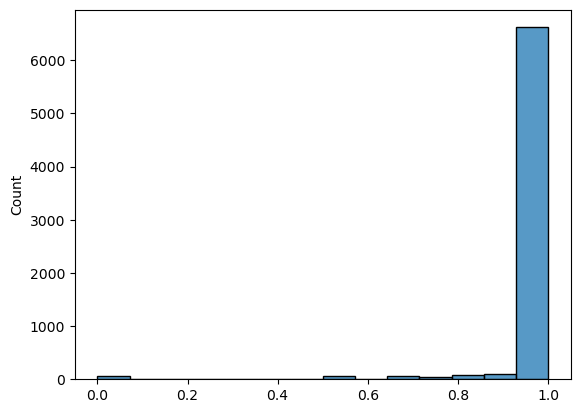

In [56]:
sns.histplot(train_prob_upvote)

In [57]:
vote_map = {'UpVote': 1, 'DownVote': 0}

In [58]:
# First, the model to predict up/down votes
# x = torch.tensor(dup_train_set, dtype=torch.float32)
# x /= torch.max(x, dim=0).values
# y = torch.tensor([vote_map[v] for v in indiv_votes])

x = np.array(train_set)
# x_cheat = np.hstack([x, np.array(train_evs).reshape((-1, 1))])
# x_cheat_n1 = np.max(x_cheat, axis=0)
# normalizer_x_cheat = np.max(np.linalg.norm(x_cheat/x_cheat_n1,axis=1))
# x_cheat_normed = (x_cheat / x_cheat_n1)/normalizer_x_cheat

n1 = np.max(x, axis=0)
normalizer_scores = np.max(np.linalg.norm(x/n1,axis=1))
# scaler_votes = StandardScaler()
scaler_votes = lambda y: (y/n1)/normalizer_scores
# scaler_votes.fit(x)
# x = scaler_votes.transform(x)
x = scaler_votes(x)
xlogreg = x
x = torch.tensor(x, dtype=torch.float32)

train_evs = []
for v in train_votes:
    votes_map = {'UpVote': 1, 'DownVote': 0}
    if len(v):
        prob_up = np.mean([votes_map[indiv_vote] for indiv_vote in v])
        train_evs.append([1-prob_up, prob_up])
    else:
        train_evs.append([.5, .5])

y = torch.tensor(train_evs, dtype=torch.float32)
ylogreg = train_evs

In [59]:
dups = []
labels = []
class_weights = []
for idx in range(xlogreg.shape[0]):
    feats, probs = xlogreg[idx, :], ylogreg[idx]
    dups.extend([feats]*2)
    labels.extend([0, 1])
    class_weights.extend(probs)

In [60]:
print(len(dups), len(labels), len(class_weights))

14090 14090 14090


In [61]:
# Train a logistic regression model directly
# from sklearn.linear_model import Ridge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures

# log_reg = make_pipeline(
#         PolynomialFeatures(degree=2, include_bias=True), LogisticRegression())
# xpoly = PolynomialFeatures(2).fit_transform(dups)

# # )
# # reg_acc.fit(x, y_acc)

# # reg_votes = make_pipeline(
# #     PolynomialFeatures(degree=1, include_bias=False), Ridge(alpha=1)
# # )
# reg_votes = LogisticRegression().fit(x, y)
log_reg = LogisticRegression()
log_reg.fit(dups, labels, class_weights)

LogisticRegression()

In [62]:
loss_fn = nn.CrossEntropyLoss()

In [63]:
constant_prediction = torch.mean(y, axis=0)
print(constant_prediction)

tensor([0.0241, 0.9759])


In [64]:
# Same for log_reg model
scaled_test = scaler_votes(np.array(test_set))
# predicted_prob_upvote_test = vote_pred_model(torch.tensor(scaled_test, dtype=torch.float32))

# scaled_test = PolynomialFeatures(2).fit_transform(scaled_test)

predicted_prob_upvote_test = torch.tensor(log_reg.predict_log_proba(scaled_test))


test_evs = []
for v in test_votes:
    votes_map = {'UpVote': 1, 'DownVote': 0}
    if len(v):
        prob_up = np.mean([votes_map[indiv_vote] for indiv_vote in v])
        test_evs.append([1-prob_up, prob_up])
    else:
        test_evs.append([.5, .5])
test_evs_tensor = torch.tensor(test_evs, dtype=torch.float32)

xe_test = loss_fn(predicted_prob_upvote_test, test_evs_tensor)

print(constant_prediction)
xe_test_constant = loss_fn(constant_prediction*torch.ones(test_evs_tensor.shape), test_evs_tensor)

print(xe_test)
print(xe_test_constant)

user_median_prob_up = np.array([x[-1] for x in test_set]).reshape((-1, 1))
llll = torch.tensor(np.hstack([1-user_median_prob_up, user_median_prob_up]))
xe_test_user_med_prob_up = loss_fn(llll, test_evs_tensor)
print(xe_test_user_med_prob_up)

tensor([0.0241, 0.9759])
tensor(0.0801, dtype=torch.float64)
tensor(0.3433)
tensor(0.3393, dtype=torch.float64)


# Create the mock conference

In [65]:
# Now we should make a "mock conference"

# Collect the users and questions
queries = set()
experts = set()

for qid in tqdm(sorted_qids):
    cd = d(questions[qid]['CreationDate'])
    
    if cd >= dev_date_cutoff and \
    int(questions[qid]['AnswerCount']) > 0 and \
    'AcceptedAnswerId' in questions[qid]:
        queries.add(qid)

        for a in question_id_to_answers[qid]:    
            # Get the user representation
            if 'OwnerUserId' in a:
                uid = a['OwnerUserId']
                if user_id_to_representation[uid][7]:
                    experts.add(uid)

  0%|          | 0/12962 [00:00<?, ?it/s]

In [66]:
# Construct the set of user representations and question representations 

In [67]:
print(len(queries), len(experts))

1402 220


In [82]:
queries = sorted(list(queries))
experts = sorted(list(experts))

In [83]:
print(queries[:10], experts[:10])

['103885', '103892', '103933', '103941', '103943', '103977', '104017', '104037', '104069', '104081'] ['101527', '101890', '102183', '105695', '105948', '107966', '109116', '1100', '11135', '11222']


In [84]:
# # # Create the matrix of scores using the features and predictive model
# asst_scores = np.zeros((len(experts), len(queries)))
# preds_score = np.zeros((len(experts), len(queries)))

# non_pred_scores = np.zeros((len(experts), len(queries)))
# non_pred_weights = np.array([.5, .5])
# user_rep_scores = np.zeros((len(experts), len(queries)))
# kp_matching_scores = np.zeros((len(experts), len(queries)))

# print(asst_scores.shape)

# pair_to_feats = {}

# for qidx, qid in enumerate(tqdm(queries)):
#     q = questions[qid]
# #     q_embs = qid_to_embs[qid]
#     q_tags = q['Tags'][1:-1].split("><")
#     q_embs = get_kp_embs(q_tags)

#     answer_feats = []
#     manual_scores = []

#     for u_idx, uid in enumerate(experts):    
#         # Get the user representation
#         user_rep = user_id_to_representation[uid]
#         af = user_rep[:4]
#         af.append(match_tags(user_rep[5], q_tags))
#         # Compute the average time taken to answer questions, MRR for prev ans, avg views of prev q's, 
#         # and avg score of prev q's
#         for feat_idx in range(8, 12):
#             af.append(np.mean(np.array(user_rep[feat_idx])))

#         # Add the smoothed fraction of best answers
#         af.append(user_rep[12]/(len(user_rep[11]) + smooth_param))

#         # Add the average usefulness, relevance, and informativeness of past answers
#         qa_pairs = list(zip(user_rep[13], user_rep[14]))
#         usefulness_scores = [use_map[p] for p in qa_pairs]
#         relevance_scores = [rel_map[p] for p in qa_pairs]
#         informativeness_scores = [inf_map[p] for p in qa_pairs]

#         af.append(np.mean(usefulness_scores))
#         af.append(np.mean(informativeness_scores))
#         af.append(np.mean(relevance_scores))

#         # Add the avg and max similarity of this title to titles that they have previously answered
#         cos_sims = util.cos_sim(title_embs[qid_to_title_idx[qid]], 
#                                 np.vstack([title_embs[qid_to_title_idx[oqid]] for oqid in user_rep[13]])).detach().numpy()
#         af.append(np.mean(cos_sims))
#         af.append(np.max(cos_sims))

#         # Add the avg and max similarity of the question body to the body of their previous answers
#         cos_sims = util.cos_sim(body_embs[pid_to_emb_idx[qid]], 
#                                 np.vstack([body_embs[pid_to_emb_idx[opid]] for opid in user_rep[14]])).detach().numpy()
#         af.append(np.mean(cos_sims))
#         af.append(np.max(cos_sims))

#         # Add the min, 25th percentile, median, 75th percentile, and max of the probabilities of upvotes 
#         # on the user's past answers
#         votes_map = {'UpVote': 1, 'DownVote': 0}

#         prob_uv = []
#         for past_aid in user_rep[14]:
#             vlist = id_to_votelist[past_aid]
#             if len(vlist):
#                 prob_up = np.mean([votes_map[indiv_vote] for indiv_vote in vlist])
#                 prob_uv.append(prob_up)

#         if len(prob_uv):
#             af.extend([np.percentile(prob_uv, perc) for perc in [0, 5, 10, 25, 50]])
#         else:
#             af.extend([.5, .5, .5, .5, .5])

#         answer_feats.append(af)

#         # Now just collect the reputation and the keyword matching to use as a baseline
#         user_rep_scores[u_idx, qidx] = user_rep[0]
#         kp_matching_scores[u_idx, qidx] = af[4]
#         pair_to_feats[u_idx, qidx] = af

# #     dev_x_feats = scaler_votes(np.array(dev_set)[:, feat_idxs])
# #     test_x_feats = scaler_votes(np.array(test_set)[:, feat_idxs])

# #     # Set up the model
# #     log_reg = LogisticRegression()
# #     log_reg.fit(dups, labels, class_weights)

# #     # Compute the dev and test XE
# #     predicted_prob_upvote_dev = torch.tensor(log_reg.predict_log_proba(dev_x_feats))
# #     predicted_prob_upvote_test = torch.tensor(log_reg.predict_log_proba(test_x_feats))

# #     xe_dev = loss_fn(predicted_prob_upvote_dev, dev_evs)
# #     xe_test = loss_fn(predicted_prob_upvote_test, test_evs)

#     ts = scaler_votes(np.array(answer_feats))
# #     predicted_scores = torch.softmax(vote_pred_model(torch.tensor(ts, dtype=torch.float32)), axis=1).detach().numpy()[:, 1]
#     predicted_scores = log_reg.predict_proba(ts)[:, 1]

#     preds_score[:, qidx] = predicted_scores
#     asst_scores[:, qidx] = preds_score[:, qidx]

(220, 1402)


  0%|          | 0/1402 [00:00<?, ?it/s]

In [85]:
# np.save(os.path.join(data_dir, 'preds_score.npy'), preds_score)
# np.save(os.path.join(data_dir, 'asst_scores.npy'), asst_scores)

# with open(os.path.join(data_dir, 'pair_to_feats.pkl'), 'wb') as f:
#     pickle.dump(pair_to_feats, f)
preds_score = np.load(os.path.join(data_dir, 'preds_score.npy'))
asst_scores = np.load(os.path.join(data_dir, 'asst_scores.npy'))

with open(os.path.join(data_dir, 'pair_to_feats.pkl'), 'rb') as f:
    pair_to_feats = pickle.load(f)

In [72]:
preds_score

array([[0.95959739, 0.95989478, 0.96072294, ..., 0.95787568, 0.9594454 ,
        0.96070889],
       [0.98477107, 0.98545248, 0.98501827, ..., 0.98549521, 0.98557973,
        0.98607311],
       [0.96705607, 0.96694651, 0.9649514 , ..., 0.96528469, 0.96808345,
        0.96772801],
       ...,
       [0.98558125, 0.98616249, 0.985705  , ..., 0.98622993, 0.98565682,
        0.98646025],
       [0.87829568, 0.88283921, 0.87574561, ..., 0.88680954, 0.88478863,
        0.87133377],
       [0.96221974, 0.96572914, 0.96050069, ..., 0.96149373, 0.96152637,
        0.96361894]])

<Axes: ylabel='Count'>

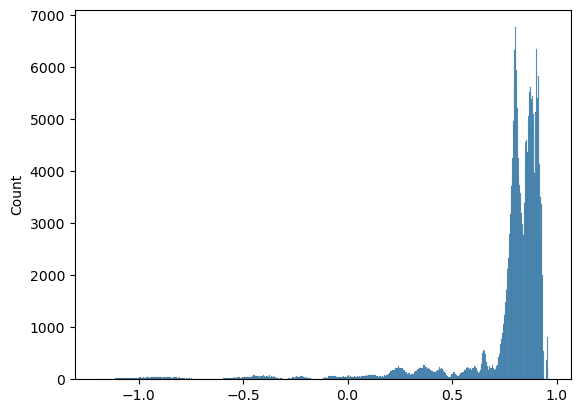

In [73]:
sns.histplot(asst_scores.flatten())

In [79]:
# asst_scores = 6*asst_scores - 5

In [73]:
# rng = np.random.default_rng(seed=0)
# num_e, num_q = asst_scores.shape
# frac = .1
# # chosen_experts = rng.choice(range(num_e), size=int(frac*num_e), replace=False)
# # chosen_queries = rng.choice(range(num_q), size=int(frac*num_q), replace=False)
# chosen_experts = list(range(len(experts)))
# chosen_queries = list(range(len(queries)))


In [75]:
# small_asst_scores = asst_scores[chosen_experts, :]
# small_asst_scores = small_asst_scores[:, chosen_queries]
# small_pred_scores = preds_score[chosen_experts, :]
# small_pred_scores = small_pred_scores[:, chosen_queries]

In [87]:
# Now we should try to assign based on these queries and experts
cov = 2
load = 13

covs = np.ones(len(queries))*cov
loads = np.ones(len(experts))*load

In [77]:
# Now let's start by implementing the CVaR formulation of USW

In [154]:
num_samples = 10
vote_samples = [rng.uniform(size=preds_score.shape) < preds_score for _ in range(num_samples)]
vote_samples = [6*vs - 5 for vs in vote_samples]

In [ ]:
alloc = cp.Variable(preds_score.shape, boolean=True)
alpha = cp.Variable()
beta = .9
# Beta is the cvar level for the RISK. So at .99, that means we are minimizing the conditional expectation 
# of the highest 1% of RISK scores, or rather, maximizing the CE of the lowest 1% of GAIN scores.

flat_alloc = cp.reshape(alloc, (1, alloc.size))
flat_vote_samples = [cp.reshape(vs, (vs.size, 1)) for vs in vote_samples]
inner_prods = [flat_alloc @ vs for vs in flat_vote_samples]
summands = [cp.pos(-1*ip - alpha) for ip in inner_prods]
obj = cp.sum(summands)
obj = alpha + obj/(num_samples*(1-beta))

cvar_usw_problem = cp.Problem(cp.Minimize(obj), [cp.sum(alloc, axis=0) == covs, cp.sum(alloc, axis=1) <= loads])

cvar_usw_problem.solve(verbose=True, solver='GUROBI')

                                     CVXPY                                     
                                     v1.3.2                                    
(CVXPY) May 03 03:54:38 PM: Your problem has 308441 variables, 2 constraints, and 0 parameters.
(CVXPY) May 03 03:54:38 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) May 03 03:54:38 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) May 03 03:54:38 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) May 03 03:54:38 PM: Compiling problem (target solver=GUROBI).
(CVXPY) May 03 03:54:38 PM: Reduction chain: CvxAttr2Constr -> Qp2SymbolicQp -> QpMatrixSt

In [ ]:
print(alpha.value)

In [ ]:
print(alloc.value)

In [ ]:
vote_samples = [rng.uniform(size=preds_score.shape) < preds_score for _ in range(num_samples)]
vote_samples = [6*vs - 5 for vs in vote_samples]
welfares = [np.sum(alloc.value*vs) for vs in vote_samples]

In [ ]:
welfares

In [133]:
import sys
sys.path.append("../../../../../PycharmProjects/RAU")
from solve_usw import solve_usw_gurobi

In [135]:
est_usw, alloc_max_usw = solve_usw_gurobi(asst_scores, covs, loads)

Total demand: 2804
Number of revs: 220
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: Intel(R) Core(TM) i5-10300H CPU @ 2.50GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 1622 rows, 308440 columns and 616880 nonzeros
Model fingerprint: 0x816cd044
Variable types: 0 continuous, 308440 integer (308440 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e-05, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [2e+00, 1e+01]
Found heuristic solution: objective 2096.0859348
Presolve time: 0.69s
Presolved: 1622 rows, 308440 columns, 616880 nonzeros
Variable types: 0 continuous, 308440 integer (308440 binary)
Found heuristic solution: objective 2120.9583578
Deterministic concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Root barrier log...

Ordering time: 0.01s

Barrier statistics:
 AA' NZ     : 

In [145]:
welfares_usw_alloc = [np.sum(alloc_max_usw*vs) for vs in vote_samples]

In [146]:
welfares_usw_alloc

[2240.0,
 2186.0,
 2258.0,
 2366.0,
 2234.0,
 2234.0,
 2318.0,
 2252.0,
 2282.0,
 2240.0]

In [88]:
# Now reimplement with Elita's formulation

In [89]:
# alloc = cp.Variable(small_pred_scores.shape, boolean=True)
# y = cp.Variable(num_samples)
# b = cp.Variable()
# alpha = .1 # We set this to be 1-beta from above, perhaps somewhat confusing but that's what it is right now.

# obj = b - (1/(alpha*num_samples)*cp.sum(y)

# constr = [cp.sum(alloc, axis=0) == covs, cp.sum(alloc, axis=1) <= loads,
#                                                 y >= 0]
# flat_alloc = cp.reshape(alloc, (1, alloc.size))
# flat_vote_samples = [cp.reshape(vs, (vs.size, 1)) for vs in vote_samples]
# inner_prods = cp.hstack([flat_alloc @ vs for vs in flat_vote_samples])

# constr.append(y >= cp.multiply(p_V, b - cp.reshape(inner_prods, (inner_prods.size))))

# cvar_usw_problem = cp.Problem(cp.Maximize(obj), constr)

# cvar_usw_problem.solve(verbose=True, solver='GUROBI', reoptimize=True)

In [90]:
# alloc.value

In [91]:
# Now do with GESW (first, we need to define groups for the questions)

In [88]:
# Cluster the tags, then fit each question into the cluster that the majority of its tags fall in
# query_ids = [queries[i] for i in chosen_queries]
all_tags = set()

for qid in queries:
    tags = questions[qid]['Tags'][1:-1].split("><")
    all_tags |= set(tags)

In [89]:
all_tag_list = list(all_tags)

In [90]:
tag_embs = model.encode(all_tag_list)

In [91]:
tag_embs.shape

(441, 768)

In [156]:
km = KMeans(n_clusters=5)

In [157]:
km.fit(tag_embs)

KMeans(n_clusters=5)

In [158]:
km.labels_

array([2, 0, 2, 2, 3, 3, 1, 3, 3, 3, 1, 2, 3, 4, 2, 3, 1, 1, 0, 3, 2, 3,
       3, 1, 1, 2, 4, 3, 0, 3, 3, 2, 1, 2, 2, 2, 2, 3, 4, 2, 2, 3, 0, 3,
       3, 1, 2, 2, 3, 0, 2, 3, 3, 2, 2, 1, 3, 3, 2, 2, 2, 2, 2, 3, 1, 1,
       1, 0, 0, 0, 2, 2, 3, 3, 2, 3, 2, 3, 2, 4, 3, 4, 0, 3, 2, 0, 4, 0,
       4, 3, 2, 1, 1, 2, 1, 0, 2, 0, 2, 2, 1, 2, 3, 3, 2, 1, 0, 2, 1, 3,
       1, 0, 3, 1, 4, 2, 4, 1, 2, 2, 3, 3, 4, 1, 1, 4, 0, 4, 3, 3, 1, 3,
       3, 3, 1, 3, 3, 3, 2, 2, 0, 2, 1, 3, 1, 1, 4, 2, 3, 0, 2, 4, 3, 2,
       3, 3, 3, 3, 2, 2, 1, 0, 4, 2, 1, 2, 2, 0, 0, 2, 3, 3, 3, 3, 3, 2,
       1, 1, 3, 1, 3, 3, 2, 3, 3, 2, 3, 1, 3, 3, 2, 0, 2, 2, 4, 3, 0, 1,
       4, 2, 3, 1, 2, 1, 0, 4, 2, 3, 2, 4, 3, 0, 2, 2, 3, 2, 2, 1, 2, 3,
       0, 1, 2, 3, 0, 1, 2, 3, 3, 2, 2, 2, 1, 3, 3, 2, 0, 3, 2, 1, 2, 2,
       2, 2, 2, 3, 3, 1, 2, 1, 2, 3, 1, 1, 4, 2, 0, 3, 1, 2, 1, 1, 2, 1,
       4, 0, 1, 3, 0, 3, 3, 4, 2, 1, 2, 3, 1, 0, 0, 2, 4, 0, 1, 1, 3, 4,
       3, 1, 0, 3, 1, 3, 2, 1, 1, 4, 2, 2, 2, 1, 2,

In [164]:
idx = 4
l = []
for kp, grp_label in zip(all_tag_list, km.labels_):
    if grp_label == idx:
        l.append(kp)
print(sorted(l))

['busy-beaver', 'clocks', 'coin-change', 'colorings', 'combinatorics', 'concurrency', 'counting', 'dynamic-array', 'entropy', 'enumeration', 'integer-partitions', 'knapsack-problems', 'monte-carlo', 'nondeterminism', 'permutations', 'probabilistic-algorithms', 'probabilistic-turing-machines', 'probability-theory', 'process-scheduling', 'pseudo-random-generators', 'pseudocode', 'quicksort', 'random-graphs', 'random-number-generator', 'random-walks', 'randomized', 'randomized-algorithms', 'randomness', 'reliability', 'sampling', 'scheduling', 'simulated-annealing', 'simulation', 'sorting', 'statistics', 'word-combinatorics']


In [165]:
# Fit each question into the cluster that the majority of its tags fall in
# chosen_query_ids = [queries[i] for i in chosen_queries]

subject_area_group = []

for qid in queries:
    tags = questions[qid]['Tags'][1:-1].split("><")
    tag_groups = []
    for t in tags:
        tag_groups.append(km.labels_[all_tag_list.index(t)])
    top_group = sorted(Counter(tag_groups).items(), key=lambda x: x[1])[-1][0]
    subject_area_group.append(top_group)
#     print(questions[qid])
#     if 'OwnerUserId' in questions[qid]:
#         owner = questions[qid]['OwnerUserId']
#         user_rep = user_id_to_representation[owner][0]
#         user_reps.append(user_rep)
#     else:
#         user_reps.append(0)

In [166]:
Counter(subject_area_group)

Counter({2: 479, 1: 265, 0: 155, 3: 400, 4: 103})

In [167]:
groups = subject_area_group

In [121]:
# Seems like <100, 100-500, 500-1000, 1000+ are good groupings.
# groups = []
# group_thresh = [100, 500, 1000]
# for u in user_reps:
#     for idx, gt in enumerate(group_thresh):
#         if u < gt:
#             groups.append(idx)
#             break
#     if u > group_thresh[-1]:
#         groups.append(len(group_thresh))

In [168]:
groups

[2,
 2,
 2,
 1,
 0,
 2,
 3,
 2,
 2,
 2,
 2,
 2,
 2,
 1,
 2,
 2,
 3,
 3,
 3,
 2,
 1,
 1,
 2,
 0,
 4,
 3,
 0,
 2,
 1,
 0,
 3,
 2,
 2,
 1,
 1,
 3,
 2,
 2,
 4,
 2,
 1,
 4,
 3,
 4,
 3,
 2,
 0,
 1,
 2,
 1,
 1,
 4,
 1,
 1,
 3,
 1,
 2,
 3,
 3,
 3,
 4,
 1,
 1,
 1,
 4,
 1,
 2,
 3,
 3,
 3,
 3,
 2,
 3,
 4,
 4,
 2,
 2,
 0,
 2,
 2,
 2,
 2,
 1,
 2,
 2,
 1,
 3,
 2,
 0,
 0,
 1,
 2,
 3,
 0,
 2,
 1,
 1,
 2,
 0,
 4,
 1,
 1,
 1,
 2,
 1,
 0,
 3,
 2,
 3,
 0,
 2,
 1,
 2,
 1,
 3,
 2,
 4,
 3,
 2,
 4,
 3,
 2,
 3,
 2,
 3,
 1,
 2,
 1,
 0,
 2,
 3,
 3,
 1,
 3,
 3,
 0,
 3,
 2,
 3,
 0,
 3,
 3,
 0,
 3,
 1,
 3,
 2,
 2,
 2,
 0,
 2,
 3,
 4,
 1,
 4,
 3,
 4,
 2,
 3,
 2,
 1,
 3,
 4,
 3,
 2,
 3,
 4,
 1,
 2,
 3,
 3,
 1,
 2,
 2,
 0,
 2,
 0,
 2,
 2,
 3,
 2,
 3,
 1,
 3,
 0,
 2,
 1,
 0,
 3,
 3,
 2,
 3,
 2,
 1,
 3,
 3,
 2,
 3,
 2,
 1,
 2,
 4,
 1,
 1,
 2,
 1,
 1,
 4,
 3,
 2,
 0,
 3,
 2,
 4,
 4,
 3,
 2,
 3,
 1,
 2,
 2,
 1,
 2,
 2,
 2,
 2,
 4,
 2,
 1,
 0,
 3,
 2,
 3,
 4,
 4,
 2,
 2,
 3,
 0,
 2,
 2,
 0,
 2,
 2,
 3,
 1,
 4,
 4,
 3,
 2,


In [169]:
np.save(os.path.join(data_dir, "groups.npy"), groups)

In [170]:
len(groups)

1402

In [171]:
# Also set COI matrix, that says you can only be assigned to things with at least 1 tag in common
# chosen_query_ids = [queries[i] for i in chosen_queries]
# chosen_expert_ids = [experts[i] for i in chosen_experts]

coi_mask = np.ones(asst_scores.shape)

for qidx, qid in enumerate(queries):
    tags = questions[qid]['Tags'][1:-1].split("><")
    for uidx, uid in enumerate(experts):
        utags = user_id_to_representation[uid][4]
        coi_mask[uidx, qidx] = int(len(set(utags) & set(tags)) > 0)

In [172]:
data_dir

'../../StackExchange/data\\cs.stackexchange.com'

In [173]:
np.save("../data/cs/coi_mask.npy", coi_mask)

In [ ]:
# np.save("tmp_dset/groups.npy", np.array(groups))

In [174]:
num_groups = len(set(groups))
group_indicators = []
group_size = Counter(groups)
for g in range(num_groups):
    group_indicators.append(np.zeros(asst_scores.shape))
for idx, g in enumerate(groups):
    group_indicators[g][:, idx] = 1/group_size[g]
group_indicators = [cp.reshape(gi, (gi.size, 1)) for gi in group_indicators]

In [97]:
# # Now implement the optimization problem using the groups
# gesw_alloc = cp.Variable(small_pred_scores.shape, boolean=True)
# alpha = cp.Variable()
# beta = .9
# # Beta is the cvar level for the RISK. So at .99, that means we are minimizing the conditional expectation 
# # of the highest 1% of RISK scores, or rather, maximizing the CE of the lowest 1% of GAIN scores.

# flat_alloc = cp.reshape(gesw_alloc, (1, gesw_alloc.size))
# flat_alloc_per_group = [cp.multiply(flat_alloc, gi) for gi in group_indicators]
# flat_vote_samples = [cp.reshape(vs, (vs.size, 1)) for vs in vote_samples]
# inner_prods_per_group = [cp.hstack([apg @ vs for apg in flat_alloc_per_group]) for vs in flat_vote_samples]
# egalitarian_welfares = [cp.min(ip_list) for ip_list in inner_prods_per_group]
# summands = [cp.pos(-1*ew - alpha) for ew in egalitarian_welfares]
# obj = cp.sum(summands)
# obj = alpha + obj/(num_samples*(1-beta))

# cvar_gesw_problem = cp.Problem(cp.Minimize(obj), [cp.sum(gesw_alloc, axis=0) == covs, cp.sum(gesw_alloc, axis=1) <= loads])

# cvar_gesw_problem.solve(verbose=True, solver='GUROBI')

In [102]:
# pickle.dump(vote_samples, open('tmp_dset/vote_samples.pkl', 'wb'))

In [98]:
# num_groups = 4
# group_indicators = []
# group_size = Counter(groups)
# for g in range(num_groups):
#     group_indicators.append(np.zeros(small_pred_scores.shape))
# for idx, g in enumerate(groups):
#     group_indicators[g][:, idx] = 1/group_size[g]
# group_indicators = [cp.reshape(gi, (gi.size, 1)) for gi in group_indicators]

num_samples = len(vote_samples)
gesw_alloc = cp.Variable(small_pred_scores.shape, boolean=True)
alpha = cp.Variable()
beta = .9
y = cp.Variable((num_samples, 1))

# Beta is the cvar level for the RISK. So at .99, that means we are minimizing the conditional expectation 
# of the highest 1% of RISK scores, or rather, maximizing the CE of the lowest 1% of GAIN scores.

flat_alloc = cp.reshape(gesw_alloc, (gesw_alloc.size, 1))

groups_stacked = cp.hstack(group_indicators)
flat_alloc_per_group = cp.multiply(flat_alloc, groups_stacked)
flat_vote_samples = cp.vstack([cp.reshape(vs, (1, vs.size)) for vs in vote_samples])

inner_prods_per_group = flat_vote_samples @ flat_alloc_per_group # (num_samples x mn) @ (mn x num_groups) = (num_samples x num_groups)

obj = cp.sum(y)
obj = alpha + obj/(num_samples*(1-beta))

constr = [cp.sum(gesw_alloc, axis=0) == covs, cp.sum(gesw_alloc, axis=1) <= loads]
constr.append(y >= 0)

constr.append(y >= -1*inner_prods_per_group - alpha)

cvar_gesw_problem = cp.Problem(cp.Minimize(obj), constr)

cvar_gesw_problem.solve(verbose=True, solver='GUROBI')

                                     CVXPY                                     
                                     v1.3.2                                    
(CVXPY) Apr 19 01:30:30 PM: Your problem has 3091 variables, 4 constraints, and 0 parameters.
(CVXPY) Apr 19 01:30:30 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Apr 19 01:30:30 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Apr 19 01:30:30 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Apr 19 01:30:30 PM: Compiling problem (target solver=GUROBI).
(CVXPY) Apr 19 01:30:30 PM: Reduction chain: CvxAttr2Constr -> Qp2SymbolicQp -> QpMatrixStuf

-2.0

In [116]:
# Compute the GESW of this allocation on all samples, vs. the naive GESW approach on the expected values
def compute_gesw(alloc, groups, sample_val):
    num_groups = len(set(groups))
    group_indicators = []
    group_size = Counter(groups)
    for g in range(num_groups):
        group_indicators.append(np.zeros(sample_val.shape))
    for idx, g in enumerate(groups):
        group_indicators[g][:, idx] = 1/group_size[g]
    welfares = [np.sum(gi*alloc*sample_val) for gi in group_indicators]
    print(welfares)
    return min(welfares)

In [100]:
# gesws = []
# for vs in vote_samples:
#     gesws.append(compute_gesw(gesw_alloc.value, groups, vs))

In [101]:
# print(gesws)

In [102]:
# usw_gesws = []
# for vs in vote_samples:
#     usw_gesws.append(compute_gesw(alloc_max_usw, groups, vs))

In [103]:
# usw_gesws

In [114]:
# # Compare against max egalitarian for just the expected values
max_gesw_expected_alloc = cp.Variable(asst_scores.shape, boolean=True)
y = cp.Variable()

flat_alloc = cp.reshape(max_gesw_expected_alloc, (max_gesw_expected_alloc.size, 1))
groups_stacked = cp.hstack(group_indicators)
flat_alloc_per_group = cp.multiply(flat_alloc, groups_stacked)
coeffs = cp.reshape(asst_scores, (1, asst_scores.size))
inner_prods_per_group = coeffs @ flat_alloc_per_group
obj = y

constr = [cp.sum(max_gesw_expected_alloc, axis=0) == covs, cp.sum(max_gesw_expected_alloc, axis=1) <= loads]
constr.append(y >= 0)

constr.append(y <= inner_prods_per_group)

cvar_gesw_problem = cp.Problem(cp.Maximize(obj), constr)

cvar_gesw_problem.solve(verbose=True, solver='GUROBI')

                                     CVXPY                                     
                                     v1.3.2                                    
(CVXPY) May 03 02:18:24 PM: Your problem has 308441 variables, 4 constraints, and 0 parameters.
(CVXPY) May 03 02:18:24 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) May 03 02:18:24 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) May 03 02:18:24 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) May 03 02:18:24 PM: Compiling problem (target solver=GUROBI).
(CVXPY) May 03 02:18:24 PM: Reduction chain: FlipObjective -> CvxAttr2Constr -> Qp2Symboli

1.6067467728819704

In [115]:
max_gesw_expected_alloc.value

array([[-0., -0., -0., ..., -0., -0., -0.],
       [-0., -0., -0., ..., -0., -0., -0.],
       [-0., -0., -0., ..., -0., -0., -0.],
       ...,
       [-0., -0., -0., ..., -0., -0., -0.],
       [-0., -0., -0., ..., -0., -0., -0.],
       [-0., -0., -0., ..., -0., -0., -0.]])

In [117]:
compute_gesw(max_gesw_expected_alloc.value, groups, asst_scores)

[1.6069226025641838, 1.6068197030661884, 1.606930468666562, 1.6067467728819707]


1.6067467728819707

In [106]:
# expected_alloc_gesws = []
# for vs in vote_samples:
#     expected_alloc_gesws.append(compute_gesw(max_gesw_expected_alloc.value, groups, vs))

In [107]:
# expected_alloc_gesws

In [108]:
# usw_gesws

In [109]:
# Now the robust USW objective, which we mostly have anyway.

# First, need to compute the uncertainty set.

In [175]:
# For the uncertainty set, we will actually compute the logistic regression loss on the test set for each group separately, 
# which will give us per-group bounds. 
groups = np.load(os.path.join(data_dir, "groups.npy"))
print(test_post_ids[:10])
print(groups[:10])

['103893', '103894', '104003', '103953', '103963', '103966', '103980', '104001', '104027', '104054']
[2 2 2 1 0 2 3 2 2 2]


In [176]:
grouped_test_set = []
grouped_test_evs = []

for _ in range(len(Counter(groups))):
    grouped_test_set.append([])
    grouped_test_evs.append([])
            
for pid, test_instance, v in zip(test_post_ids, test_set, test_votes):
    qid = pid_to_qid[pid]
    if qid in queries:
        grp = groups[queries.index(qid)]
        grouped_test_set[grp].append(test_instance)
        
        votes_map = {'UpVote': 1, 'DownVote': 0}
        if len(v):
            prob_up = np.mean([votes_map[indiv_vote] for indiv_vote in v])
            grouped_test_evs[grp].append([1-prob_up, prob_up])
        else:
            grouped_test_evs[grp].append([.5, .5])

In [177]:
print([len(x) for x in grouped_test_set])
print([len(x) for x in grouped_test_evs])

[165, 352, 564, 463, 122]
[165, 352, 564, 463, 122]


In [178]:
xis = []

for ts, evs in zip(grouped_test_set, grouped_test_evs):
    scaled_test = scaler_votes(np.array(ts))
    predicted_prob_upvote_test = torch.tensor(log_reg.predict_log_proba(scaled_test))

    test_evs_tensor = torch.tensor(evs, dtype=torch.float32)

    xe_test = loss_fn(predicted_prob_upvote_test, test_evs_tensor)
    xis.append(xe_test.item())

In [179]:
xis

[0.07588882484092192,
 0.15023608404293937,
 0.05881603913182105,
 0.05840051657072555,
 0.06480780103910307]

In [180]:
c_values = []
for gidx in range(len(grouped_test_set)):
    print(gidx)
    c_values.append(coi_mask[:, np.where(groups==gidx)[0]].sum())

0
1
2
3
4


In [181]:
c_values

[13844.0, 21440.0, 30540.0, 32633.0, 7902.0]

In [182]:
t_values = [len(x) for x in grouped_test_evs]

In [183]:
t_values

[165, 352, 564, 463, 122]

In [184]:
# Gamma is a realistic upper bound on the maximum cross-entropy loss for any 1 pair
# You can get this using Cauchy-Schwartz on the weights of the model and the x values (1), and then push through sigmoid 
# and cross entropy loss
# print()
max_pred = expit(np.linalg.norm(log_reg.coef_))
min_pred = expit(-np.linalg.norm(log_reg.coef_))
print(min_pred, max_pred)

gamma = 0
for pred in [max_pred, min_pred]:
    worst_p = cp.Variable()
    obj = -cp.log(pred)*worst_p - cp.log(1-pred)*(1-worst_p)
    constr = [worst_p <= 1, worst_p >= 0]
    max_xe = cp.Problem(cp.Maximize(obj), constr)

    max_xe.solve(solver='GUROBI')
    print(obj.value, worst_p.value)
    gamma = max([gamma, obj.value])
    
print(gamma)

0.002511623783898449 0.9974883762161015
5.986825809148809 0.0
5.986825809148815 1.0
5.986825809148815


In [185]:
grouped_etas_by_delta = {}
n_groups = len(t_values)
for delta in [.3, .2, .1, .05]:
    grouped_etas_by_delta[delta] = [(.5*(gamma**2))*np.log(n_groups/(delta))*(1/t + 1/c) for t,c in zip(t_values, c_values)]

In [186]:
grouped_etas_by_delta

{0.3: [0.3092131725447901,
  0.14558815150898932,
  0.09104675941536226,
  0.1104419083076484,
  0.41965311410601686],
 0.2: [0.35377657442829663,
  0.16657012731479737,
  0.10416830044359905,
  0.1263586530704615,
  0.4801329773073899],
 0.1: [0.4299582131291838,
  0.20243905186968927,
  0.12659972299130123,
  0.1535685079640497,
  0.5835239863495285],
 0.05: [0.506139851830071,
  0.23830797642458118,
  0.1490311455390034,
  0.1807783628576379,
  0.6869149953916672]}

In [187]:
xis

[0.07588882484092192,
 0.15023608404293937,
 0.05881603913182105,
 0.05840051657072555,
 0.06480780103910307]

In [208]:
# Compare to just estimating the mean and standard deviation of the loss on the dev set empirically and using normal
delta_to_normal_bd = {}

nonaggloss = nn.CrossEntropyLoss(reduction='none')

means = []
stds = []

for ts, evs in zip(grouped_test_set, grouped_test_evs):
    scaled_test = scaler_votes(np.array(ts))
    predicted_prob_upvote_test = torch.tensor(log_reg.predict_log_proba(scaled_test))

    test_evs_tensor = torch.tensor(evs, dtype=torch.float32)

#     print(torch.softmax(predicted_prob_upvote_test,axis=1))
#     print(test_evs_tensor)
    xe_test = nonaggloss(predicted_prob_upvote_test, test_evs_tensor)
    xe_test = xe_test.detach().cpu().numpy()
#     print(xe_test)
    mean, std = np.mean(xe_test), np.std(xe_test)
    print(mean, std)
    means.append(mean)
    stds.append(std)
    
n_groups = len(grouped_test_set)

import scipy
for delta in [.3, .2, .1, .05]:
    delta_to_normal_bd[delta] = []
    for gidx in range(n_groups):
        ub = scipy.stats.norm.interval(1-2*(delta/n_groups), loc=means[gidx], scale=stds[gidx]/np.sqrt(t_values[gidx]))[1]
        print(ub)
        delta_to_normal_bd[delta].append(ub)
    print()
#     xis.append(xe_test.item())

0.07588882484092194 0.3399147562624188
0.15023608404293934 0.4709175970893767
0.05881603913182106 0.1997871279005667
0.05840051657072554 0.21819998184465095
0.06480780103910307 0.16154345601890127
0.11703175348889466
0.1892608892348956
0.07189565856350409
0.07416687410373199
0.08754707587197452

0.1222160536830122
0.19417829088277333
0.07354378318143887
0.07615354673752173
0.09041238543558908

0.1302358019085937
0.2017851658057931
0.07609331619174123
0.07922678974681446
0.0948448180548678

0.13744940505957642
0.20862739767771046
0.07838657014926406
0.0819911103753417
0.09883170255667259



In [209]:
delta_to_normal_bd

{0.3: [0.11703175348889466,
  0.1892608892348956,
  0.07189565856350409,
  0.07416687410373199,
  0.08754707587197452],
 0.2: [0.1222160536830122,
  0.19417829088277333,
  0.07354378318143887,
  0.07615354673752173,
  0.09041238543558908],
 0.1: [0.1302358019085937,
  0.2017851658057931,
  0.07609331619174123,
  0.07922678974681446,
  0.0948448180548678],
 0.05: [0.13744940505957642,
  0.20862739767771046,
  0.07838657014926406,
  0.0819911103753417,
  0.09883170255667259]}

In [210]:
pickle.dump(delta_to_normal_bd, open(os.path.join("../data/cs", "delta_to_normal_bd.pkl"), 'wb'))

In [215]:
np.round(.049999900001, decimals=2)

0.05

In [110]:
def est_dens_ratio(input_vects, reference_vects):
    pca_ref = PCA(n_components=2).fit(reference_vects)
    kde_ref = KernelDensity().fit(pca_ref.transform(reference_vects))

    pca = PCA(n_components=2).fit_transform(input_vects)
    kde = KernelDensity().fit(pca)
    log_density = kde.score_samples(pca)

    probs = np.exp(log_density)
    log_density_input_by_ref = kde_ref.score_samples(pca_ref.transform(input_vects))
    probs_input_by_ref = np.exp(log_density_input_by_ref)
    return probs/probs_input_by_ref

In [111]:
# Subsample the test set
chosen_query_ids = {queries[i] for i in chosen_queries}
chosen_expert_ids = {experts[i] for i in chosen_experts}

pid_to_uid = {}

for p in posts:
    if 'OwnerUserId' in p:
        pid_to_uid[p['Id']] = p['OwnerUserId']

test_evs = []
for v in test_votes:
    votes_map = {'UpVote': 1, 'DownVote': 0}
    if len(v):
        prob_up = np.mean([votes_map[indiv_vote] for indiv_vote in v])
        test_evs.append([1-prob_up, prob_up])
    else:
        test_evs.append([.5, .5])
# test_evs_tensor = torch.tensor(test_evs, dtype=torch.float32)


limited_test_set = []
limited_test_evs = []
for i in range(len(test_set)):
    post_id, test_instance, test_ev = test_post_ids[i], test_set[i], test_evs[i]
    if pid_to_qid[post_id] in chosen_query_ids and post_id in pid_to_uid and pid_to_uid[post_id] in chosen_expert_ids:
        limited_test_set.append(test_instance)
        limited_test_evs.append(test_ev)

In [112]:
print(len(limited_test_set), len(limited_test_evs))

11 11


In [113]:
print(len(chosen_queries), len(chosen_experts))

140 22


In [114]:
train_x = np.array(train_set)
# test_x = np.array(limited_test_set)
test_x = test_set

all_x = np.vstack([train_x, test_x])
scaled_all_x = scaler_votes(all_x)
scaled_test = scaler_votes(test_x)

collection_all = []
coi = np.zeros((len(chosen_experts), len(chosen_queries)))
for e, q in tqdm(product(range(len(chosen_experts)), range(len(chosen_queries)))):
    collection_all.append(pair_to_feats[(e, q)])
    if pair_to_feats[(e, q)][4] <= 0:
        coi[e, q] = 1
l = np.array(collection_all)
normalizer1 = np.max(l, axis=0)
l /= normalizer1
normalizer = np.max(np.linalg.norm(l, axis=1))
l /= normalizer

dr_all = est_dens_ratio(l, scaled_test)

0it [00:00, ?it/s]

In [115]:
pair_to_feats

{(0, 0): [592,
  46,
  45,
  11,
  0,
  309691577.227,
  0.25,
  5679.0,
  12.0,
  0.0,
  3.0,
  4.0,
  4.0,
  -0.110020846,
  -0.110020846,
  0.029427757,
  0.029427757,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0],
 (1, 0): [2214,
  122,
  28,
  0,
  1,
  22883762.067700006,
  0.95,
  612.2,
  5.1,
  0.45,
  3.3,
  4.0,
  4.0,
  0.064857885,
  0.12819377,
  0.06953431,
  0.16341823,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0],
 (2, 0): [824,
  35,
  9,
  4,
  0,
  133979.25400012732,
  0.2648809523809524,
  25863.25,
  75.75,
  0.07142857142857142,
  3.5,
  4.0,
  4.25,
  0.14865384,
  0.19922748,
  0.1628626,
  0.21388128,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0],
 (3, 0): [742,
  38,
  7,
  0,
  2,
  22732.357000033062,
  0.8333333333333334,
  3241.3333333333335,
  3.0,
  0.07692307692307693,
  3.6666666666666665,
  4.0,
  4.0,
  0.022953337,
  0.06404056,
  0.08772943,
  0.19720897,
  0.0,
  0.1,
  0.2,
  0.5,
  1.0],
 (4, 0): [254,
  12,
  67,
  5,
  1,
  208594933.00399995,
  0.5,
  1621.0,
  20.0,
  0.

In [116]:
# If there are <= 3 users with at least 1 matching tag that can be assigned, just open it up to anyone.
coi[:, np.where(len(chosen_experts) - coi.sum(axis=0) <= 3)] = 0

In [117]:
len(chosen_experts) - coi.sum(axis=0)

array([18., 11., 10.,  8.,  5.,  7.,  6., 13., 13., 14., 18., 19.,  4.,
       18., 18.,  5., 18.,  6., 14., 18., 10.,  5.,  7., 13.,  5.,  5.,
       19.,  4.,  4., 19.,  4.,  4.,  4.,  8., 18., 18., 13., 13., 13.,
       10.,  8., 13.,  8.,  8., 22.,  6.,  5., 18.,  8., 18., 19.,  4.,
        7.,  8.,  8., 14., 11., 10., 22., 20., 13., 16., 18., 17., 18.,
       11.,  6.,  6.,  7., 10.,  7.,  9.,  5.,  9., 14., 12., 22.,  7.,
       19., 10., 18., 22., 10., 13., 18., 12., 16., 22.,  7.,  4., 18.,
       10., 22., 18.,  5.,  9.,  7., 22., 22.,  4., 18., 18.,  9.,  7.,
        5., 18., 18., 10., 11., 18.,  7., 18., 12.,  9.,  9., 18., 18.,
       12., 18.,  7., 10.,  7.,  5.,  7., 18., 14., 17., 11., 19., 18.,
       13.,  4., 13., 13., 22., 18., 18., 13., 10.,  5.])

In [118]:
for e, q in tqdm(product(range(len(chosen_experts)), range(len(chosen_queries)))):
    print(e, q)

0it [00:00, ?it/s]

0 0
0 1
0 2
0 3
0 4
0 5
0 6
0 7
0 8
0 9
0 10
0 11
0 12
0 13
0 14
0 15
0 16
0 17
0 18
0 19
0 20
0 21
0 22
0 23
0 24
0 25
0 26
0 27
0 28
0 29
0 30
0 31
0 32
0 33
0 34
0 35
0 36
0 37
0 38
0 39
0 40
0 41
0 42
0 43
0 44
0 45
0 46
0 47
0 48
0 49
0 50
0 51
0 52
0 53
0 54
0 55
0 56
0 57
0 58
0 59
0 60
0 61
0 62
0 63
0 64
0 65
0 66
0 67
0 68
0 69
0 70
0 71
0 72
0 73
0 74
0 75
0 76
0 77
0 78
0 79
0 80
0 81
0 82
0 83
0 84
0 85
0 86
0 87
0 88
0 89
0 90
0 91
0 92
0 93
0 94
0 95
0 96
0 97
0 98
0 99
0 100
0 101
0 102
0 103
0 104
0 105
0 106
0 107
0 108
0 109
0 110
0 111
0 112
0 113
0 114
0 115
0 116
0 117
0 118
0 119
0 120
0 121
0 122
0 123
0 124
0 125
0 126
0 127
0 128
0 129
0 130
0 131
0 132
0 133
0 134
0 135
0 136
0 137
0 138
0 139
1 0
1 1
1 2
1 3
1 4
1 5
1 6
1 7
1 8
1 9
1 10
1 11
1 12
1 13
1 14
1 15
1 16
1 17
1 18
1 19
1 20
1 21
1 22
1 23
1 24
1 25
1 26
1 27
1 28
1 29
1 30
1 31
1 32
1 33
1 34
1 35
1 36
1 37
1 38
1 39
1 40
1 41
1 42
1 43
1 44
1 45
1 46
1 47
1 48
1 49
1 50
1 51
1 52
1 53
1 54
1 55


In [119]:
# sns.histplot(dr_all)
dr_mat = dr_all.reshape((len(chosen_experts), len(chosen_queries)))**(-1)

0.002511623783898449 0.9974883762161015
5.986825809148809 0.0
5.986825809148815 1.0
5.986825809148815


In [121]:
eta = 1/len(test_set)
# eta += (np.min(dr_all[np.where(1-coi)])**(-2))*(len(chosen_queries)+len(chosen_experts))/(len(chosen_queries)*len(chosen_experts))
eta += (np.sum(dr_mat[np.where(1-coi)]**(-2)))/(np.sum(1-coi)**2)
eta *= (gamma**2)
eta *= np.log(1/delta)/2
eta = np.sqrt(eta)
print(eta)

0.2218292106531288


In [122]:
scaled_test = scaler_votes(np.array(test_set))

predicted_prob_upvote_test = torch.tensor(log_reg.predict_log_proba(scaled_test))

test_evs_tensor = torch.tensor(test_evs, dtype=torch.float32)

xe_test = loss_fn(predicted_prob_upvote_test, test_evs_tensor).item()
print(xe_test)

0.08014585513279134


In [123]:
print((xe_test+eta)*len(chosen_experts)*len(chosen_queries))

930.083202620634


In [124]:
# import gurobipy as gp
# import scipy.sparse as sp

# m = gp.Model()

# beta = m.addMVar(small_pred_scores.shape, lb=0, name='beta')
# lam = m.addVar(lb=0, name='lam')
# aux = m.addMVar(small_pred_scores.shape, name='aux')
# alloc = m.addMVar(small_pred_scores.shape, vtype=gp.GRB.BINARY, name='alloc')

# x = np.log(1-small_pred_scores)
# y = np.log(small_pred_scores)
# dr_mat = dr_all.reshape((len(chosen_experts), len(chosen_queries)))**(-1)

# dr_times_x_minus_y = dr_mat * (x - y)
# dr_times_x = dr_mat * x

# obj = -1*lam*(xe_test + eta)
# obj -= aux.sum()
# obj -= beta.sum()
# obj -=5*alloc.sum()

# obj *= -1

# m.setObjective(obj)

# m.addConstr(alloc.sum(axis=0) == covs)
# m.addConstr(alloc.sum(axis=1) <= loads)
# m.addConstrs(beta[i,j] + one_over_kn*lam*dr_times_x_minus_y[i,j]*alloc[i,j] + 6*alloc[i,j] >= 0 for (i,j) in product(range(len(chosen_experts)), range(len(chosen_queries))))
# m.addConstrs(aux[i,j] == one_over_kn*lam*dr_times_x[i,j]*alloc[i,j] for (i,j) in product(range(len(chosen_experts)), range(len(chosen_queries))))

# m.optimize()

In [125]:
np.save("tmp_dset/alloc_max_usw.npy", alloc_max_usw)

In [126]:
# m = gp.Model()

# beta = m.addMVar(small_pred_scores.shape, lb=0, name='beta')
# lam = m.addVar(lb=0, name='lam')
# # aux = m.addMVar(small_pred_scores.shape, lb=-1e9, ub=1e9, name='aux')
# aux = m.addMVar(small_pred_scores.shape, name='aux')

# # alloc = m.addMVar(small_pred_scores.shape, vtype=gp.GRB.BINARY, name='alloc')
# # alloc.Start = alloc_max_usw
# alloc = alloc_max_usw

# x = np.log(1-small_pred_scores)
# y = np.log(small_pred_scores)
# dr_mat = dr_all.reshape((len(chosen_experts), len(chosen_queries)))**(-1)

# dr_times_x_minus_y = dr_mat * (x - y)
# dr_times_x = dr_mat * x

# obj = -1*lam*(xe_test + eta)
# obj += -1*aux.sum()
# obj -= beta.sum()
# # obj -= 5*alloc.sum()

# obj *= -1

# m.setObjective(obj)

# one_over_mn = (1/(len(chosen_experts)*len(chosen_queries)))
# # one_over_mn = (1/(cov*len(chosen_queries)))

# # m.addConstr(alloc.sum(axis=0) == covs)
# # m.addConstr(alloc.sum(axis=1) <= loads)
# # m.addConstrs(beta[i,j] + one_over_kn*lam*dr_times_x_minus_y[i,j]*alloc[i,j] + 6*alloc[i,j] + zeta[i,j]*(x[i,j]-y[i,j]) >= 0 for (i,j) in product(range(len(chosen_experts)), range(len(chosen_queries))))
# m.addConstrs(beta[i,j] + one_over_mn*lam*dr_times_x_minus_y[i,j] + 6*alloc[i,j] >= 0 for (i,j) in product(range(len(chosen_experts)), range(len(chosen_queries))))

# # m.addConstrs(aux[i,j] == one_over_kn*lam*dr_times_x[i,j]*alloc[i,j] for (i,j) in product(range(len(chosen_experts)), range(len(chosen_queries))))
# m.addConstrs(aux[i,j] == one_over_mn*lam*dr_times_x[i,j] for (i,j) in product(range(len(chosen_experts)), range(len(chosen_queries))))

# m.optimize()

In [127]:
def maximize_dual_over_allocs(cov_constr, load_constr, a_prime, b_prime, p_hat, Lamda, xi, eta, conflicts, lim=60):
    m = Lamda.shape[0]
    n = Lamda.shape[1]
    p_hat = p_hat.flatten()
    Lamda = Lamda.flatten()

    eps=0
    log_p_phat = np.log(p_hat ).flatten()
    log_one_minus_phat = np.log(1-p_hat ).flatten()

    mn = int(m*n)
    norm = 1.0/mn
    model = gp.Model()


    e = -1.0*(mn*(xi + eta)  + np.sum(Lamda *log_one_minus_phat))
    neg_ones = -1*np.ones(mn)
    c= np.vstack((np.array([e]).reshape(1,1),neg_ones.flatten().reshape(-1,1))).flatten()
    f =  Lamda* (log_p_phat - log_one_minus_phat)

    x = model.addMVar(mn+1, lb=0, ub=gp.GRB.INFINITY, vtype=gp.GRB.CONTINUOUS, name="pval")
    alloc = model.addMVar((m,n), lb=0, ub=1, vtype=gp.GRB.CONTINUOUS, name='alloc')
#     alloc = model.addMVar((m,n), vtype=gp.GRB.BINARY, name='alloc')

    
    A_temp = alloc.reshape(-1, order='C') * (a_prime - b_prime)

    for jdx in range(mn):
        model.addConstr(f[jdx]*x[0] - x[jdx+1] <= A_temp[jdx],name='ctr'+ str(jdx))

    model.addConstr(alloc.sum(axis=0) == cov_constr)
    model.addConstr(alloc.sum(axis=1) <= load_constr)
    model.addConstr(alloc <= (1-conflicts))
        
    model.setObjective(c@x, gp.GRB.MAXIMIZE)
    model.setParam('OutputFlag', 1)
    model.setParam('TimeLimit', lim)
    
    model.optimize()
    pvals = x.X

    return pvals, alloc.X 

In [128]:
a_prime, b_prime = 1, -5
_, adv_robust_usw_alloc = maximize_dual_over_allocs(covs, loads, a_prime, b_prime, small_pred_scores, dr_mat, xe_test, eta, coi)

Set parameter TimeLimit to value 60
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: Intel(R) Core(TM) i5-10300H CPU @ 2.50GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 6322 rows, 6161 columns and 18480 nonzeros
Model fingerprint: 0xb2dd1c2f
Coefficient statistics:
  Matrix range     [1e+00, 6e+00]
  Objective range  [1e+00, 9e+03]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+01]
Presolve removed 4456 rows and 2748 columns
Presolve time: 0.01s
Presolved: 1866 rows, 3413 columns, 8508 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    4.8991554e+33   7.128898e+32   4.899155e+03      0s
    3855    1.1234483e+03   0.000000e+00   0.000000e+00      0s

Solved in 3855 iterations and 0.07 seconds (0.10 work units)
Optimal objective  1.123448303e+03


In [129]:
np.save("tmp_dset/small_pred_scores.npy", small_pred_scores)
np.save("tmp_dset/dr_all.npy", dr_all)

In [130]:
print(cov, len(chosen_queries), xe_test, eta)

2 140 0.08014585513279134 0.2218292106531288


In [131]:

# m = gp.Model()

# beta = m.addMVar(small_pred_scores.shape, lb=0, ub=1000, name='beta')
# chi = m.addMVar(small_pred_scores.shape, lb=0, ub=1000, name='chi')
# aux = m.addMVar(small_pred_scores.shape, lb=-1000, ub=1000, name='aux')
# aux2 = m.addMVar(small_pred_scores.shape, lb=-1000, ub=1000, name='aux2')
# lam = m.addVar(lb=0, ub=1000, name='lam')
# C1 = m.addMVar(small_pred_scores.shape, lb=-1000, ub=1000, name='C1')
# C2 = m.addMVar(small_pred_scores.shape, lb=-1000, ub=1000, name='C2')

# x = np.log(1-small_pred_scores)
# y = np.log(small_pred_scores)
# dr_mat = dr_all.reshape((len(chosen_experts), len(chosen_queries)))**(-1)

# dr_times_x_minus_y = dr_mat * (x - y)
# dr_times_x = dr_mat * x

# # C1 = 5 + (lam/(cov*len(chosen_queries)))*x*dr_mat
# # C2 = lam*(1/(cov*len(chosen_queries)))*dr_mat*(x-y)+6

# m.addConstrs(C1[i,j] == 5 + (lam/(cov*len(chosen_queries)))*x[i,j]*dr_mat[i,j] for (i,j) in product(range(len(chosen_experts)), range(len(chosen_queries))))
# m.addConstrs(C2[i,j] == lam*(1/(cov*len(chosen_queries)))*dr_mat[i,j]*(x-y)[i,j]+6 for (i,j) in product(range(len(chosen_experts)), range(len(chosen_queries))))

# m.addConstrs(aux[i,j]*C2[i,j] == 1 for (i,j) in product(range(len(chosen_experts)), range(len(chosen_queries))))

# m.addConstrs(aux2[i,j] == C1[i,j]*((chi[i,j]-beta[i,j])*aux[i,j])-beta[i,j] for (i,j) in product(range(len(chosen_experts)), range(len(chosen_queries))))

# obj = -1*lam*(xe_test + eta)
# obj -= aux2.sum()

# obj *= -1

# m.setObjective(obj)
# m.optimize()

In [132]:
# alloc = np.load("tmp_dset/alloc.npy")

In [133]:
# Check if the bound holds when we sub in the USW max alloc and the predicted p values
# print(np.sum(alloc_max_usw*dr_mat*(x-y)*small_pred_scores/(cov*len(chosen_queries))))
# print(xe_test + eta + np.sum(alloc_max_usw*dr_mat*x/(cov*len(chosen_queries))))

In [134]:
# Check the worst case, for sanity check.
def get_worst_case(alloc, preds_score, dens_ratio, emp_loss, eta):
    m = gp.Model()

    v = m.addMVar(preds_score.shape)
    aux = m.addMVar(preds_score.shape)

    x = np.log(1-preds_score)
    y = np.log(preds_score)

    dr_times_x_minus_y = dens_ratio * (x - y)
    dr_times_x = dens_ratio * x

    rhs = preds_score.size*(emp_loss + eta)
    print(rhs)
    lhs = aux.sum()

    m.addConstrs(aux[i] == v[i]*dr_times_x_minus_y[i] - dr_times_x[i] for i in range(preds_score.shape[0]))
    m.addConstr(lhs <= rhs)
    m.addConstr(v >= 0)
    m.addConstr(v <= 1)
    obj = (alloc*(6*v-5)).sum()
    m.setObjective(obj)
    m.optimize()

    return v.X

In [135]:
worst_v = get_worst_case(adv_robust_usw_alloc, small_pred_scores, dr_mat, xe_test, eta)

930.0832026206341
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: Intel(R) Core(TM) i5-10300H CPU @ 2.50GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 9241 rows, 6160 columns and 15400 nonzeros
Model fingerprint: 0x586bc730
Coefficient statistics:
  Matrix range     [1e+00, 5e+00]
  Objective range  [3e-02, 6e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 9e+02]
Presolve removed 9241 rows and 6160 columns
Presolve time: 0.01s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -2.7655170e+02   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.02 seconds (0.01 work units)
Optimal objective -2.765516967e+02


In [136]:
print(np.sum(adv_robust_usw_alloc*(6*worst_v-5)))

-276.5516966785701


In [137]:
worst_v = get_worst_case(alloc_max_usw, small_pred_scores, dr_mat, xe_test, eta)

930.0832026206341
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: Intel(R) Core(TM) i5-10300H CPU @ 2.50GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 9241 rows, 6160 columns and 15400 nonzeros
Model fingerprint: 0x14494c79
Coefficient statistics:
  Matrix range     [1e+00, 5e+00]
  Objective range  [6e+00, 6e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 9e+02]
Presolve removed 9240 rows and 5880 columns
Presolve time: 0.01s
Presolved: 1 rows, 280 columns, 280 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -1.4000000e+03   2.334030e+01   0.000000e+00      0s
       1   -1.1473664e+03   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds (0.01 work units)
Optimal objective -1.147366382e+03


In [138]:
np.sum(alloc_max_usw*(6*worst_v-5))

-1147.366381760321

# Then implement the adv. robust program for GESW.


In [139]:
# rhs_bound = xe_test + eta
rhs_bound = .1
norm = 1/(len(chosen_experts)*len(chosen_queries))

In [141]:
m = gp.Model()

group_indicators = []
group_size = Counter(groups)
for g in range(num_groups):
    group_indicators.append(np.zeros(small_pred_scores.shape))
for idx, g in enumerate(groups):
    group_indicators[g][:, idx] = 1/group_size[g]

beta = m.addMVar(small_pred_scores.shape, lb=0, name='beta')
aux = m.addMVar(small_pred_scores.shape, name='aux')
w = m.addMVar((num_groups, 1), lb=0, name='w')
lam = m.addVar(lb=0, name='lam')
gam = m.addVar(name='gam')
zeta = m.addMVar((num_groups, 1), lb=0, name='zeta')
# alloc = m.addMVar(small_pred_scores.shape, vtype=gp.GRB.BINARY, name='alloc')
alloc = alloc_max_usw

x = np.log(1-small_pred_scores)
y = np.log(small_pred_scores)

dr_times_x_minus_y = dr_mat * (x - y)
dr_times_x = dr_mat * x

obj = lam*rhs_bound
obj -= aux.sum()
obj -= beta.sum()
obj += gam*(w.sum()-1)
obj -= (zeta*w).sum()

for g in range(num_groups):
    obj -= (5*w[g]*group_indicators[g]*alloc).sum()

# m.addConstr(alloc.sum(axis=0) == covs)
# m.addConstr(alloc.sum(axis=1) <= loads)
m.addConstrs(beta[i,j] + norm*lam*dr_times_x_minus_y[i,j] + 6*(w[groups[j]]/group_size[groups[j]])*alloc[i,j] >= 0 for (i,j) in product(range(len(chosen_experts)), range(len(chosen_queries))))
m.addConstrs(aux[i,j] == norm*lam*dr_times_x[i,j] for (i,j) in product(range(len(chosen_experts)), range(len(chosen_queries))))

m.params.NonConvex = 2

m.setObjective(obj, gp.GRB.MAXIMIZE)

m.setParam('OutputFlag', 1)
m.setParam('TimeLimit', 20)

m.optimize()

Set parameter NonConvex to value 2
Set parameter TimeLimit to value 20
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: Intel(R) Core(TM) i5-10300H CPU @ 2.50GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 6160 rows, 6170 columns and 12600 nonzeros
Model fingerprint: 0x39768f2f
Model has 8 quadratic objective terms
Coefficient statistics:
  Matrix range     [5e-04, 1e+00]
  Objective range  [1e-01, 1e+01]
  QObjective range [2e+00, 2e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [0e+00, 0e+00]
Presolve removed 6160 rows and 6165 columns

Continuous model is non-convex -- solving as a MIP

Found heuristic solution: objective -0.0000000
Presolve removed 6160 rows and 6165 columns
Presolve time: 0.01s
Presolved: 9 rows, 11 columns, 21 nonzeros
Presolved model has 4 bilinear constraint(s)
Variable types: 11 continuous, 0 integer (0 binary)

Root relaxation: unbounded, 4 i

In [ ]:
w.X

In [120]:
rng = np.random.default_rng(seed=0)
[rng.normal(np.array([[0, 10],[-10, -20]]), np.array([[.1, .1],[.1, .1]])) for _ in range(10)]

[array([[ 1.25730221e-02,  9.98678951e+00],
        [-9.93595773e+00, -1.99895100e+01]]),
 array([[ -0.05356694,  10.03615951],
        [ -9.8696    , -19.9052919 ]]),
 array([[ -0.07037352,   9.87345785],
        [-10.06232745, -19.9958674 ]]),
 array([[ -0.23250308,   9.97812083],
        [-10.12459109, -20.07322674]]),
 array([[ -0.0544259 ,   9.96836998],
        [ -9.95883695, -19.89574866]]),
 array([[-1.28534663e-02,  1.01366463e+01],
        [-1.00665195e+01, -1.99648490e+01]]),
 array([[  0.09034702,  10.00940123],
        [-10.07434992, -20.09217254]]),
 array([[ -0.04577258,  10.02201951],
        [-10.10096182, -20.02091756]]),
 array([[-1.59225010e-02,  1.00540846e+01],
        [-9.97853409e+00, -1.99644627e+01]]),
 array([[ -0.06538286,   9.98703864],
        [ -9.92160245, -19.85065689]])]